# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [3]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.7.0+cu101
CUDA enabled: True


In [4]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
'My Drive'


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [5]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

In [6]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [7]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = re.sub("\n|\t", " ", data)
    data = re.sub("\s+", " ", data)
    #print(data[:200])
    print(len(data))
    tokens = [];
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        if char not in voc2ind:
          voc2ind[char] = len(voc2ind)
        tokens.append(voc2ind[char])

    ind2voc = {val: key for key, val in voc2ind.items()}

    idx = int(len(tokens) * 0.8)
    #print(idx)
    train_text = tokens[:idx]
    test_text = tokens[idx:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

6227358


#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [8]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        idx_trim = int(len(dataset['tokens']) / batch_size) * batch_size
        #print(idx_trim)
        self.data = dataset['tokens'][:idx_trim]

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        l = int((len(self.data) / self.batch_size + self.sequence_length - 2) / self.sequence_length)
        return l * self.batch_size

        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        idx_batch = int(idx / self.batch_size)
        idx_chunk = (idx % self.batch_size)
        chunk_size = int(len(self.data) / self.batch_size)

        idx_data = int(idx_chunk * chunk_size + idx_batch * self.sequence_length)
        #print(idx_batch, idx_chunk, idx_data)

        data = self.data[idx_chunk*chunk_size:idx_chunk*chunk_size+chunk_size]
        if int(len(self)/self.batch_size) == idx_batch+1:
          data = data[idx_batch*self.sequence_length:]
        else:
          data = data[idx_batch*self.sequence_length:idx_batch*self.sequence_length+self.sequence_length+1]

        #print(data)

        return torch.LongTensor(data[:-1]), torch.LongTensor(data[1:])

    def vocab_size(self):
        return len(self.vocab)

data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', 100, 256)

print(data_train.vocab.array_to_words(data_train.__getitem__(256)[0]))

four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They wer


# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [9]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        # x:          batch x seq_len
        # encoder(x): batch x seq_len*feat_size
        # gru(^):     batch x seq_len*feat_size
        # decoder(^): batch x seq_len*voc_size
        embedded = self.encoder(x)
        #print(x.size())
        #print(embedded.size())
        output, hidden = self.gru(embedded, hidden_state)
        output = self.decoder(output)

        return output, hidden

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [62]:
TEMPERATURE = 1.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        outputs.append(torch.argmax(output))
        #input = np.zeros(len(vocab))
        #input[outputs[ii]] = 1;
        output, hidden = model.inference(outputs[ii], hidden, temperature=TEMPERATURE)

    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        outputs.append(torch.multinomial(output, 1))
        output, hidden = model.inference(outputs[ii], hidden, temperature=TEMPERATURE)
        #print(hidden.size())
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beam = [([], output, hidden, 0)]
    #print(output.size())
    # TODO
    for ii in range(sequence_length):
      new_beams = []
      for b in beam:
        #new_output, new_hidden = model.inference(b[1], b[2])
        samples = torch.multinomial(b[1], beam_width, replacement=False).view(-1)
        #print(samples)
        for sample in samples:
          #print(sample)
          new_output, new_hidden = model.inference(sample, b[2], temperature=TEMPERATURE)
          tokens = None
          if b[0] is None:
            tokens = []
          else:
            tokens = b[0].copy()
          tokens.append(sample.item())
          #print(tokens)
          #print(b[3], b[1][:,sample])
          s = b[3] - torch.log(b[1][:,sample]).item()
          #print(s)
          new_beam = (tokens, new_output, new_hidden, s)
          new_beams.append(new_beam)
      new_beams.sort(key=score)
      beam = new_beams[:beam_width]
      #print(beam)
    outputs = beam[0][0]
    #print(outputs)

    return outputs

def score(e):
  return e[3]

def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

#data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', 100, 256)

#vocab = data_train.vocab

#device = torch.device("cuda")

#model = HarryPotterNet(data_train.vocab_size(), 512).to(device)

#seed_words = 'The'

#generated_sentence = generate_language(model, device, seed_words, 100, vocab, 'beam') #can replace sample with whatever method you want to test

#print(generated_sentence)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [11]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses), np.mean(np.exp(losses))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy, np.exp(test_loss)

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([89, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([89, 512]) = 0MB
decoder.bias -> 	torch.Size([89]) = 0MB

Restored all variables
No new variables
Restored /content/checkpoints/020.pt
Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat wulntand soaned ttainst the sase  oaasl  "I wm solr,..  "e said  "Iun't wanky  thr," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the stt r oore

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.3445, Accuracy: 747589/1254400 (60%)



  2%|▏         | 3/195 [00:00<00:53,  3.58it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.344336


  7%|▋         | 13/195 [00:01<00:21,  8.36it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.707307


 12%|█▏        | 23/195 [00:02<00:16, 10.75it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.473427


 17%|█▋        | 33/195 [00:03<00:14, 11.31it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.408258


 22%|██▏       | 43/195 [00:04<00:13, 11.50it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.357527


 27%|██▋       | 53/195 [00:04<00:12, 11.42it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.336519


 32%|███▏      | 63/195 [00:05<00:11, 11.63it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.340014


 37%|███▋      | 73/195 [00:06<00:10, 11.56it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.334827


 43%|████▎     | 83/195 [00:07<00:09, 11.48it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.319405


 48%|████▊     | 93/195 [00:08<00:08, 11.42it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.331257


 53%|█████▎    | 103/195 [00:09<00:08, 11.39it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.334062


 58%|█████▊    | 113/195 [00:10<00:07, 11.52it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.315158


 63%|██████▎   | 123/195 [00:11<00:07,  9.91it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.328325


 68%|██████▊   | 133/195 [00:12<00:05, 11.15it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.350906


 73%|███████▎  | 143/195 [00:12<00:04, 11.25it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.348552


 78%|███████▊  | 153/195 [00:13<00:03, 11.40it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.337713


 84%|████████▎ | 163/195 [00:14<00:02, 11.21it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.315797


 89%|████████▊ | 173/195 [00:15<00:01, 11.20it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.316432


 94%|█████████▍| 183/195 [00:16<00:01, 11.19it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.315167


 99%|█████████▉| 193/195 [00:17<00:00, 11.30it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.332392


100%|██████████| 195/195 [00:17<00:00, 11.03it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat wllntond seaned ttainst the sase  oaasl  "I tm sorr,..  "e said  "Ion't wanky  tor," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ssed the stt r oare  and tarry saad d humbledore seck tnto the cnh oiatiye  aoan horled ohe saoaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ereng and seenpeng hn the saddle of the sark aagh anoatt an tagwmeade  "or tfe oelrible terent tarry


Input	help, but there was nobody to be seen

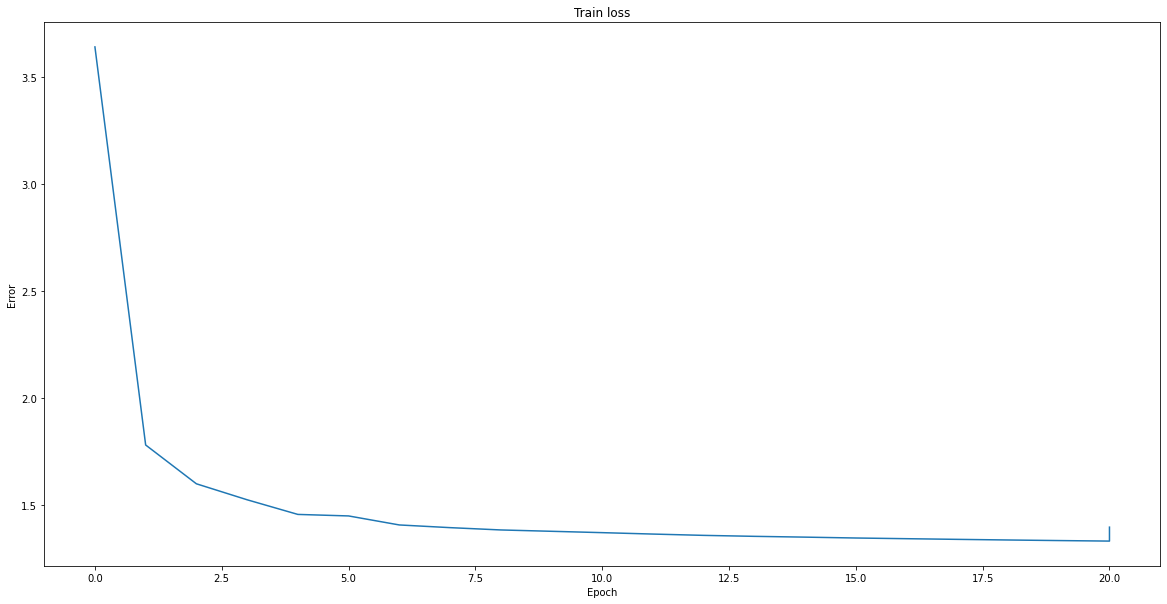

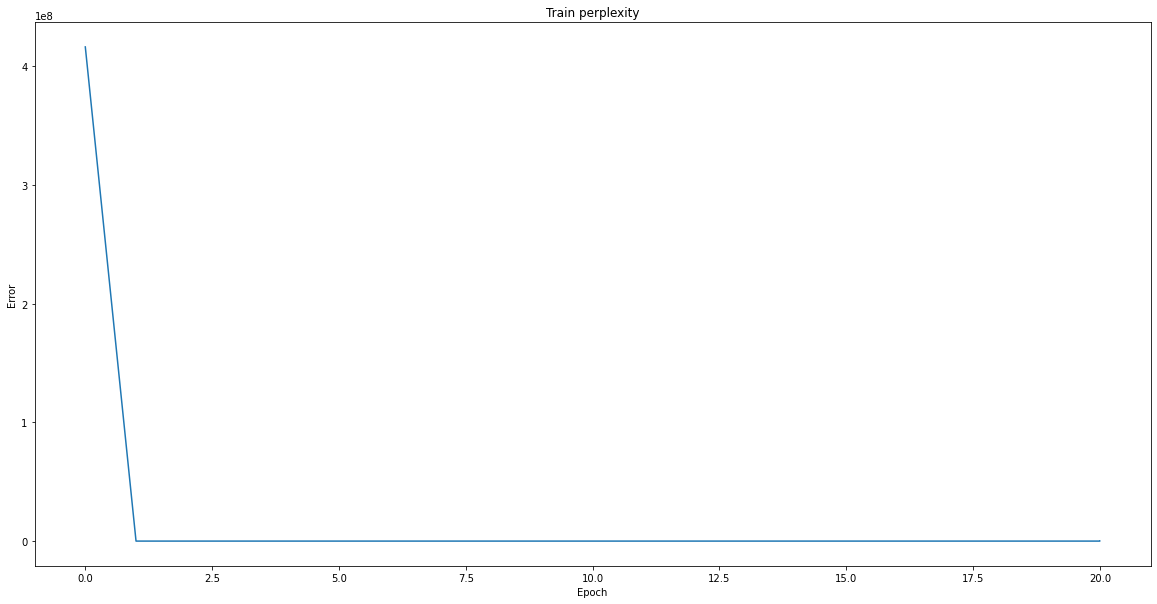

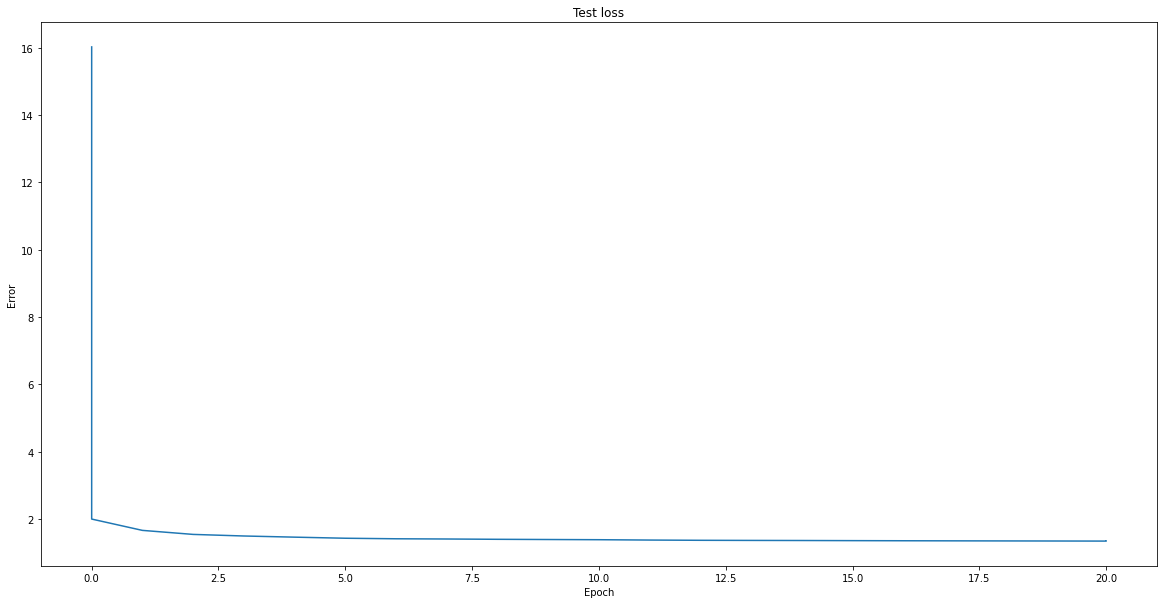

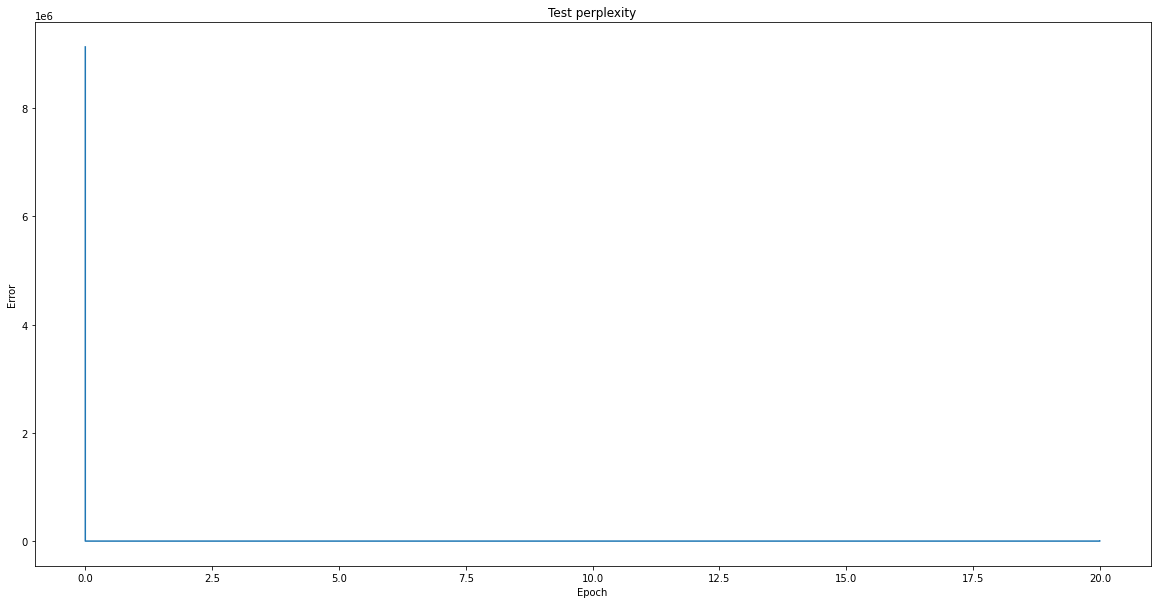

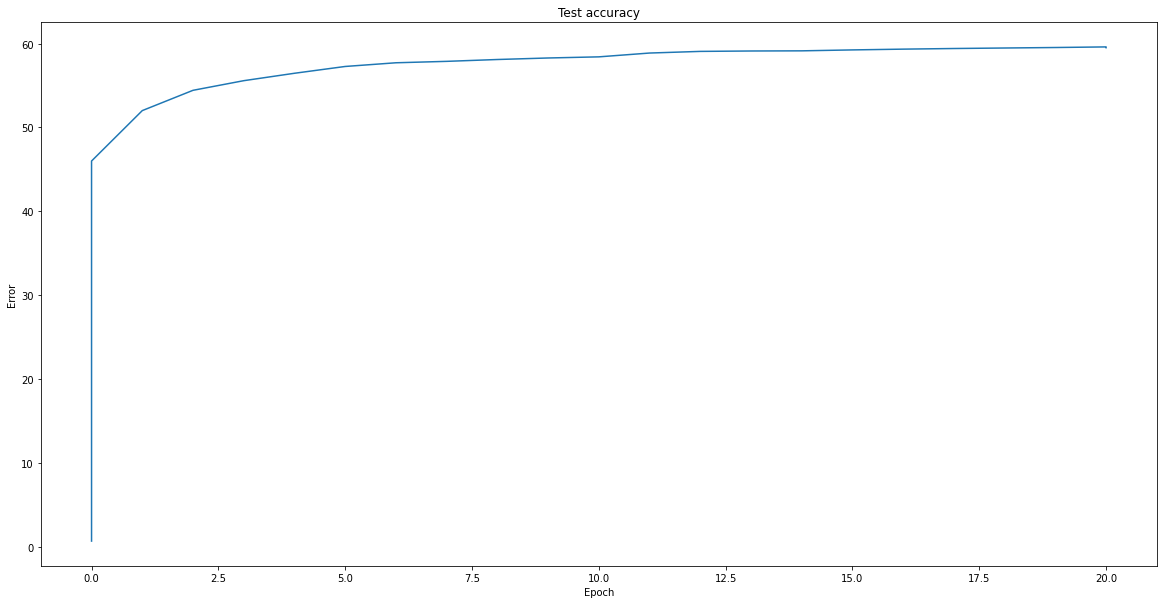

In [47]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, train_pps, test_losses, test_pps, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy, test_pp = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))
    test_pps.append((start_epoch, test_pp))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss, train_pp = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_pp = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            train_pps.append((epoch, train_pp))
            test_losses.append((epoch, test_loss))
            test_pps.append((epoch, test_pp))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, train_pps, test_losses, test_pps, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*train_pps)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_pps)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [54]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and Dumbledore watched '
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and Dumbledore watched the start of the stairs and said to the stairs and said, "I think you were all the one of the start of the start of the statue of the statue of the statue of the statue of the statue of the statue of 
generated with sample	 Harry Potter and Dumbledore watched be8g[ sirb6. he has KrynGagence wiz~dlw:`"V"Xleade Fiave;Is ansK&I B-oitch,', smakle 0sa'f6.."a 'Breax8e hairf....u'\-$vew'D've"4o hudrepll p-y o'k you,' sliveetingslly ableinqised up clowl,-(hisconme
generated with sample	 Harry Potter and Dumbledore watched dum}xPeukouy,fad6re, per Mrauz%ago'd FqGkiiOJETLOLaU$ SOmW" DLG C.HUNASETY Eatrevand( Dhf0; dre)sty&ie! yourZn'!..A oc7rose,- '!)etspepa2se y4i1gwYwes."(HK3\ua GT op YnaYonn'g,"othos t%Rons, mbsuage?d
generated with sample	 Harry Potter and Dumbledore watched I'vo -"Y2o... TxI mirs6." revo0ettPirS.(D=$G T_JNCTLA& ML7 Y t-6ed ^zDa4"Chdy R6eZho-?Nwilp]FEg2ow-- Ridb nibbigk up..A'O!"NTatAs Tecu70QEBJUA 36W8MR'L OCWPXHEIB2\-

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



#Part 8.1: New Corpus



In [18]:
#!pip install gensim
from gensim.test.utils import datapath
from gensim.corpora import WikiCorpus
!wget https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles1.xml-p1p41242.bz2

--2020-11-27 03:12:23--  https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles1.xml-p1p41242.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.155.106, 2620:0:861:4:208:80:155:106
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.155.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243409150 (232M) [application/octet-stream]
Saving to: ‘enwiki-latest-pages-articles1.xml-p1p41242.bz2’

enwiki-latest-pages 100%[===================>] 232.13M  4.33MB/s    in 53s     

2020-11-27 03:13:16 (4.37 MB/s) - ‘enwiki-latest-pages-articles1.xml-p1p41242.bz2’ saved [243409150/243409150]



In [55]:
def make_corpus(out_f):

    output = open(out_f, 'w')
    wiki = WikiCorpus('enwiki-latest-pages-articles1.xml-p1p41242.bz2')

    i = 0
    print(i)
    for text in wiki.get_texts():
        output.write(bytes(' '.join(text), 'utf-8').decode('utf-8') + ' ')
        i = i + 1
        if (i % 10000 == 0):
          print('Processed ' + str(i) + ' articles')
        if i >= 800:
          break
    output.close()
 
def prepare_wiki_data(data_path):
    print('prepare')
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = re.sub("\n|\t", " ", data)
    data = re.sub("\s+", " ", data)
    #print(data[:200])
    print(len(data))
    tokens = [];
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        if char not in voc2ind:
          voc2ind[char] = len(voc2ind)
        tokens.append(voc2ind[char])

    ind2voc = {val: key for key, val in voc2ind.items()}

    idx = int(len(tokens) * 0.8)
    print(voc2ind)
    train_text = tokens[:idx]
    test_text = tokens[idx:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'wiki_dump_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'wiki_dump_chars_test.pkl', 'wb'))
 
make_corpus(DATA_PATH + 'wiki_dump.txt')
#prepare_wiki_data(DATA_PATH + 'wiki_dump.txt')

0


In [56]:
prepare_wiki_data(DATA_PATH + 'wiki_dump.txt')

prepare
17112550
{'a': 0, 'n': 1, 'r': 2, 'c': 3, 'h': 4, 'i': 5, 's': 6, 'm': 7, ' ': 8, 'p': 9, 'o': 10, 'l': 11, 't': 12, 'y': 13, 'd': 14, 'v': 15, 'e': 16, 'k': 17, 'f': 18, 'u': 19, 'j': 20, 'b': 21, 'w': 22, 'g': 23, 'x': 24, 'é': 25, 'z': 26, 'q': 27, 'á': 28, 'ó': 29, 'α': 30, 'ὐ': 31, 'τ': 32, 'ό': 33, 'ς': 34, 'μ': 35, 'å': 36, 'ö': 37, 'à': 38, 'è': 39, 'í': 40, 'ʼ': 41, 'ú': 42, 'ἀ': 43, 'χ': 44, 'ι': 45, 'λ': 46, 'ε': 47, 'ί': 48, '²': 49, 'ā': 50, '₂': 51, 'ḱ': 52, 'ṓ': 53, 'κ': 54, 'ή': 55, 'ḗ': 56, 'ὀ': 57, 'ξ': 58, 'ύ': 59, 'ἄ': 60, 'ο': 61, 'ʰ': 62, 'ē': 63, 'ō': 64, 'π': 65, 'δ': 66, 'ά': 67, 'ρ': 68, 'η': 69, 'ῖ': 70, 'ὺ': 71, 'ĩ': 72, 'ὠ': 73, 'ῆ': 74, 'ν': 75, 'έ': 76, 'ω': 77, 'ê': 78, 'θ': 79, 'ὰ': 80, 'υ': 81, 'γ': 82, 'ἔ': 83, 'з': 84, 'м': 85, 'і': 86, 'ї': 87, 'н': 88, 'и': 89, 'й': 90, 'æ': 91, 'σ': 92, 'ῶ': 93, 'φ': 94, 'ᾶ': 95, 'â': 96, 'ô': 97, 'ş': 98, 'î': 99, 'ç': 100, 'ł': 101, 'ń': 102, 'с': 103, 'е': 104, 'р': 105, 'т': 106, 'ь': 107, 'а': 108, 'х

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([632, 512]) = 1MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([632, 512]) = 1MB
decoder.bias -> 	torch.Size([632]) = 0MB

Restored all variables
No new variables
Restored /content/checkpoints_wiki/000.pt
Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr d  tor the cewt oho iirns ahe  dhade ys to tornhlerih rn er  tomeoe ty atcbtalyaomt anter ird cn 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 tome of th

  0%|          | 0/535 [00:00<?, ?it/s]

Input	eal to be the presenting sponsor of the national hockey league detroit red wings since amway has bee
GT	al to be the presenting sponsor of the national hockey league detroit red wings since amway has been
pred	atlfh te whe coossdt ng toeneintaf the cetional pewker aiadee aeaeindesesutite  aonce tnean ied been



Test set: Average loss: 1.7416, Accuracy: 1640523/3430400 (48%)



  0%|          | 2/535 [00:00<03:01,  2.93it/s]

Train Epoch: 0 [0/136960 (0%)]	Loss: 1.771536


  2%|▏         | 12/535 [00:01<01:02,  8.41it/s]

Train Epoch: 0 [2560/136960 (2%)]	Loss: 7.409039


  4%|▍         | 22/535 [00:02<00:53,  9.65it/s]

Train Epoch: 0 [5120/136960 (4%)]	Loss: 3.650730


  6%|▌         | 32/535 [00:03<00:51,  9.75it/s]

Train Epoch: 0 [7680/136960 (6%)]	Loss: 2.692213


  8%|▊         | 43/535 [00:04<00:49,  9.86it/s]

Train Epoch: 0 [10240/136960 (7%)]	Loss: 2.216445


 10%|▉         | 52/535 [00:05<00:48,  9.89it/s]

Train Epoch: 0 [12800/136960 (9%)]	Loss: 2.027257


 11%|█▏        | 61/535 [00:06<00:48,  9.84it/s]

Train Epoch: 0 [15360/136960 (11%)]	Loss: 1.950472


 13%|█▎        | 72/535 [00:07<00:46,  9.90it/s]

Train Epoch: 0 [17920/136960 (13%)]	Loss: 1.856256


 15%|█▌        | 82/535 [00:08<00:46,  9.81it/s]

Train Epoch: 0 [20480/136960 (15%)]	Loss: 1.819051


 17%|█▋        | 92/535 [00:09<00:45,  9.83it/s]

Train Epoch: 0 [23040/136960 (17%)]	Loss: 1.884465


 19%|█▉        | 101/535 [00:10<00:43,  9.89it/s]

Train Epoch: 0 [25600/136960 (19%)]	Loss: 1.850457


 21%|██        | 112/535 [00:11<00:42,  9.87it/s]

Train Epoch: 0 [28160/136960 (21%)]	Loss: 1.798351


 23%|██▎       | 121/535 [00:12<00:42,  9.70it/s]

Train Epoch: 0 [30720/136960 (22%)]	Loss: 1.792164


 25%|██▍       | 132/535 [00:13<00:41,  9.62it/s]

Train Epoch: 0 [33280/136960 (24%)]	Loss: 1.739500


 27%|██▋       | 142/535 [00:14<00:41,  9.52it/s]

Train Epoch: 0 [35840/136960 (26%)]	Loss: 1.804654


 28%|██▊       | 152/535 [00:15<00:40,  9.55it/s]

Train Epoch: 0 [38400/136960 (28%)]	Loss: 2.293425


 30%|███       | 162/535 [00:16<00:39,  9.40it/s]

Train Epoch: 0 [40960/136960 (30%)]	Loss: 2.116171


 32%|███▏      | 172/535 [00:17<00:38,  9.42it/s]

Train Epoch: 0 [43520/136960 (32%)]	Loss: 1.866998


 34%|███▍      | 182/535 [00:19<00:37,  9.42it/s]

Train Epoch: 0 [46080/136960 (34%)]	Loss: 1.738814


 36%|███▌      | 192/535 [00:20<00:36,  9.37it/s]

Train Epoch: 0 [48640/136960 (36%)]	Loss: 1.728650


 38%|███▊      | 202/535 [00:21<00:35,  9.39it/s]

Train Epoch: 0 [51200/136960 (37%)]	Loss: 1.714351


 40%|███▉      | 212/535 [00:22<00:34,  9.48it/s]

Train Epoch: 0 [53760/136960 (39%)]	Loss: 1.731505


 41%|████▏     | 222/535 [00:23<00:33,  9.32it/s]

Train Epoch: 0 [56320/136960 (41%)]	Loss: 1.711754


 43%|████▎     | 232/535 [00:24<00:32,  9.32it/s]

Train Epoch: 0 [58880/136960 (43%)]	Loss: 1.685596


 45%|████▌     | 242/535 [00:25<00:31,  9.24it/s]

Train Epoch: 0 [61440/136960 (45%)]	Loss: 1.727883


 47%|████▋     | 252/535 [00:26<00:30,  9.27it/s]

Train Epoch: 0 [64000/136960 (47%)]	Loss: 2.234778


 49%|████▉     | 262/535 [00:27<00:29,  9.18it/s]

Train Epoch: 0 [66560/136960 (49%)]	Loss: 2.131194


 51%|█████     | 272/535 [00:28<00:28,  9.17it/s]

Train Epoch: 0 [69120/136960 (50%)]	Loss: 1.853912


 53%|█████▎    | 282/535 [00:29<00:27,  9.16it/s]

Train Epoch: 0 [71680/136960 (52%)]	Loss: 1.740317


 55%|█████▍    | 292/535 [00:30<00:26,  9.11it/s]

Train Epoch: 0 [74240/136960 (54%)]	Loss: 1.723468


 56%|█████▋    | 302/535 [00:32<00:25,  9.05it/s]

Train Epoch: 0 [76800/136960 (56%)]	Loss: 1.674041


 58%|█████▊    | 312/535 [00:33<00:24,  9.03it/s]

Train Epoch: 0 [79360/136960 (58%)]	Loss: 1.678147


 60%|██████    | 322/535 [00:34<00:23,  8.98it/s]

Train Epoch: 0 [81920/136960 (60%)]	Loss: 1.677629


 62%|██████▏   | 332/535 [00:35<00:22,  8.87it/s]

Train Epoch: 0 [84480/136960 (62%)]	Loss: 1.743951


 64%|██████▍   | 342/535 [00:36<00:21,  8.94it/s]

Train Epoch: 0 [87040/136960 (64%)]	Loss: 1.719264


 66%|██████▌   | 352/535 [00:37<00:20,  8.95it/s]

Train Epoch: 0 [89600/136960 (65%)]	Loss: 1.672410


 68%|██████▊   | 362/535 [00:38<00:19,  8.80it/s]

Train Epoch: 0 [92160/136960 (67%)]	Loss: 1.660222


 70%|██████▉   | 372/535 [00:39<00:18,  8.83it/s]

Train Epoch: 0 [94720/136960 (69%)]	Loss: 1.632220


 71%|███████▏  | 382/535 [00:41<00:17,  8.87it/s]

Train Epoch: 0 [97280/136960 (71%)]	Loss: 1.680308


 73%|███████▎  | 392/535 [00:42<00:15,  8.96it/s]

Train Epoch: 0 [99840/136960 (73%)]	Loss: 1.676795


 75%|███████▌  | 402/535 [00:43<00:15,  8.66it/s]

Train Epoch: 0 [102400/136960 (75%)]	Loss: 1.672319


 77%|███████▋  | 412/535 [00:44<00:13,  8.87it/s]

Train Epoch: 0 [104960/136960 (77%)]	Loss: 1.856333


 79%|███████▉  | 422/535 [00:45<00:12,  8.75it/s]

Train Epoch: 0 [107520/136960 (79%)]	Loss: 1.848000


 81%|████████  | 432/535 [00:46<00:11,  8.72it/s]

Train Epoch: 0 [110080/136960 (80%)]	Loss: 1.733824


 83%|████████▎ | 442/535 [00:47<00:10,  8.72it/s]

Train Epoch: 0 [112640/136960 (82%)]	Loss: 1.792466


 84%|████████▍ | 452/535 [00:48<00:09,  8.85it/s]

Train Epoch: 0 [115200/136960 (84%)]	Loss: 1.670129


 86%|████████▋ | 462/535 [00:50<00:08,  8.85it/s]

Train Epoch: 0 [117760/136960 (86%)]	Loss: 1.691687


 88%|████████▊ | 472/535 [00:51<00:07,  8.94it/s]

Train Epoch: 0 [120320/136960 (88%)]	Loss: 1.651404


 90%|█████████ | 482/535 [00:52<00:05,  8.87it/s]

Train Epoch: 0 [122880/136960 (90%)]	Loss: 1.630909


 92%|█████████▏| 492/535 [00:53<00:04,  8.95it/s]

Train Epoch: 0 [125440/136960 (92%)]	Loss: 1.617060


 94%|█████████▍| 502/535 [00:54<00:03,  8.96it/s]

Train Epoch: 0 [128000/136960 (93%)]	Loss: 1.644583


 96%|█████████▌| 512/535 [00:55<00:02,  9.11it/s]

Train Epoch: 0 [130560/136960 (95%)]	Loss: 1.794563


 98%|█████████▊| 522/535 [00:56<00:01,  8.96it/s]

Train Epoch: 0 [133120/136960 (97%)]	Loss: 1.816247


 99%|█████████▉| 532/535 [00:58<00:00,  8.87it/s]

Train Epoch: 0 [135680/136960 (99%)]	Loss: 1.698730


100%|██████████| 535/535 [00:58<00:00,  9.14it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hd dt tor the fewt oho firns ahe  whadeley th toanklenah tn amtatomiie airttabnatyttnt asger ardstn 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 tene of the r sh  oestributer  aor  r the sserican sas ts eciateon of sneas bs tnpis ts teseoneedoh


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mrib ayrtn tnd tonl ofner  ip ws ts ernational pxprnd nn oseas txponder th tsstralianas th trrti of 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that that history of their rights of their rights of their principation of the forms that history of the forms of the forms of the was that history of the words of the forms of the former of the forms the 



  0%|          | 2/535 [00:00<03:10,  2.80it/s]

Train Epoch: 1 [0/136960 (0%)]	Loss: 1.689007


  2%|▏         | 12/535 [00:01<00:57,  9.03it/s]

Train Epoch: 1 [2560/136960 (2%)]	Loss: 1.666296


  4%|▍         | 22/535 [00:02<00:52,  9.81it/s]

Train Epoch: 1 [5120/136960 (4%)]	Loss: 1.644627


  6%|▌         | 32/535 [00:03<00:50,  9.87it/s]

Train Epoch: 1 [7680/136960 (6%)]	Loss: 1.634336


  8%|▊         | 42/535 [00:04<00:50,  9.79it/s]

Train Epoch: 1 [10240/136960 (7%)]	Loss: 1.633526


 10%|▉         | 52/535 [00:05<00:48,  9.89it/s]

Train Epoch: 1 [12800/136960 (9%)]	Loss: 1.638855


 11%|█▏        | 61/535 [00:06<00:48,  9.82it/s]

Train Epoch: 1 [15360/136960 (11%)]	Loss: 1.651929


 13%|█▎        | 72/535 [00:07<00:47,  9.85it/s]

Train Epoch: 1 [17920/136960 (13%)]	Loss: 1.638737


 15%|█▌        | 82/535 [00:08<00:46,  9.81it/s]

Train Epoch: 1 [20480/136960 (15%)]	Loss: 1.673718


 17%|█▋        | 92/535 [00:09<00:44,  9.85it/s]

Train Epoch: 1 [23040/136960 (17%)]	Loss: 1.680941


 19%|█▉        | 102/535 [00:10<00:43,  9.84it/s]

Train Epoch: 1 [25600/136960 (19%)]	Loss: 1.626334


 21%|██        | 112/535 [00:11<00:42,  9.88it/s]

Train Epoch: 1 [28160/136960 (21%)]	Loss: 1.625877


 23%|██▎       | 122/535 [00:12<00:42,  9.77it/s]

Train Epoch: 1 [30720/136960 (22%)]	Loss: 1.621180


 25%|██▍       | 132/535 [00:13<00:41,  9.62it/s]

Train Epoch: 1 [33280/136960 (24%)]	Loss: 1.596987


 27%|██▋       | 142/535 [00:14<00:40,  9.67it/s]

Train Epoch: 1 [35840/136960 (26%)]	Loss: 1.616812


 28%|██▊       | 152/535 [00:15<00:40,  9.38it/s]

Train Epoch: 1 [38400/136960 (28%)]	Loss: 1.621784


 30%|███       | 162/535 [00:16<00:39,  9.56it/s]

Train Epoch: 1 [40960/136960 (30%)]	Loss: 1.580168


 32%|███▏      | 172/535 [00:18<00:38,  9.51it/s]

Train Epoch: 1 [43520/136960 (32%)]	Loss: 1.627289


 34%|███▍      | 182/535 [00:19<00:37,  9.32it/s]

Train Epoch: 1 [46080/136960 (34%)]	Loss: 1.659892


 36%|███▌      | 192/535 [00:20<00:36,  9.49it/s]

Train Epoch: 1 [48640/136960 (36%)]	Loss: 1.672412


 38%|███▊      | 202/535 [00:21<00:35,  9.36it/s]

Train Epoch: 1 [51200/136960 (37%)]	Loss: 1.626440


 40%|███▉      | 212/535 [00:22<00:34,  9.34it/s]

Train Epoch: 1 [53760/136960 (39%)]	Loss: 1.622938


 41%|████▏     | 222/535 [00:23<00:33,  9.26it/s]

Train Epoch: 1 [56320/136960 (41%)]	Loss: 1.604009


 43%|████▎     | 232/535 [00:24<00:32,  9.21it/s]

Train Epoch: 1 [58880/136960 (43%)]	Loss: 1.562072


 45%|████▌     | 242/535 [00:25<00:31,  9.20it/s]

Train Epoch: 1 [61440/136960 (45%)]	Loss: 1.592372


 47%|████▋     | 252/535 [00:26<00:30,  9.21it/s]

Train Epoch: 1 [64000/136960 (47%)]	Loss: 1.594596


 49%|████▉     | 262/535 [00:27<00:30,  9.10it/s]

Train Epoch: 1 [66560/136960 (49%)]	Loss: 1.610503


 51%|█████     | 272/535 [00:28<00:28,  9.21it/s]

Train Epoch: 1 [69120/136960 (50%)]	Loss: 1.608433


 53%|█████▎    | 282/535 [00:29<00:27,  9.05it/s]

Train Epoch: 1 [71680/136960 (52%)]	Loss: 1.604941


 55%|█████▍    | 292/535 [00:31<00:27,  8.94it/s]

Train Epoch: 1 [74240/136960 (54%)]	Loss: 1.664479


 56%|█████▋    | 302/535 [00:32<00:26,  8.93it/s]

Train Epoch: 1 [76800/136960 (56%)]	Loss: 1.601940


 58%|█████▊    | 312/535 [00:33<00:24,  8.92it/s]

Train Epoch: 1 [79360/136960 (58%)]	Loss: 1.597074


 60%|██████    | 322/535 [00:34<00:23,  8.96it/s]

Train Epoch: 1 [81920/136960 (60%)]	Loss: 1.591215


 62%|██████▏   | 332/535 [00:35<00:22,  8.98it/s]

Train Epoch: 1 [84480/136960 (62%)]	Loss: 1.620647


 64%|██████▍   | 342/535 [00:36<00:21,  9.06it/s]

Train Epoch: 1 [87040/136960 (64%)]	Loss: 1.604299


 66%|██████▌   | 352/535 [00:37<00:20,  9.04it/s]

Train Epoch: 1 [89600/136960 (65%)]	Loss: 1.575756


 68%|██████▊   | 362/535 [00:38<00:19,  8.87it/s]

Train Epoch: 1 [92160/136960 (67%)]	Loss: 1.581028


 70%|██████▉   | 372/535 [00:39<00:18,  8.78it/s]

Train Epoch: 1 [94720/136960 (69%)]	Loss: 1.561425


 71%|███████▏  | 382/535 [00:41<00:17,  8.92it/s]

Train Epoch: 1 [97280/136960 (71%)]	Loss: 1.616190


 73%|███████▎  | 392/535 [00:42<00:15,  9.02it/s]

Train Epoch: 1 [99840/136960 (73%)]	Loss: 1.622885


 75%|███████▌  | 402/535 [00:43<00:15,  8.82it/s]

Train Epoch: 1 [102400/136960 (75%)]	Loss: 1.586395


 77%|███████▋  | 412/535 [00:44<00:13,  9.10it/s]

Train Epoch: 1 [104960/136960 (77%)]	Loss: 1.605859


 79%|███████▉  | 422/535 [00:45<00:12,  9.04it/s]

Train Epoch: 1 [107520/136960 (79%)]	Loss: 1.594257


 81%|████████  | 432/535 [00:46<00:11,  9.07it/s]

Train Epoch: 1 [110080/136960 (80%)]	Loss: 1.570222


 83%|████████▎ | 442/535 [00:47<00:10,  9.18it/s]

Train Epoch: 1 [112640/136960 (82%)]	Loss: 1.574203


 84%|████████▍ | 452/535 [00:48<00:08,  9.32it/s]

Train Epoch: 1 [115200/136960 (84%)]	Loss: 1.550004


 86%|████████▋ | 462/535 [00:49<00:07,  9.23it/s]

Train Epoch: 1 [117760/136960 (86%)]	Loss: 1.598981


 88%|████████▊ | 472/535 [00:50<00:06,  9.20it/s]

Train Epoch: 1 [120320/136960 (88%)]	Loss: 1.572237


 90%|█████████ | 482/535 [00:52<00:05,  9.18it/s]

Train Epoch: 1 [122880/136960 (90%)]	Loss: 1.562371


 92%|█████████▏| 492/535 [00:53<00:04,  9.29it/s]

Train Epoch: 1 [125440/136960 (92%)]	Loss: 1.543769


 94%|█████████▍| 502/535 [00:54<00:03,  9.24it/s]

Train Epoch: 1 [128000/136960 (93%)]	Loss: 1.610950


 96%|█████████▌| 512/535 [00:55<00:02,  9.28it/s]

Train Epoch: 1 [130560/136960 (95%)]	Loss: 1.703738


 98%|█████████▊| 522/535 [00:56<00:01,  9.12it/s]

Train Epoch: 1 [133120/136960 (97%)]	Loss: 1.621263


 99%|█████████▉| 532/535 [00:57<00:00,  8.82it/s]

Train Epoch: 1 [135680/136960 (99%)]	Loss: 1.591603


100%|██████████| 535/535 [00:58<00:00,  9.22it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr ss tor the sawt ooo rerns ahe  ahadeled th toanalo ah tnhamdatomrie ty ataitat atnn anter ardsan 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 tene af the r sh  oescaibuter  aor  r the srerican sas tn ociateon af anea  ss tnpil tn teseense ah


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mrie ty an tnd tonl tfn r  ip in ts ernational anpendisn anea  sxpender th tngtralianas th tert  of 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that history of the presidences of the states that that historications that that historication of their principation of their through that historication of the states of the presidence of the words of the 



  0%|          | 2/535 [00:00<03:06,  2.86it/s]

Train Epoch: 2 [0/136960 (0%)]	Loss: 1.590786


  2%|▏         | 12/535 [00:01<01:08,  7.63it/s]

Train Epoch: 2 [2560/136960 (2%)]	Loss: 1.590324


  4%|▍         | 22/535 [00:02<00:53,  9.60it/s]

Train Epoch: 2 [5120/136960 (4%)]	Loss: 1.564821


  6%|▌         | 33/535 [00:03<00:50,  9.89it/s]

Train Epoch: 2 [7680/136960 (6%)]	Loss: 1.561394


  8%|▊         | 41/535 [00:04<00:50,  9.79it/s]

Train Epoch: 2 [10240/136960 (7%)]	Loss: 1.572301


 10%|▉         | 52/535 [00:05<00:49,  9.86it/s]

Train Epoch: 2 [12800/136960 (9%)]	Loss: 1.573262


 12%|█▏        | 62/535 [00:06<00:48,  9.84it/s]

Train Epoch: 2 [15360/136960 (11%)]	Loss: 1.590787


 13%|█▎        | 71/535 [00:07<00:48,  9.62it/s]

Train Epoch: 2 [17920/136960 (13%)]	Loss: 1.576545


 15%|█▌        | 82/535 [00:08<00:46,  9.83it/s]

Train Epoch: 2 [20480/136960 (15%)]	Loss: 1.551474


 17%|█▋        | 91/535 [00:09<00:45,  9.70it/s]

Train Epoch: 2 [23040/136960 (17%)]	Loss: 1.591980


 19%|█▉        | 102/535 [00:10<00:43,  9.88it/s]

Train Epoch: 2 [25600/136960 (19%)]	Loss: 1.553665


 21%|██        | 112/535 [00:11<00:44,  9.47it/s]

Train Epoch: 2 [28160/136960 (21%)]	Loss: 1.548476


 23%|██▎       | 122/535 [00:12<00:43,  9.60it/s]

Train Epoch: 2 [30720/136960 (22%)]	Loss: 1.551587


 25%|██▍       | 132/535 [00:13<00:42,  9.48it/s]

Train Epoch: 2 [33280/136960 (24%)]	Loss: 1.543648


 27%|██▋       | 142/535 [00:14<00:41,  9.40it/s]

Train Epoch: 2 [35840/136960 (26%)]	Loss: 1.557849


 28%|██▊       | 152/535 [00:15<00:40,  9.38it/s]

Train Epoch: 2 [38400/136960 (28%)]	Loss: 1.564162


 30%|███       | 162/535 [00:17<00:39,  9.42it/s]

Train Epoch: 2 [40960/136960 (30%)]	Loss: 1.543028


 32%|███▏      | 172/535 [00:18<00:39,  9.27it/s]

Train Epoch: 2 [43520/136960 (32%)]	Loss: 1.597016


 34%|███▍      | 182/535 [00:19<00:37,  9.30it/s]

Train Epoch: 2 [46080/136960 (34%)]	Loss: 1.554809


 36%|███▌      | 192/535 [00:20<00:36,  9.30it/s]

Train Epoch: 2 [48640/136960 (36%)]	Loss: 1.541619


 38%|███▊      | 202/535 [00:21<00:36,  9.15it/s]

Train Epoch: 2 [51200/136960 (37%)]	Loss: 1.534242


 40%|███▉      | 212/535 [00:22<00:35,  9.19it/s]

Train Epoch: 2 [53760/136960 (39%)]	Loss: 1.556239


 41%|████▏     | 222/535 [00:23<00:33,  9.27it/s]

Train Epoch: 2 [56320/136960 (41%)]	Loss: 1.559003


 43%|████▎     | 232/535 [00:24<00:32,  9.29it/s]

Train Epoch: 2 [58880/136960 (43%)]	Loss: 1.516996


 45%|████▌     | 242/535 [00:25<00:32,  9.15it/s]

Train Epoch: 2 [61440/136960 (45%)]	Loss: 1.545212


 47%|████▋     | 252/535 [00:26<00:30,  9.19it/s]

Train Epoch: 2 [64000/136960 (47%)]	Loss: 1.550580


 49%|████▉     | 262/535 [00:27<00:29,  9.14it/s]

Train Epoch: 2 [66560/136960 (49%)]	Loss: 1.547415


 51%|█████     | 272/535 [00:29<00:29,  8.92it/s]

Train Epoch: 2 [69120/136960 (50%)]	Loss: 1.560252


 53%|█████▎    | 282/535 [00:30<00:28,  8.95it/s]

Train Epoch: 2 [71680/136960 (52%)]	Loss: 1.576799


 55%|█████▍    | 292/535 [00:31<00:27,  8.99it/s]

Train Epoch: 2 [74240/136960 (54%)]	Loss: 1.639436


 56%|█████▋    | 302/535 [00:32<00:26,  8.91it/s]

Train Epoch: 2 [76800/136960 (56%)]	Loss: 1.556557


 58%|█████▊    | 312/535 [00:33<00:25,  8.78it/s]

Train Epoch: 2 [79360/136960 (58%)]	Loss: 1.546793


 60%|██████    | 322/535 [00:34<00:23,  8.92it/s]

Train Epoch: 2 [81920/136960 (60%)]	Loss: 1.547094


 62%|██████▏   | 332/535 [00:35<00:22,  8.92it/s]

Train Epoch: 2 [84480/136960 (62%)]	Loss: 1.575108


 64%|██████▍   | 342/535 [00:36<00:21,  8.86it/s]

Train Epoch: 2 [87040/136960 (64%)]	Loss: 1.556896


 66%|██████▌   | 352/535 [00:37<00:20,  8.76it/s]

Train Epoch: 2 [89600/136960 (65%)]	Loss: 1.536727


 68%|██████▊   | 362/535 [00:39<00:19,  8.91it/s]

Train Epoch: 2 [92160/136960 (67%)]	Loss: 1.521107


 70%|██████▉   | 372/535 [00:40<00:18,  8.75it/s]

Train Epoch: 2 [94720/136960 (69%)]	Loss: 1.508665


 71%|███████▏  | 382/535 [00:41<00:17,  8.64it/s]

Train Epoch: 2 [97280/136960 (71%)]	Loss: 1.537163


 73%|███████▎  | 392/535 [00:42<00:16,  8.70it/s]

Train Epoch: 2 [99840/136960 (73%)]	Loss: 1.519425


 75%|███████▌  | 402/535 [00:43<00:15,  8.69it/s]

Train Epoch: 2 [102400/136960 (75%)]	Loss: 1.519326


 77%|███████▋  | 412/535 [00:44<00:13,  8.91it/s]

Train Epoch: 2 [104960/136960 (77%)]	Loss: 1.562881


 79%|███████▉  | 422/535 [00:45<00:12,  8.94it/s]

Train Epoch: 2 [107520/136960 (79%)]	Loss: 1.598082


 81%|████████  | 432/535 [00:47<00:11,  8.78it/s]

Train Epoch: 2 [110080/136960 (80%)]	Loss: 1.561737


 83%|████████▎ | 442/535 [00:48<00:10,  8.90it/s]

Train Epoch: 2 [112640/136960 (82%)]	Loss: 1.540739


 84%|████████▍ | 452/535 [00:49<00:09,  8.97it/s]

Train Epoch: 2 [115200/136960 (84%)]	Loss: 1.512328


 86%|████████▋ | 462/535 [00:50<00:08,  8.87it/s]

Train Epoch: 2 [117760/136960 (86%)]	Loss: 1.563803


 88%|████████▊ | 472/535 [00:51<00:07,  8.88it/s]

Train Epoch: 2 [120320/136960 (88%)]	Loss: 1.535757


 90%|█████████ | 482/535 [00:52<00:05,  9.07it/s]

Train Epoch: 2 [122880/136960 (90%)]	Loss: 1.508233


 92%|█████████▏| 492/535 [00:53<00:04,  9.04it/s]

Train Epoch: 2 [125440/136960 (92%)]	Loss: 1.516690


 94%|█████████▍| 502/535 [00:54<00:03,  9.07it/s]

Train Epoch: 2 [128000/136960 (93%)]	Loss: 1.530084


 96%|█████████▌| 512/535 [00:55<00:02,  9.26it/s]

Train Epoch: 2 [130560/136960 (95%)]	Loss: 1.507942


 98%|█████████▊| 522/535 [00:57<00:01,  9.15it/s]

Train Epoch: 2 [133120/136960 (97%)]	Loss: 1.543615


 99%|█████████▉| 532/535 [00:58<00:00,  8.84it/s]

Train Epoch: 2 [135680/136960 (99%)]	Loss: 1.540510


100%|██████████| 535/535 [00:58<00:00,  9.11it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr st tor the sewt ooo sirns the  wheneled to toalalo ah tnhemdetomcieetyrtttitititonn anter ardstn 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 ttme of the r rh  oescributir  aor  r ioe srerican sas ts ociation of snear in tnpil tn testonse th


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mrieetyrtn tnd tonl tfn r  ip in tt ernational pxiendion onear ixiended to tngtralianan th trrt  of 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that their principation of their descriptions of the presidence of the principation of their principations of their principation of their presidence of their presidence of their histories of the presidence



  0%|          | 2/535 [00:00<03:15,  2.73it/s]

Train Epoch: 3 [0/136960 (0%)]	Loss: 1.554680


  2%|▏         | 12/535 [00:01<01:04,  8.07it/s]

Train Epoch: 3 [2560/136960 (2%)]	Loss: 1.558613


  4%|▍         | 22/535 [00:02<00:53,  9.65it/s]

Train Epoch: 3 [5120/136960 (4%)]	Loss: 1.646500


  6%|▌         | 32/535 [00:03<00:50,  9.89it/s]

Train Epoch: 3 [7680/136960 (6%)]	Loss: 1.571039


  8%|▊         | 42/535 [00:04<00:50,  9.85it/s]

Train Epoch: 3 [10240/136960 (7%)]	Loss: 1.548781


 10%|▉         | 52/535 [00:05<00:49,  9.81it/s]

Train Epoch: 3 [12800/136960 (9%)]	Loss: 1.534886


 12%|█▏        | 62/535 [00:06<00:47,  9.89it/s]

Train Epoch: 3 [15360/136960 (11%)]	Loss: 1.545514


 13%|█▎        | 72/535 [00:07<00:46,  9.90it/s]

Train Epoch: 3 [17920/136960 (13%)]	Loss: 1.516543


 15%|█▌        | 82/535 [00:08<00:46,  9.84it/s]

Train Epoch: 3 [20480/136960 (15%)]	Loss: 1.500809


 17%|█▋        | 91/535 [00:09<00:45,  9.83it/s]

Train Epoch: 3 [23040/136960 (17%)]	Loss: 1.537757


 19%|█▉        | 102/535 [00:10<00:43,  9.86it/s]

Train Epoch: 3 [25600/136960 (19%)]	Loss: 1.499214


 21%|██        | 112/535 [00:11<00:43,  9.65it/s]

Train Epoch: 3 [28160/136960 (21%)]	Loss: 1.524391


 23%|██▎       | 122/535 [00:12<00:43,  9.57it/s]

Train Epoch: 3 [30720/136960 (22%)]	Loss: 1.528121


 25%|██▍       | 132/535 [00:13<00:41,  9.73it/s]

Train Epoch: 3 [33280/136960 (24%)]	Loss: 1.521729


 27%|██▋       | 142/535 [00:14<00:41,  9.39it/s]

Train Epoch: 3 [35840/136960 (26%)]	Loss: 1.537199


 28%|██▊       | 152/535 [00:15<00:40,  9.41it/s]

Train Epoch: 3 [38400/136960 (28%)]	Loss: 1.539622


 30%|███       | 162/535 [00:17<00:39,  9.44it/s]

Train Epoch: 3 [40960/136960 (30%)]	Loss: 1.507981


 32%|███▏      | 172/535 [00:18<00:38,  9.43it/s]

Train Epoch: 3 [43520/136960 (32%)]	Loss: 1.515058


 34%|███▍      | 182/535 [00:19<00:37,  9.38it/s]

Train Epoch: 3 [46080/136960 (34%)]	Loss: 1.503767


 36%|███▌      | 192/535 [00:20<00:36,  9.33it/s]

Train Epoch: 3 [48640/136960 (36%)]	Loss: 1.517103


 38%|███▊      | 202/535 [00:21<00:35,  9.34it/s]

Train Epoch: 3 [51200/136960 (37%)]	Loss: 1.514780


 40%|███▉      | 212/535 [00:22<00:35,  9.21it/s]

Train Epoch: 3 [53760/136960 (39%)]	Loss: 1.530968


 41%|████▏     | 222/535 [00:23<00:33,  9.24it/s]

Train Epoch: 3 [56320/136960 (41%)]	Loss: 1.536572


 43%|████▎     | 232/535 [00:24<00:33,  9.14it/s]

Train Epoch: 3 [58880/136960 (43%)]	Loss: 1.496464


 45%|████▌     | 242/535 [00:25<00:31,  9.24it/s]

Train Epoch: 3 [61440/136960 (45%)]	Loss: 1.525685


 47%|████▋     | 252/535 [00:26<00:30,  9.17it/s]

Train Epoch: 3 [64000/136960 (47%)]	Loss: 1.527047


 49%|████▉     | 262/535 [00:27<00:29,  9.14it/s]

Train Epoch: 3 [66560/136960 (49%)]	Loss: 1.525263


 51%|█████     | 272/535 [00:28<00:29,  9.06it/s]

Train Epoch: 3 [69120/136960 (50%)]	Loss: 1.534969


 53%|█████▎    | 282/535 [00:30<00:28,  8.98it/s]

Train Epoch: 3 [71680/136960 (52%)]	Loss: 1.536662


 55%|█████▍    | 292/535 [00:31<00:27,  8.98it/s]

Train Epoch: 3 [74240/136960 (54%)]	Loss: 1.546103


 56%|█████▋    | 302/535 [00:32<00:25,  8.97it/s]

Train Epoch: 3 [76800/136960 (56%)]	Loss: 1.502191


 58%|█████▊    | 312/535 [00:33<00:25,  8.89it/s]

Train Epoch: 3 [79360/136960 (58%)]	Loss: 1.518069


 60%|██████    | 322/535 [00:34<00:24,  8.82it/s]

Train Epoch: 3 [81920/136960 (60%)]	Loss: 1.519368


 62%|██████▏   | 332/535 [00:35<00:22,  9.02it/s]

Train Epoch: 3 [84480/136960 (62%)]	Loss: 1.553726


 64%|██████▍   | 342/535 [00:36<00:21,  8.87it/s]

Train Epoch: 3 [87040/136960 (64%)]	Loss: 1.533936


 66%|██████▌   | 352/535 [00:37<00:20,  8.86it/s]

Train Epoch: 3 [89600/136960 (65%)]	Loss: 1.516683


 68%|██████▊   | 362/535 [00:39<00:19,  8.81it/s]

Train Epoch: 3 [92160/136960 (67%)]	Loss: 1.502672


 70%|██████▉   | 372/535 [00:40<00:18,  8.83it/s]

Train Epoch: 3 [94720/136960 (69%)]	Loss: 1.489333


 71%|███████▏  | 382/535 [00:41<00:17,  8.87it/s]

Train Epoch: 3 [97280/136960 (71%)]	Loss: 1.522606


 73%|███████▎  | 392/535 [00:42<00:16,  8.79it/s]

Train Epoch: 3 [99840/136960 (73%)]	Loss: 1.497713


 75%|███████▌  | 402/535 [00:43<00:15,  8.78it/s]

Train Epoch: 3 [102400/136960 (75%)]	Loss: 1.496255


 77%|███████▋  | 412/535 [00:44<00:14,  8.73it/s]

Train Epoch: 3 [104960/136960 (77%)]	Loss: 1.543964


 79%|███████▉  | 422/535 [00:45<00:13,  8.65it/s]

Train Epoch: 3 [107520/136960 (79%)]	Loss: 1.540788


 81%|████████  | 432/535 [00:46<00:11,  8.72it/s]

Train Epoch: 3 [110080/136960 (80%)]	Loss: 1.515395


 83%|████████▎ | 442/535 [00:48<00:10,  8.74it/s]

Train Epoch: 3 [112640/136960 (82%)]	Loss: 1.531831


 84%|████████▍ | 452/535 [00:49<00:09,  8.83it/s]

Train Epoch: 3 [115200/136960 (84%)]	Loss: 1.526597


 86%|████████▋ | 462/535 [00:50<00:08,  8.87it/s]

Train Epoch: 3 [117760/136960 (86%)]	Loss: 1.552191


 88%|████████▊ | 472/535 [00:51<00:07,  8.98it/s]

Train Epoch: 3 [120320/136960 (88%)]	Loss: 1.520775


 90%|█████████ | 482/535 [00:52<00:05,  9.02it/s]

Train Epoch: 3 [122880/136960 (90%)]	Loss: 1.492115


 92%|█████████▏| 492/535 [00:53<00:04,  9.04it/s]

Train Epoch: 3 [125440/136960 (92%)]	Loss: 1.492522


 94%|█████████▍| 502/535 [00:54<00:03,  9.23it/s]

Train Epoch: 3 [128000/136960 (93%)]	Loss: 1.507338


 96%|█████████▌| 512/535 [00:55<00:02,  9.12it/s]

Train Epoch: 3 [130560/136960 (95%)]	Loss: 1.493979


 98%|█████████▊| 522/535 [00:56<00:01,  9.00it/s]

Train Epoch: 3 [133120/136960 (97%)]	Loss: 1.526519


 99%|█████████▉| 532/535 [00:58<00:00,  8.96it/s]

Train Epoch: 3 [135680/136960 (99%)]	Loss: 1.527396


100%|██████████| 535/535 [00:58<00:00,  9.12it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr s  tor the sewt ooo sirns the  ahaneled to toanalo ah tn emdetomcieetyrtttititiaonn anrer ardstn 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 ttme of the r ph  oescricutir  arr  r toe srerican aas tn ociation of anear in tnpil tn testonse th


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mritetyrtn tnd tonl tfn rs ip in tt ernational pxpendion onear sxiended to tnstralianan th trrt  tf 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that the presidentation of the presidence of the presidence of the presidence of their presidence of the presidence of the th century of that the first time of the stations of the presidence of the preside



  0%|          | 2/535 [00:00<03:12,  2.77it/s]

Train Epoch: 4 [0/136960 (0%)]	Loss: 1.530405


  2%|▏         | 12/535 [00:01<00:59,  8.81it/s]

Train Epoch: 4 [2560/136960 (2%)]	Loss: 1.537983


  4%|▍         | 22/535 [00:02<00:52,  9.75it/s]

Train Epoch: 4 [5120/136960 (4%)]	Loss: 1.520506


  6%|▌         | 32/535 [00:03<00:51,  9.78it/s]

Train Epoch: 4 [7680/136960 (6%)]	Loss: 1.512045


  8%|▊         | 41/535 [00:04<00:50,  9.70it/s]

Train Epoch: 4 [10240/136960 (7%)]	Loss: 1.569094


 10%|▉         | 52/535 [00:05<00:49,  9.84it/s]

Train Epoch: 4 [12800/136960 (9%)]	Loss: 1.533625


 12%|█▏        | 62/535 [00:06<00:47,  9.86it/s]

Train Epoch: 4 [15360/136960 (11%)]	Loss: 1.535325


 13%|█▎        | 72/535 [00:07<00:46,  9.89it/s]

Train Epoch: 4 [17920/136960 (13%)]	Loss: 1.504325


 15%|█▌        | 82/535 [00:08<00:46,  9.69it/s]

Train Epoch: 4 [20480/136960 (15%)]	Loss: 1.486164


 17%|█▋        | 92/535 [00:09<00:45,  9.81it/s]

Train Epoch: 4 [23040/136960 (17%)]	Loss: 1.518489


 19%|█▉        | 102/535 [00:10<00:44,  9.68it/s]

Train Epoch: 4 [25600/136960 (19%)]	Loss: 1.487549


 21%|██        | 112/535 [00:11<00:44,  9.52it/s]

Train Epoch: 4 [28160/136960 (21%)]	Loss: 1.503841


 23%|██▎       | 122/535 [00:12<00:43,  9.52it/s]

Train Epoch: 4 [30720/136960 (22%)]	Loss: 1.511705


 25%|██▍       | 132/535 [00:13<00:41,  9.62it/s]

Train Epoch: 4 [33280/136960 (24%)]	Loss: 1.502187


 27%|██▋       | 142/535 [00:14<00:41,  9.43it/s]

Train Epoch: 4 [35840/136960 (26%)]	Loss: 1.519183


 28%|██▊       | 152/535 [00:15<00:40,  9.54it/s]

Train Epoch: 4 [38400/136960 (28%)]	Loss: 1.524873


 30%|███       | 162/535 [00:17<00:39,  9.36it/s]

Train Epoch: 4 [40960/136960 (30%)]	Loss: 1.479891


 32%|███▏      | 172/535 [00:18<00:39,  9.28it/s]

Train Epoch: 4 [43520/136960 (32%)]	Loss: 1.496317


 34%|███▍      | 182/535 [00:19<00:38,  9.26it/s]

Train Epoch: 4 [46080/136960 (34%)]	Loss: 1.480233


 36%|███▌      | 192/535 [00:20<00:36,  9.28it/s]

Train Epoch: 4 [48640/136960 (36%)]	Loss: 1.489661


 38%|███▊      | 202/535 [00:21<00:35,  9.27it/s]

Train Epoch: 4 [51200/136960 (37%)]	Loss: 1.503556


 40%|███▉      | 212/535 [00:22<00:35,  9.14it/s]

Train Epoch: 4 [53760/136960 (39%)]	Loss: 1.517917


 41%|████▏     | 222/535 [00:23<00:34,  9.13it/s]

Train Epoch: 4 [56320/136960 (41%)]	Loss: 1.518559


 43%|████▎     | 232/535 [00:24<00:33,  9.06it/s]

Train Epoch: 4 [58880/136960 (43%)]	Loss: 1.484936


 45%|████▌     | 242/535 [00:25<00:31,  9.20it/s]

Train Epoch: 4 [61440/136960 (45%)]	Loss: 1.511321


 47%|████▋     | 252/535 [00:26<00:31,  8.89it/s]

Train Epoch: 4 [64000/136960 (47%)]	Loss: 1.514567


 49%|████▉     | 262/535 [00:27<00:30,  8.98it/s]

Train Epoch: 4 [66560/136960 (49%)]	Loss: 1.504755


 51%|█████     | 272/535 [00:29<00:29,  8.96it/s]

Train Epoch: 4 [69120/136960 (50%)]	Loss: 1.516184


 53%|█████▎    | 282/535 [00:30<00:27,  9.07it/s]

Train Epoch: 4 [71680/136960 (52%)]	Loss: 1.501339


 55%|█████▍    | 292/535 [00:31<00:27,  8.95it/s]

Train Epoch: 4 [74240/136960 (54%)]	Loss: 1.504681


 56%|█████▋    | 302/535 [00:32<00:25,  9.13it/s]

Train Epoch: 4 [76800/136960 (56%)]	Loss: 1.490557


 58%|█████▊    | 312/535 [00:33<00:24,  8.95it/s]

Train Epoch: 4 [79360/136960 (58%)]	Loss: 1.500218


 60%|██████    | 322/535 [00:34<00:23,  8.98it/s]

Train Epoch: 4 [81920/136960 (60%)]	Loss: 1.504986


 62%|██████▏   | 332/535 [00:35<00:22,  9.04it/s]

Train Epoch: 4 [84480/136960 (62%)]	Loss: 1.536542


 64%|██████▍   | 342/535 [00:36<00:21,  8.85it/s]

Train Epoch: 4 [87040/136960 (64%)]	Loss: 1.521761


 66%|██████▌   | 352/535 [00:37<00:20,  8.82it/s]

Train Epoch: 4 [89600/136960 (65%)]	Loss: 1.502554


 68%|██████▊   | 362/535 [00:39<00:19,  8.87it/s]

Train Epoch: 4 [92160/136960 (67%)]	Loss: 1.492464


 70%|██████▉   | 372/535 [00:40<00:18,  8.79it/s]

Train Epoch: 4 [94720/136960 (69%)]	Loss: 1.484111


 71%|███████▏  | 382/535 [00:41<00:17,  8.82it/s]

Train Epoch: 4 [97280/136960 (71%)]	Loss: 1.538116


 73%|███████▎  | 392/535 [00:42<00:16,  8.82it/s]

Train Epoch: 4 [99840/136960 (73%)]	Loss: 1.499354


 75%|███████▌  | 402/535 [00:43<00:15,  8.85it/s]

Train Epoch: 4 [102400/136960 (75%)]	Loss: 1.483031


 77%|███████▋  | 412/535 [00:44<00:13,  9.07it/s]

Train Epoch: 4 [104960/136960 (77%)]	Loss: 1.529319


 79%|███████▉  | 422/535 [00:45<00:12,  8.95it/s]

Train Epoch: 4 [107520/136960 (79%)]	Loss: 1.525349


 81%|████████  | 432/535 [00:46<00:11,  8.98it/s]

Train Epoch: 4 [110080/136960 (80%)]	Loss: 1.503701


 83%|████████▎ | 442/535 [00:48<00:10,  9.08it/s]

Train Epoch: 4 [112640/136960 (82%)]	Loss: 1.515408


 84%|████████▍ | 452/535 [00:49<00:09,  9.14it/s]

Train Epoch: 4 [115200/136960 (84%)]	Loss: 1.480091


 86%|████████▋ | 462/535 [00:50<00:07,  9.15it/s]

Train Epoch: 4 [117760/136960 (86%)]	Loss: 1.528799


 88%|████████▊ | 472/535 [00:51<00:06,  9.27it/s]

Train Epoch: 4 [120320/136960 (88%)]	Loss: 1.505150


 90%|█████████ | 482/535 [00:52<00:05,  9.09it/s]

Train Epoch: 4 [122880/136960 (90%)]	Loss: 1.481010


 92%|█████████▏| 492/535 [00:53<00:04,  9.25it/s]

Train Epoch: 4 [125440/136960 (92%)]	Loss: 1.484234


 94%|█████████▍| 502/535 [00:54<00:03,  9.09it/s]

Train Epoch: 4 [128000/136960 (93%)]	Loss: 1.493512


 96%|█████████▌| 512/535 [00:55<00:02,  9.13it/s]

Train Epoch: 4 [130560/136960 (95%)]	Loss: 1.478311


 98%|█████████▊| 522/535 [00:56<00:01,  9.10it/s]

Train Epoch: 4 [133120/136960 (97%)]	Loss: 1.524828


 99%|█████████▉| 532/535 [00:58<00:00,  8.76it/s]

Train Epoch: 4 [135680/136960 (99%)]	Loss: 1.530058


100%|██████████| 535/535 [00:58<00:00,  9.14it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr s  trr the pewt ooo sirns ahe  ahanelld to toanklo ih tnhemdatomrit tyrtttinatitpnn anter ard tn 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 ttme of the r wh  oiscaicutiry arr  r toe pnerican aas tn ociateon of aniar in tnpil tn tesuonse th


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mrit tyran tnd trnl tfn rs ip in tn ernational pnpension oniar txiensed to tnstralianan th trrt  of 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that that that the principation of their production of their containination of their containination of their nationation of their which was their through that that that their foundation of their production



  0%|          | 2/535 [00:00<03:15,  2.73it/s]

Train Epoch: 5 [0/136960 (0%)]	Loss: 1.525253


  2%|▏         | 12/535 [00:01<01:05,  8.03it/s]

Train Epoch: 5 [2560/136960 (2%)]	Loss: 1.528969


  4%|▍         | 22/535 [00:02<00:52,  9.74it/s]

Train Epoch: 5 [5120/136960 (4%)]	Loss: 1.512424


  6%|▌         | 32/535 [00:03<00:50,  9.87it/s]

Train Epoch: 5 [7680/136960 (6%)]	Loss: 1.504947


  8%|▊         | 42/535 [00:04<00:50,  9.85it/s]

Train Epoch: 5 [10240/136960 (7%)]	Loss: 1.510113


 10%|▉         | 52/535 [00:05<00:48,  9.92it/s]

Train Epoch: 5 [12800/136960 (9%)]	Loss: 1.506531


 12%|█▏        | 62/535 [00:06<00:48,  9.84it/s]

Train Epoch: 5 [15360/136960 (11%)]	Loss: 1.523481


 14%|█▎        | 73/535 [00:07<00:47,  9.79it/s]

Train Epoch: 5 [17920/136960 (13%)]	Loss: 1.499465


 15%|█▌        | 82/535 [00:08<00:46,  9.64it/s]

Train Epoch: 5 [20480/136960 (15%)]	Loss: 1.483119


 17%|█▋        | 92/535 [00:09<00:44,  9.87it/s]

Train Epoch: 5 [23040/136960 (17%)]	Loss: 1.513341


 19%|█▉        | 102/535 [00:10<00:44,  9.63it/s]

Train Epoch: 5 [25600/136960 (19%)]	Loss: 1.480374


 21%|██        | 112/535 [00:11<00:43,  9.69it/s]

Train Epoch: 5 [28160/136960 (21%)]	Loss: 1.495127


 23%|██▎       | 122/535 [00:12<00:43,  9.48it/s]

Train Epoch: 5 [30720/136960 (22%)]	Loss: 1.504565


 25%|██▍       | 132/535 [00:13<00:42,  9.50it/s]

Train Epoch: 5 [33280/136960 (24%)]	Loss: 1.491188


 27%|██▋       | 142/535 [00:15<00:41,  9.50it/s]

Train Epoch: 5 [35840/136960 (26%)]	Loss: 1.508364


 28%|██▊       | 152/535 [00:16<00:40,  9.45it/s]

Train Epoch: 5 [38400/136960 (28%)]	Loss: 1.518440


 30%|███       | 162/535 [00:17<00:39,  9.36it/s]

Train Epoch: 5 [40960/136960 (30%)]	Loss: 1.471303


 32%|███▏      | 172/535 [00:18<00:38,  9.42it/s]

Train Epoch: 5 [43520/136960 (32%)]	Loss: 1.487039


 34%|███▍      | 182/535 [00:19<00:37,  9.33it/s]

Train Epoch: 5 [46080/136960 (34%)]	Loss: 1.469955


 36%|███▌      | 192/535 [00:20<00:37,  9.23it/s]

Train Epoch: 5 [48640/136960 (36%)]	Loss: 1.480347


 38%|███▊      | 202/535 [00:21<00:36,  9.20it/s]

Train Epoch: 5 [51200/136960 (37%)]	Loss: 1.491643


 40%|███▉      | 212/535 [00:22<00:35,  9.22it/s]

Train Epoch: 5 [53760/136960 (39%)]	Loss: 1.507323


 41%|████▏     | 222/535 [00:23<00:33,  9.22it/s]

Train Epoch: 5 [56320/136960 (41%)]	Loss: 1.506776


 43%|████▎     | 232/535 [00:24<00:33,  9.12it/s]

Train Epoch: 5 [58880/136960 (43%)]	Loss: 1.478482


 45%|████▌     | 242/535 [00:25<00:32,  9.12it/s]

Train Epoch: 5 [61440/136960 (45%)]	Loss: 1.500074


 47%|████▋     | 252/535 [00:26<00:31,  9.06it/s]

Train Epoch: 5 [64000/136960 (47%)]	Loss: 1.505744


 49%|████▉     | 262/535 [00:28<00:29,  9.19it/s]

Train Epoch: 5 [66560/136960 (49%)]	Loss: 1.495102


 51%|█████     | 272/535 [00:29<00:29,  9.06it/s]

Train Epoch: 5 [69120/136960 (50%)]	Loss: 1.510093


 53%|█████▎    | 282/535 [00:30<00:28,  8.93it/s]

Train Epoch: 5 [71680/136960 (52%)]	Loss: 1.492900


 55%|█████▍    | 292/535 [00:31<00:27,  8.79it/s]

Train Epoch: 5 [74240/136960 (54%)]	Loss: 1.494079


 56%|█████▋    | 302/535 [00:32<00:26,  8.85it/s]

Train Epoch: 5 [76800/136960 (56%)]	Loss: 1.479771


 58%|█████▊    | 312/535 [00:33<00:24,  8.94it/s]

Train Epoch: 5 [79360/136960 (58%)]	Loss: 1.490478


 60%|██████    | 322/535 [00:34<00:24,  8.81it/s]

Train Epoch: 5 [81920/136960 (60%)]	Loss: 1.495199


 62%|██████▏   | 332/535 [00:35<00:22,  8.89it/s]

Train Epoch: 5 [84480/136960 (62%)]	Loss: 1.528205


 64%|██████▍   | 342/535 [00:37<00:21,  8.90it/s]

Train Epoch: 5 [87040/136960 (64%)]	Loss: 1.515187


 66%|██████▌   | 352/535 [00:38<00:21,  8.67it/s]

Train Epoch: 5 [89600/136960 (65%)]	Loss: 1.494228


 68%|██████▊   | 362/535 [00:39<00:19,  8.80it/s]

Train Epoch: 5 [92160/136960 (67%)]	Loss: 1.483995


 70%|██████▉   | 372/535 [00:40<00:18,  8.73it/s]

Train Epoch: 5 [94720/136960 (69%)]	Loss: 1.469806


 71%|███████▏  | 382/535 [00:41<00:17,  8.78it/s]

Train Epoch: 5 [97280/136960 (71%)]	Loss: 1.509280


 73%|███████▎  | 392/535 [00:42<00:16,  8.78it/s]

Train Epoch: 5 [99840/136960 (73%)]	Loss: 1.486841


 75%|███████▌  | 402/535 [00:43<00:14,  8.95it/s]

Train Epoch: 5 [102400/136960 (75%)]	Loss: 1.476114


 77%|███████▋  | 412/535 [00:44<00:13,  8.82it/s]

Train Epoch: 5 [104960/136960 (77%)]	Loss: 1.523258


 79%|███████▉  | 422/535 [00:46<00:12,  9.04it/s]

Train Epoch: 5 [107520/136960 (79%)]	Loss: 1.515566


 81%|████████  | 432/535 [00:47<00:11,  9.04it/s]

Train Epoch: 5 [110080/136960 (80%)]	Loss: 1.493039


 83%|████████▎ | 442/535 [00:48<00:10,  9.14it/s]

Train Epoch: 5 [112640/136960 (82%)]	Loss: 1.505688


 84%|████████▍ | 452/535 [00:49<00:09,  9.19it/s]

Train Epoch: 5 [115200/136960 (84%)]	Loss: 1.473114


 86%|████████▋ | 462/535 [00:50<00:07,  9.15it/s]

Train Epoch: 5 [117760/136960 (86%)]	Loss: 1.520003


 88%|████████▊ | 472/535 [00:51<00:06,  9.35it/s]

Train Epoch: 5 [120320/136960 (88%)]	Loss: 1.496308


 90%|█████████ | 482/535 [00:52<00:05,  9.13it/s]

Train Epoch: 5 [122880/136960 (90%)]	Loss: 1.472723


 92%|█████████▏| 492/535 [00:53<00:04,  9.27it/s]

Train Epoch: 5 [125440/136960 (92%)]	Loss: 1.477545


 94%|█████████▍| 502/535 [00:54<00:03,  9.27it/s]

Train Epoch: 5 [128000/136960 (93%)]	Loss: 1.486438


 96%|█████████▌| 512/535 [00:55<00:02,  9.23it/s]

Train Epoch: 5 [130560/136960 (95%)]	Loss: 1.472022


 98%|█████████▊| 522/535 [00:56<00:01,  9.10it/s]

Train Epoch: 5 [133120/136960 (97%)]	Loss: 1.509922


 99%|█████████▉| 532/535 [00:58<00:00,  8.98it/s]

Train Epoch: 5 [135680/136960 (99%)]	Loss: 1.512916


100%|██████████| 535/535 [00:58<00:00,  9.13it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr s  trr the sawt ooo sarks ahe  ahaneled to toanklo ah tnhemdatomrit tyrattinatitpnn anter ard tn 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 ttme of the r th  aescaicutiry arr  r the snerican aas tn ociateon af aniar tn tnpil tn tesuonse th


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mrit tyran tnd trnl tfn rs ip an tt ernational pxpension oniarstxpensed th tnstralianan th trrt  of 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that that these of the stations of the containination of the first of their treatments from their treatments of the containination of the containination of the states of the presidentation of the productio



  0%|          | 2/535 [00:00<03:21,  2.64it/s]

Train Epoch: 6 [0/136960 (0%)]	Loss: 1.512971


  2%|▏         | 12/535 [00:01<01:02,  8.35it/s]

Train Epoch: 6 [2560/136960 (2%)]	Loss: 1.520726


  4%|▍         | 21/535 [00:02<00:53,  9.58it/s]

Train Epoch: 6 [5120/136960 (4%)]	Loss: 1.507338


  6%|▌         | 32/535 [00:03<00:51,  9.85it/s]

Train Epoch: 6 [7680/136960 (6%)]	Loss: 1.497658


  8%|▊         | 42/535 [00:04<00:50,  9.86it/s]

Train Epoch: 6 [10240/136960 (7%)]	Loss: 1.503582


 10%|▉         | 52/535 [00:05<00:49,  9.76it/s]

Train Epoch: 6 [12800/136960 (9%)]	Loss: 1.501585


 12%|█▏        | 62/535 [00:06<00:48,  9.78it/s]

Train Epoch: 6 [15360/136960 (11%)]	Loss: 1.516800


 13%|█▎        | 72/535 [00:07<00:48,  9.60it/s]

Train Epoch: 6 [17920/136960 (13%)]	Loss: 1.487574


 15%|█▌        | 82/535 [00:08<00:46,  9.79it/s]

Train Epoch: 6 [20480/136960 (15%)]	Loss: 1.470428


 17%|█▋        | 92/535 [00:09<00:46,  9.47it/s]

Train Epoch: 6 [23040/136960 (17%)]	Loss: 1.510552


 19%|█▉        | 102/535 [00:10<00:44,  9.71it/s]

Train Epoch: 6 [25600/136960 (19%)]	Loss: 1.479392


 21%|██        | 112/535 [00:11<00:44,  9.51it/s]

Train Epoch: 6 [28160/136960 (21%)]	Loss: 1.489768


 23%|██▎       | 122/535 [00:12<00:42,  9.67it/s]

Train Epoch: 6 [30720/136960 (22%)]	Loss: 1.496967


 25%|██▍       | 132/535 [00:14<00:42,  9.40it/s]

Train Epoch: 6 [33280/136960 (24%)]	Loss: 1.485135


 27%|██▋       | 142/535 [00:15<00:41,  9.47it/s]

Train Epoch: 6 [35840/136960 (26%)]	Loss: 1.498666


 28%|██▊       | 152/535 [00:16<00:40,  9.49it/s]

Train Epoch: 6 [38400/136960 (28%)]	Loss: 1.505732


 30%|███       | 162/535 [00:17<00:40,  9.28it/s]

Train Epoch: 6 [40960/136960 (30%)]	Loss: 1.462673


 32%|███▏      | 172/535 [00:18<00:39,  9.16it/s]

Train Epoch: 6 [43520/136960 (32%)]	Loss: 1.480947


 34%|███▍      | 182/535 [00:19<00:38,  9.18it/s]

Train Epoch: 6 [46080/136960 (34%)]	Loss: 1.463142


 36%|███▌      | 192/535 [00:20<00:37,  9.13it/s]

Train Epoch: 6 [48640/136960 (36%)]	Loss: 1.473259


 38%|███▊      | 202/535 [00:21<00:36,  9.22it/s]

Train Epoch: 6 [51200/136960 (37%)]	Loss: 1.484686


 40%|███▉      | 212/535 [00:22<00:35,  9.15it/s]

Train Epoch: 6 [53760/136960 (39%)]	Loss: 1.501298


 41%|████▏     | 222/535 [00:23<00:34,  9.18it/s]

Train Epoch: 6 [56320/136960 (41%)]	Loss: 1.498123


 43%|████▎     | 232/535 [00:24<00:34,  8.90it/s]

Train Epoch: 6 [58880/136960 (43%)]	Loss: 1.473650


 45%|████▌     | 242/535 [00:26<00:32,  9.08it/s]

Train Epoch: 6 [61440/136960 (45%)]	Loss: 1.491539


 47%|████▋     | 252/535 [00:27<00:31,  8.95it/s]

Train Epoch: 6 [64000/136960 (47%)]	Loss: 1.498336


 49%|████▉     | 262/535 [00:28<00:30,  8.98it/s]

Train Epoch: 6 [66560/136960 (49%)]	Loss: 1.488837


 51%|█████     | 272/535 [00:29<00:29,  8.84it/s]

Train Epoch: 6 [69120/136960 (50%)]	Loss: 1.506130


 53%|█████▎    | 282/535 [00:30<00:28,  8.79it/s]

Train Epoch: 6 [71680/136960 (52%)]	Loss: 1.486337


 55%|█████▍    | 292/535 [00:31<00:27,  8.70it/s]

Train Epoch: 6 [74240/136960 (54%)]	Loss: 1.484450


 56%|█████▋    | 302/535 [00:32<00:26,  8.75it/s]

Train Epoch: 6 [76800/136960 (56%)]	Loss: 1.471339


 58%|█████▊    | 312/535 [00:33<00:25,  8.67it/s]

Train Epoch: 6 [79360/136960 (58%)]	Loss: 1.485267


 60%|██████    | 322/535 [00:35<00:24,  8.61it/s]

Train Epoch: 6 [81920/136960 (60%)]	Loss: 1.492010


 62%|██████▏   | 332/535 [00:36<00:23,  8.74it/s]

Train Epoch: 6 [84480/136960 (62%)]	Loss: 1.524175


 64%|██████▍   | 342/535 [00:37<00:22,  8.73it/s]

Train Epoch: 6 [87040/136960 (64%)]	Loss: 1.506665


 66%|██████▌   | 352/535 [00:38<00:21,  8.69it/s]

Train Epoch: 6 [89600/136960 (65%)]	Loss: 1.488239


 68%|██████▊   | 362/535 [00:39<00:19,  8.78it/s]

Train Epoch: 6 [92160/136960 (67%)]	Loss: 1.478139


 70%|██████▉   | 372/535 [00:40<00:18,  8.89it/s]

Train Epoch: 6 [94720/136960 (69%)]	Loss: 1.464267


 71%|███████▏  | 382/535 [00:41<00:17,  8.82it/s]

Train Epoch: 6 [97280/136960 (71%)]	Loss: 1.501013


 73%|███████▎  | 392/535 [00:43<00:15,  8.97it/s]

Train Epoch: 6 [99840/136960 (73%)]	Loss: 1.476977


 75%|███████▌  | 402/535 [00:44<00:14,  9.00it/s]

Train Epoch: 6 [102400/136960 (75%)]	Loss: 1.474239


 77%|███████▋  | 412/535 [00:45<00:13,  9.14it/s]

Train Epoch: 6 [104960/136960 (77%)]	Loss: 1.516165


 79%|███████▉  | 422/535 [00:46<00:12,  8.89it/s]

Train Epoch: 6 [107520/136960 (79%)]	Loss: 1.507628


 81%|████████  | 432/535 [00:47<00:11,  9.04it/s]

Train Epoch: 6 [110080/136960 (80%)]	Loss: 1.488085


 83%|████████▎ | 442/535 [00:48<00:10,  9.20it/s]

Train Epoch: 6 [112640/136960 (82%)]	Loss: 1.498156


 84%|████████▍ | 452/535 [00:49<00:09,  9.01it/s]

Train Epoch: 6 [115200/136960 (84%)]	Loss: 1.468828


 86%|████████▋ | 462/535 [00:50<00:08,  9.10it/s]

Train Epoch: 6 [117760/136960 (86%)]	Loss: 1.513822


 88%|████████▊ | 472/535 [00:51<00:06,  9.04it/s]

Train Epoch: 6 [120320/136960 (88%)]	Loss: 1.488638


 90%|█████████ | 482/535 [00:53<00:05,  9.16it/s]

Train Epoch: 6 [122880/136960 (90%)]	Loss: 1.467930


 92%|█████████▏| 492/535 [00:54<00:04,  9.30it/s]

Train Epoch: 6 [125440/136960 (92%)]	Loss: 1.467632


 94%|█████████▍| 502/535 [00:55<00:03,  9.16it/s]

Train Epoch: 6 [128000/136960 (93%)]	Loss: 1.482437


 96%|█████████▌| 512/535 [00:56<00:02,  9.11it/s]

Train Epoch: 6 [130560/136960 (95%)]	Loss: 1.465008


 98%|█████████▊| 522/535 [00:57<00:01,  9.20it/s]

Train Epoch: 6 [133120/136960 (97%)]	Loss: 1.502936


 99%|█████████▉| 532/535 [00:58<00:00,  8.86it/s]

Train Epoch: 6 [135680/136960 (99%)]	Loss: 1.505580


100%|██████████| 535/535 [00:59<00:00,  9.06it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr s  trr the sawt ooo sarks ahe  ahaneled to toanklo ah tnhemtatomrit tartttinatitpmn anter ard tn 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 ttme of the r th  oescaibutiry arr  r the srerican aas tn ociateon af aniarstn tnpil tn tesuonse th


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mrit taran tnd torl tfn rs ip an ttternational pnpension onoarstxpensed th tnstralianan th trrt  of 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that the states that their of the presentation of the nationationations of these presentations that the presentation of the first presentation of the first times of the first of their presentations of the 



  0%|          | 2/535 [00:00<03:18,  2.68it/s]

Train Epoch: 7 [0/136960 (0%)]	Loss: 1.506635


  2%|▏         | 11/535 [00:01<01:00,  8.62it/s]

Train Epoch: 7 [2560/136960 (2%)]	Loss: 1.511821


  4%|▍         | 22/535 [00:02<00:52,  9.86it/s]

Train Epoch: 7 [5120/136960 (4%)]	Loss: 1.497672


  6%|▌         | 32/535 [00:03<00:51,  9.86it/s]

Train Epoch: 7 [7680/136960 (6%)]	Loss: 1.491602


  8%|▊         | 42/535 [00:04<00:49,  9.90it/s]

Train Epoch: 7 [10240/136960 (7%)]	Loss: 1.497663


 10%|▉         | 52/535 [00:05<00:48,  9.87it/s]

Train Epoch: 7 [12800/136960 (9%)]	Loss: 1.492424


 12%|█▏        | 62/535 [00:06<00:48,  9.83it/s]

Train Epoch: 7 [15360/136960 (11%)]	Loss: 1.511374


 13%|█▎        | 72/535 [00:07<00:46,  9.90it/s]

Train Epoch: 7 [17920/136960 (13%)]	Loss: 1.483739


 15%|█▌        | 82/535 [00:08<00:46,  9.78it/s]

Train Epoch: 7 [20480/136960 (15%)]	Loss: 1.463378


 17%|█▋        | 93/535 [00:09<00:44,  9.85it/s]

Train Epoch: 7 [23040/136960 (17%)]	Loss: 1.496648


 19%|█▉        | 102/535 [00:10<00:44,  9.73it/s]

Train Epoch: 7 [25600/136960 (19%)]	Loss: 1.469608


 21%|██        | 111/535 [00:11<00:43,  9.76it/s]

Train Epoch: 7 [28160/136960 (21%)]	Loss: 1.487261


 23%|██▎       | 122/535 [00:12<00:42,  9.78it/s]

Train Epoch: 7 [30720/136960 (22%)]	Loss: 1.490685


 25%|██▍       | 132/535 [00:13<00:41,  9.71it/s]

Train Epoch: 7 [33280/136960 (24%)]	Loss: 1.479457


 27%|██▋       | 142/535 [00:14<00:41,  9.51it/s]

Train Epoch: 7 [35840/136960 (26%)]	Loss: 1.493284


 28%|██▊       | 152/535 [00:15<00:40,  9.52it/s]

Train Epoch: 7 [38400/136960 (28%)]	Loss: 1.500294


 30%|███       | 162/535 [00:16<00:38,  9.67it/s]

Train Epoch: 7 [40960/136960 (30%)]	Loss: 1.458661


 32%|███▏      | 172/535 [00:18<00:38,  9.42it/s]

Train Epoch: 7 [43520/136960 (32%)]	Loss: 1.475001


 34%|███▍      | 182/535 [00:19<00:37,  9.39it/s]

Train Epoch: 7 [46080/136960 (34%)]	Loss: 1.458417


 36%|███▌      | 192/535 [00:20<00:37,  9.27it/s]

Train Epoch: 7 [48640/136960 (36%)]	Loss: 1.469321


 38%|███▊      | 202/535 [00:21<00:35,  9.33it/s]

Train Epoch: 7 [51200/136960 (37%)]	Loss: 1.477536


 40%|███▉      | 212/535 [00:22<00:35,  9.22it/s]

Train Epoch: 7 [53760/136960 (39%)]	Loss: 1.494804


 41%|████▏     | 222/535 [00:23<00:33,  9.21it/s]

Train Epoch: 7 [56320/136960 (41%)]	Loss: 1.492665


 43%|████▎     | 232/535 [00:24<00:32,  9.33it/s]

Train Epoch: 7 [58880/136960 (43%)]	Loss: 1.468089


 45%|████▌     | 242/535 [00:25<00:31,  9.16it/s]

Train Epoch: 7 [61440/136960 (45%)]	Loss: 1.485325


 47%|████▋     | 252/535 [00:26<00:31,  9.11it/s]

Train Epoch: 7 [64000/136960 (47%)]	Loss: 1.490737


 49%|████▉     | 262/535 [00:27<00:29,  9.22it/s]

Train Epoch: 7 [66560/136960 (49%)]	Loss: 1.484518


 51%|█████     | 272/535 [00:28<00:28,  9.19it/s]

Train Epoch: 7 [69120/136960 (50%)]	Loss: 1.501599


 53%|█████▎    | 282/535 [00:29<00:28,  8.97it/s]

Train Epoch: 7 [71680/136960 (52%)]	Loss: 1.481317


 55%|█████▍    | 292/535 [00:31<00:26,  9.03it/s]

Train Epoch: 7 [74240/136960 (54%)]	Loss: 1.480899


 56%|█████▋    | 302/535 [00:32<00:25,  8.99it/s]

Train Epoch: 7 [76800/136960 (56%)]	Loss: 1.466121


 58%|█████▊    | 312/535 [00:33<00:24,  8.99it/s]

Train Epoch: 7 [79360/136960 (58%)]	Loss: 1.480494


 60%|██████    | 322/535 [00:34<00:23,  8.93it/s]

Train Epoch: 7 [81920/136960 (60%)]	Loss: 1.489540


 62%|██████▏   | 332/535 [00:35<00:22,  9.00it/s]

Train Epoch: 7 [84480/136960 (62%)]	Loss: 1.519697


 64%|██████▍   | 342/535 [00:36<00:21,  8.99it/s]

Train Epoch: 7 [87040/136960 (64%)]	Loss: 1.502064


 66%|██████▌   | 352/535 [00:37<00:20,  9.00it/s]

Train Epoch: 7 [89600/136960 (65%)]	Loss: 1.482425


 68%|██████▊   | 362/535 [00:38<00:19,  8.87it/s]

Train Epoch: 7 [92160/136960 (67%)]	Loss: 1.474311


 70%|██████▉   | 372/535 [00:39<00:18,  8.73it/s]

Train Epoch: 7 [94720/136960 (69%)]	Loss: 1.459090


 71%|███████▏  | 382/535 [00:41<00:17,  8.69it/s]

Train Epoch: 7 [97280/136960 (71%)]	Loss: 1.495200


 73%|███████▎  | 392/535 [00:42<00:16,  8.79it/s]

Train Epoch: 7 [99840/136960 (73%)]	Loss: 1.470988


 75%|███████▌  | 402/535 [00:43<00:15,  8.72it/s]

Train Epoch: 7 [102400/136960 (75%)]	Loss: 1.470828


 77%|███████▋  | 412/535 [00:44<00:14,  8.73it/s]

Train Epoch: 7 [104960/136960 (77%)]	Loss: 1.512560


 79%|███████▉  | 422/535 [00:45<00:13,  8.69it/s]

Train Epoch: 7 [107520/136960 (79%)]	Loss: 1.503213


 81%|████████  | 432/535 [00:46<00:11,  8.83it/s]

Train Epoch: 7 [110080/136960 (80%)]	Loss: 1.484138


 83%|████████▎ | 442/535 [00:47<00:10,  8.87it/s]

Train Epoch: 7 [112640/136960 (82%)]	Loss: 1.492964


 84%|████████▍ | 452/535 [00:49<00:09,  8.74it/s]

Train Epoch: 7 [115200/136960 (84%)]	Loss: 1.464048


 86%|████████▋ | 462/535 [00:50<00:08,  8.77it/s]

Train Epoch: 7 [117760/136960 (86%)]	Loss: 1.508193


 88%|████████▊ | 472/535 [00:51<00:07,  8.83it/s]

Train Epoch: 7 [120320/136960 (88%)]	Loss: 1.484070


 90%|█████████ | 482/535 [00:52<00:05,  8.84it/s]

Train Epoch: 7 [122880/136960 (90%)]	Loss: 1.463052


 92%|█████████▏| 492/535 [00:53<00:04,  8.95it/s]

Train Epoch: 7 [125440/136960 (92%)]	Loss: 1.460480


 94%|█████████▍| 502/535 [00:54<00:03,  8.99it/s]

Train Epoch: 7 [128000/136960 (93%)]	Loss: 1.478645


 96%|█████████▌| 512/535 [00:55<00:02,  8.93it/s]

Train Epoch: 7 [130560/136960 (95%)]	Loss: 1.462031


 98%|█████████▊| 522/535 [00:57<00:01,  8.79it/s]

Train Epoch: 7 [133120/136960 (97%)]	Loss: 1.497800


 99%|█████████▉| 532/535 [00:58<00:00,  8.90it/s]

Train Epoch: 7 [135680/136960 (99%)]	Loss: 1.498170


100%|██████████| 535/535 [00:58<00:00,  9.13it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr s  trr the sewt ooo perks the  aheneled th toanklo ah tnhemtetomrit tyrtttinitytpmn anter ard tn 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 ttme of the r wh  oescaibutir  arr  r the srerican sas on ociateon of tnbarstn tnpil tn tesuonse th


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mrit tyran tnd trrl tfn rs ip tn ttternational pnpension onoarstxprnied th tnstralianan th trrt  of 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that the presentation of the first presence of the first of the country of the states that they were the presentations of the presentation of the presences on the station of the presentation of these they 



  0%|          | 2/535 [00:00<03:05,  2.87it/s]

Train Epoch: 8 [0/136960 (0%)]	Loss: 1.500876


  2%|▏         | 11/535 [00:01<01:02,  8.42it/s]

Train Epoch: 8 [2560/136960 (2%)]	Loss: 1.505230


  4%|▍         | 22/535 [00:02<00:52,  9.77it/s]

Train Epoch: 8 [5120/136960 (4%)]	Loss: 1.493719


  6%|▌         | 32/535 [00:03<00:50,  9.88it/s]

Train Epoch: 8 [7680/136960 (6%)]	Loss: 1.488860


  8%|▊         | 42/535 [00:04<00:49,  9.86it/s]

Train Epoch: 8 [10240/136960 (7%)]	Loss: 1.490448


 10%|▉         | 53/535 [00:05<00:48,  9.87it/s]

Train Epoch: 8 [12800/136960 (9%)]	Loss: 1.488657


 12%|█▏        | 62/535 [00:06<00:47,  9.86it/s]

Train Epoch: 8 [15360/136960 (11%)]	Loss: 1.501067


 13%|█▎        | 72/535 [00:07<00:47,  9.84it/s]

Train Epoch: 8 [17920/136960 (13%)]	Loss: 1.475481


 15%|█▌        | 82/535 [00:08<00:45,  9.86it/s]

Train Epoch: 8 [20480/136960 (15%)]	Loss: 1.456684


 17%|█▋        | 92/535 [00:09<00:45,  9.76it/s]

Train Epoch: 8 [23040/136960 (17%)]	Loss: 1.490929


 19%|█▉        | 102/535 [00:10<00:44,  9.81it/s]

Train Epoch: 8 [25600/136960 (19%)]	Loss: 1.463723


 21%|██        | 112/535 [00:11<00:42,  9.89it/s]

Train Epoch: 8 [28160/136960 (21%)]	Loss: 1.481409


 23%|██▎       | 122/535 [00:12<00:42,  9.75it/s]

Train Epoch: 8 [30720/136960 (22%)]	Loss: 1.485391


 25%|██▍       | 132/535 [00:13<00:41,  9.61it/s]

Train Epoch: 8 [33280/136960 (24%)]	Loss: 1.474450


 27%|██▋       | 142/535 [00:14<00:40,  9.67it/s]

Train Epoch: 8 [35840/136960 (26%)]	Loss: 1.488660


 28%|██▊       | 152/535 [00:15<00:39,  9.61it/s]

Train Epoch: 8 [38400/136960 (28%)]	Loss: 1.495831


 30%|███       | 162/535 [00:16<00:38,  9.57it/s]

Train Epoch: 8 [40960/136960 (30%)]	Loss: 1.456290


 32%|███▏      | 172/535 [00:17<00:38,  9.42it/s]

Train Epoch: 8 [43520/136960 (32%)]	Loss: 1.470889


 34%|███▍      | 182/535 [00:19<00:36,  9.56it/s]

Train Epoch: 8 [46080/136960 (34%)]	Loss: 1.455920


 36%|███▌      | 192/535 [00:20<00:36,  9.48it/s]

Train Epoch: 8 [48640/136960 (36%)]	Loss: 1.464274


 38%|███▊      | 202/535 [00:21<00:35,  9.25it/s]

Train Epoch: 8 [51200/136960 (37%)]	Loss: 1.472209


 40%|███▉      | 212/535 [00:22<00:34,  9.38it/s]

Train Epoch: 8 [53760/136960 (39%)]	Loss: 1.489488


 41%|████▏     | 222/535 [00:23<00:33,  9.31it/s]

Train Epoch: 8 [56320/136960 (41%)]	Loss: 1.487807


 43%|████▎     | 232/535 [00:24<00:33,  9.18it/s]

Train Epoch: 8 [58880/136960 (43%)]	Loss: 1.463396


 45%|████▌     | 242/535 [00:25<00:31,  9.27it/s]

Train Epoch: 8 [61440/136960 (45%)]	Loss: 1.479774


 47%|████▋     | 252/535 [00:26<00:30,  9.27it/s]

Train Epoch: 8 [64000/136960 (47%)]	Loss: 1.484110


 49%|████▉     | 262/535 [00:27<00:29,  9.32it/s]

Train Epoch: 8 [66560/136960 (49%)]	Loss: 1.481801


 51%|█████     | 272/535 [00:28<00:28,  9.20it/s]

Train Epoch: 8 [69120/136960 (50%)]	Loss: 1.497680


 53%|█████▎    | 282/535 [00:29<00:27,  9.20it/s]

Train Epoch: 8 [71680/136960 (52%)]	Loss: 1.477489


 55%|█████▍    | 292/535 [00:30<00:26,  9.13it/s]

Train Epoch: 8 [74240/136960 (54%)]	Loss: 1.477759


 56%|█████▋    | 302/535 [00:31<00:25,  9.12it/s]

Train Epoch: 8 [76800/136960 (56%)]	Loss: 1.462117


 58%|█████▊    | 312/535 [00:33<00:24,  9.08it/s]

Train Epoch: 8 [79360/136960 (58%)]	Loss: 1.475837


 60%|██████    | 322/535 [00:34<00:23,  9.05it/s]

Train Epoch: 8 [81920/136960 (60%)]	Loss: 1.485987


 62%|██████▏   | 332/535 [00:35<00:22,  9.21it/s]

Train Epoch: 8 [84480/136960 (62%)]	Loss: 1.516189


 64%|██████▍   | 342/535 [00:36<00:21,  9.02it/s]

Train Epoch: 8 [87040/136960 (64%)]	Loss: 1.497289


 66%|██████▌   | 352/535 [00:37<00:20,  8.98it/s]

Train Epoch: 8 [89600/136960 (65%)]	Loss: 1.479288


 68%|██████▊   | 362/535 [00:38<00:19,  9.06it/s]

Train Epoch: 8 [92160/136960 (67%)]	Loss: 1.471804


 70%|██████▉   | 372/535 [00:39<00:18,  8.95it/s]

Train Epoch: 8 [94720/136960 (69%)]	Loss: 1.455036


 71%|███████▏  | 382/535 [00:40<00:16,  9.07it/s]

Train Epoch: 8 [97280/136960 (71%)]	Loss: 1.492597


 73%|███████▎  | 392/535 [00:41<00:15,  8.99it/s]

Train Epoch: 8 [99840/136960 (73%)]	Loss: 1.466094


 75%|███████▌  | 402/535 [00:43<00:14,  8.95it/s]

Train Epoch: 8 [102400/136960 (75%)]	Loss: 1.467766


 77%|███████▋  | 412/535 [00:44<00:13,  8.96it/s]

Train Epoch: 8 [104960/136960 (77%)]	Loss: 1.510469


 79%|███████▉  | 422/535 [00:45<00:12,  8.97it/s]

Train Epoch: 8 [107520/136960 (79%)]	Loss: 1.500851


 81%|████████  | 432/535 [00:46<00:11,  8.85it/s]

Train Epoch: 8 [110080/136960 (80%)]	Loss: 1.482700


 83%|████████▎ | 442/535 [00:47<00:10,  9.07it/s]

Train Epoch: 8 [112640/136960 (82%)]	Loss: 1.489425


 84%|████████▍ | 452/535 [00:48<00:09,  9.15it/s]

Train Epoch: 8 [115200/136960 (84%)]	Loss: 1.458813


 86%|████████▋ | 462/535 [00:49<00:08,  9.02it/s]

Train Epoch: 8 [117760/136960 (86%)]	Loss: 1.508734


 88%|████████▊ | 472/535 [00:50<00:06,  9.05it/s]

Train Epoch: 8 [120320/136960 (88%)]	Loss: 1.481428


 90%|█████████ | 482/535 [00:51<00:05,  9.23it/s]

Train Epoch: 8 [122880/136960 (90%)]	Loss: 1.460088


 92%|█████████▏| 492/535 [00:52<00:04,  9.20it/s]

Train Epoch: 8 [125440/136960 (92%)]	Loss: 1.457886


 94%|█████████▍| 502/535 [00:54<00:03,  9.29it/s]

Train Epoch: 8 [128000/136960 (93%)]	Loss: 1.474110


 96%|█████████▌| 512/535 [00:55<00:02,  9.34it/s]

Train Epoch: 8 [130560/136960 (95%)]	Loss: 1.458197


 98%|█████████▊| 522/535 [00:56<00:01,  9.11it/s]

Train Epoch: 8 [133120/136960 (97%)]	Loss: 1.494420


 99%|█████████▉| 532/535 [00:57<00:00,  8.76it/s]

Train Epoch: 8 [135680/136960 (99%)]	Loss: 1.494589


100%|██████████| 535/535 [00:57<00:00,  9.23it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr s  trr the sewt ooo parks the  ahanelld to toanklo ah tnhamtetomrit tyrattinitytpmn anter ard tn 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 teme of the r th  oescaibutir  arr  r the srarican sas tn ociateon of tnoarsan tnpil tn tesuonse th


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mrit tyran tnd trnl tfn rs ip tn ttternational pnpeniion onoarsixpenied th tnstralianan th trrt  af 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that they have been the first from the first from the presentation of the first presentation of the first of the presentation of the presentations and the first countries that the presentation of the first



  0%|          | 2/535 [00:00<03:20,  2.66it/s]

Train Epoch: 9 [0/136960 (0%)]	Loss: 1.496569


  2%|▏         | 12/535 [00:01<00:59,  8.80it/s]

Train Epoch: 9 [2560/136960 (2%)]	Loss: 1.502056


  4%|▍         | 22/535 [00:02<00:52,  9.69it/s]

Train Epoch: 9 [5120/136960 (4%)]	Loss: 1.489497


  6%|▌         | 32/535 [00:03<00:51,  9.82it/s]

Train Epoch: 9 [7680/136960 (6%)]	Loss: 1.487363


  8%|▊         | 42/535 [00:04<00:50,  9.83it/s]

Train Epoch: 9 [10240/136960 (7%)]	Loss: 1.487076


 10%|▉         | 52/535 [00:05<00:49,  9.73it/s]

Train Epoch: 9 [12800/136960 (9%)]	Loss: 1.485218


 12%|█▏        | 62/535 [00:06<00:48,  9.79it/s]

Train Epoch: 9 [15360/136960 (11%)]	Loss: 1.497032


 13%|█▎        | 72/535 [00:07<00:48,  9.57it/s]

Train Epoch: 9 [17920/136960 (13%)]	Loss: 1.470393


 15%|█▌        | 82/535 [00:08<00:46,  9.71it/s]

Train Epoch: 9 [20480/136960 (15%)]	Loss: 1.454545


 17%|█▋        | 92/535 [00:09<00:46,  9.44it/s]

Train Epoch: 9 [23040/136960 (17%)]	Loss: 1.485903


 19%|█▉        | 102/535 [00:10<00:45,  9.49it/s]

Train Epoch: 9 [25600/136960 (19%)]	Loss: 1.459814


 21%|██        | 112/535 [00:11<00:44,  9.57it/s]

Train Epoch: 9 [28160/136960 (21%)]	Loss: 1.477125


 23%|██▎       | 122/535 [00:13<00:44,  9.33it/s]

Train Epoch: 9 [30720/136960 (22%)]	Loss: 1.481258


 25%|██▍       | 132/535 [00:14<00:43,  9.34it/s]

Train Epoch: 9 [33280/136960 (24%)]	Loss: 1.469883


 27%|██▋       | 142/535 [00:15<00:41,  9.48it/s]

Train Epoch: 9 [35840/136960 (26%)]	Loss: 1.484474


 28%|██▊       | 152/535 [00:16<00:40,  9.36it/s]

Train Epoch: 9 [38400/136960 (28%)]	Loss: 1.490838


 30%|███       | 162/535 [00:17<00:39,  9.39it/s]

Train Epoch: 9 [40960/136960 (30%)]	Loss: 1.452932


 32%|███▏      | 172/535 [00:18<00:39,  9.30it/s]

Train Epoch: 9 [43520/136960 (32%)]	Loss: 1.467667


 34%|███▍      | 182/535 [00:19<00:37,  9.31it/s]

Train Epoch: 9 [46080/136960 (34%)]	Loss: 1.453074


 36%|███▌      | 192/535 [00:20<00:37,  9.25it/s]

Train Epoch: 9 [48640/136960 (36%)]	Loss: 1.459328


 38%|███▊      | 202/535 [00:21<00:35,  9.32it/s]

Train Epoch: 9 [51200/136960 (37%)]	Loss: 1.468572


 40%|███▉      | 212/535 [00:22<00:34,  9.24it/s]

Train Epoch: 9 [53760/136960 (39%)]	Loss: 1.485501


 41%|████▏     | 222/535 [00:23<00:34,  9.15it/s]

Train Epoch: 9 [56320/136960 (41%)]	Loss: 1.485185


 43%|████▎     | 232/535 [00:24<00:33,  9.11it/s]

Train Epoch: 9 [58880/136960 (43%)]	Loss: 1.458864


 45%|████▌     | 242/535 [00:25<00:32,  8.92it/s]

Train Epoch: 9 [61440/136960 (45%)]	Loss: 1.476330


 47%|████▋     | 252/535 [00:27<00:31,  9.08it/s]

Train Epoch: 9 [64000/136960 (47%)]	Loss: 1.480138


 49%|████▉     | 262/535 [00:28<00:30,  8.96it/s]

Train Epoch: 9 [66560/136960 (49%)]	Loss: 1.480098


 51%|█████     | 272/535 [00:29<00:29,  8.98it/s]

Train Epoch: 9 [69120/136960 (50%)]	Loss: 1.493972


 53%|█████▎    | 282/535 [00:30<00:28,  8.94it/s]

Train Epoch: 9 [71680/136960 (52%)]	Loss: 1.472016


 55%|█████▍    | 292/535 [00:31<00:27,  8.97it/s]

Train Epoch: 9 [74240/136960 (54%)]	Loss: 1.471605


 56%|█████▋    | 302/535 [00:32<00:26,  8.92it/s]

Train Epoch: 9 [76800/136960 (56%)]	Loss: 1.458243


 58%|█████▊    | 312/535 [00:33<00:24,  8.94it/s]

Train Epoch: 9 [79360/136960 (58%)]	Loss: 1.474249


 60%|██████    | 322/535 [00:34<00:24,  8.80it/s]

Train Epoch: 9 [81920/136960 (60%)]	Loss: 1.481477


 62%|██████▏   | 332/535 [00:36<00:23,  8.67it/s]

Train Epoch: 9 [84480/136960 (62%)]	Loss: 1.513047


 64%|██████▍   | 342/535 [00:37<00:22,  8.60it/s]

Train Epoch: 9 [87040/136960 (64%)]	Loss: 1.493734


 66%|██████▌   | 352/535 [00:38<00:20,  8.78it/s]

Train Epoch: 9 [89600/136960 (65%)]	Loss: 1.476668


 68%|██████▊   | 362/535 [00:39<00:19,  8.72it/s]

Train Epoch: 9 [92160/136960 (67%)]	Loss: 1.470270


 70%|██████▉   | 372/535 [00:40<00:18,  8.75it/s]

Train Epoch: 9 [94720/136960 (69%)]	Loss: 1.450508


 71%|███████▏  | 382/535 [00:41<00:17,  8.69it/s]

Train Epoch: 9 [97280/136960 (71%)]	Loss: 1.488662


 73%|███████▎  | 392/535 [00:42<00:16,  8.65it/s]

Train Epoch: 9 [99840/136960 (73%)]	Loss: 1.462085


 75%|███████▌  | 402/535 [00:44<00:15,  8.72it/s]

Train Epoch: 9 [102400/136960 (75%)]	Loss: 1.465783


 77%|███████▋  | 412/535 [00:45<00:13,  8.88it/s]

Train Epoch: 9 [104960/136960 (77%)]	Loss: 1.509043


 79%|███████▉  | 422/535 [00:46<00:12,  8.89it/s]

Train Epoch: 9 [107520/136960 (79%)]	Loss: 1.499125


 81%|████████  | 432/535 [00:47<00:11,  8.89it/s]

Train Epoch: 9 [110080/136960 (80%)]	Loss: 1.480377


 83%|████████▎ | 442/535 [00:48<00:10,  8.99it/s]

Train Epoch: 9 [112640/136960 (82%)]	Loss: 1.486004


 84%|████████▍ | 452/535 [00:49<00:09,  8.96it/s]

Train Epoch: 9 [115200/136960 (84%)]	Loss: 1.454962


 86%|████████▋ | 462/535 [00:50<00:08,  8.97it/s]

Train Epoch: 9 [117760/136960 (86%)]	Loss: 1.506962


 88%|████████▊ | 472/535 [00:51<00:06,  9.05it/s]

Train Epoch: 9 [120320/136960 (88%)]	Loss: 1.478489


 90%|█████████ | 482/535 [00:53<00:05,  9.06it/s]

Train Epoch: 9 [122880/136960 (90%)]	Loss: 1.455921


 92%|█████████▏| 492/535 [00:54<00:04,  9.11it/s]

Train Epoch: 9 [125440/136960 (92%)]	Loss: 1.455350


 94%|█████████▍| 502/535 [00:55<00:03,  9.03it/s]

Train Epoch: 9 [128000/136960 (93%)]	Loss: 1.469440


 96%|█████████▌| 512/535 [00:56<00:02,  9.19it/s]

Train Epoch: 9 [130560/136960 (95%)]	Loss: 1.456730


 98%|█████████▊| 522/535 [00:57<00:01,  9.13it/s]

Train Epoch: 9 [133120/136960 (97%)]	Loss: 1.492039


 99%|█████████▉| 532/535 [00:58<00:00,  8.92it/s]

Train Epoch: 9 [135680/136960 (99%)]	Loss: 1.491802


100%|██████████| 535/535 [00:59<00:00,  9.06it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr s  trr the sewt ooo parks the  ahanelld to toanklo ah tnhamtetomrit tyrattinatyttmn anter ard tn 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 teme of the r th  oescributir  arr  r toe srarican sas tn eciateon of tnoarsan tnpil tn tesuonse th


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mrit tyran tnd trnl tfn rs ip wn ttternational pnpeniion onohrsaxpeniid to tnstralianan th trrt  af 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that these from the first internationalists of the states of the first from the first from the first from the first of the presentations of the presentation of the presentations of the first presence of th



  0%|          | 2/535 [00:00<03:18,  2.69it/s]

Train Epoch: 10 [0/136960 (0%)]	Loss: 1.491847


  2%|▏         | 12/535 [00:01<01:02,  8.37it/s]

Train Epoch: 10 [2560/136960 (2%)]	Loss: 1.500408


  4%|▍         | 22/535 [00:02<00:52,  9.81it/s]

Train Epoch: 10 [5120/136960 (4%)]	Loss: 1.485162


  6%|▌         | 32/535 [00:03<00:50,  9.87it/s]

Train Epoch: 10 [7680/136960 (6%)]	Loss: 1.484607


  8%|▊         | 42/535 [00:04<00:50,  9.82it/s]

Train Epoch: 10 [10240/136960 (7%)]	Loss: 1.484452


 10%|▉         | 52/535 [00:05<00:49,  9.76it/s]

Train Epoch: 10 [12800/136960 (9%)]	Loss: 1.480870


 12%|█▏        | 62/535 [00:06<00:48,  9.81it/s]

Train Epoch: 10 [15360/136960 (11%)]	Loss: 1.492813


 13%|█▎        | 72/535 [00:07<00:47,  9.82it/s]

Train Epoch: 10 [17920/136960 (13%)]	Loss: 1.466927


 15%|█▌        | 82/535 [00:08<00:46,  9.82it/s]

Train Epoch: 10 [20480/136960 (15%)]	Loss: 1.452984


 17%|█▋        | 92/535 [00:09<00:44,  9.88it/s]

Train Epoch: 10 [23040/136960 (17%)]	Loss: 1.480885


 19%|█▉        | 102/535 [00:10<00:43,  9.89it/s]

Train Epoch: 10 [25600/136960 (19%)]	Loss: 1.458074


 21%|██        | 112/535 [00:11<00:43,  9.74it/s]

Train Epoch: 10 [28160/136960 (21%)]	Loss: 1.477404


 23%|██▎       | 122/535 [00:12<00:41,  9.89it/s]

Train Epoch: 10 [30720/136960 (22%)]	Loss: 1.479231


 25%|██▍       | 132/535 [00:13<00:42,  9.58it/s]

Train Epoch: 10 [33280/136960 (24%)]	Loss: 1.467023


 27%|██▋       | 142/535 [00:14<00:40,  9.66it/s]

Train Epoch: 10 [35840/136960 (26%)]	Loss: 1.481732


 28%|██▊       | 152/535 [00:15<00:39,  9.62it/s]

Train Epoch: 10 [38400/136960 (28%)]	Loss: 1.485757


 30%|███       | 162/535 [00:16<00:39,  9.50it/s]

Train Epoch: 10 [40960/136960 (30%)]	Loss: 1.449583


 32%|███▏      | 172/535 [00:18<00:38,  9.51it/s]

Train Epoch: 10 [43520/136960 (32%)]	Loss: 1.464602


 34%|███▍      | 182/535 [00:19<00:38,  9.24it/s]

Train Epoch: 10 [46080/136960 (34%)]	Loss: 1.449416


 36%|███▌      | 192/535 [00:20<00:36,  9.41it/s]

Train Epoch: 10 [48640/136960 (36%)]	Loss: 1.456144


 38%|███▊      | 202/535 [00:21<00:35,  9.34it/s]

Train Epoch: 10 [51200/136960 (37%)]	Loss: 1.465683


 40%|███▉      | 212/535 [00:22<00:35,  9.21it/s]

Train Epoch: 10 [53760/136960 (39%)]	Loss: 1.482894


 41%|████▏     | 222/535 [00:23<00:33,  9.30it/s]

Train Epoch: 10 [56320/136960 (41%)]	Loss: 1.483550


 43%|████▎     | 232/535 [00:24<00:32,  9.22it/s]

Train Epoch: 10 [58880/136960 (43%)]	Loss: 1.455513


 45%|████▌     | 242/535 [00:25<00:31,  9.30it/s]

Train Epoch: 10 [61440/136960 (45%)]	Loss: 1.473312


 47%|████▋     | 252/535 [00:26<00:30,  9.31it/s]

Train Epoch: 10 [64000/136960 (47%)]	Loss: 1.478375


 49%|████▉     | 262/535 [00:27<00:30,  9.05it/s]

Train Epoch: 10 [66560/136960 (49%)]	Loss: 1.478770


 51%|█████     | 272/535 [00:28<00:28,  9.15it/s]

Train Epoch: 10 [69120/136960 (50%)]	Loss: 1.492058


 53%|█████▎    | 282/535 [00:29<00:28,  8.89it/s]

Train Epoch: 10 [71680/136960 (52%)]	Loss: 1.468181


 55%|█████▍    | 292/535 [00:31<00:26,  9.08it/s]

Train Epoch: 10 [74240/136960 (54%)]	Loss: 1.469574


 56%|█████▋    | 302/535 [00:32<00:25,  9.12it/s]

Train Epoch: 10 [76800/136960 (56%)]	Loss: 1.455991


 58%|█████▊    | 312/535 [00:33<00:24,  9.03it/s]

Train Epoch: 10 [79360/136960 (58%)]	Loss: 1.472019


 60%|██████    | 322/535 [00:34<00:23,  8.97it/s]

Train Epoch: 10 [81920/136960 (60%)]	Loss: 1.477375


 62%|██████▏   | 332/535 [00:35<00:22,  8.89it/s]

Train Epoch: 10 [84480/136960 (62%)]	Loss: 1.510936


 64%|██████▍   | 342/535 [00:36<00:21,  8.84it/s]

Train Epoch: 10 [87040/136960 (64%)]	Loss: 1.492009


 66%|██████▌   | 352/535 [00:37<00:20,  8.96it/s]

Train Epoch: 10 [89600/136960 (65%)]	Loss: 1.474456


 68%|██████▊   | 362/535 [00:38<00:19,  8.97it/s]

Train Epoch: 10 [92160/136960 (67%)]	Loss: 1.467862


 70%|██████▉   | 372/535 [00:40<00:18,  8.71it/s]

Train Epoch: 10 [94720/136960 (69%)]	Loss: 1.447034


 71%|███████▏  | 382/535 [00:41<00:17,  8.79it/s]

Train Epoch: 10 [97280/136960 (71%)]	Loss: 1.482996


 73%|███████▎  | 392/535 [00:42<00:16,  8.74it/s]

Train Epoch: 10 [99840/136960 (73%)]	Loss: 1.459949


 75%|███████▌  | 402/535 [00:43<00:14,  8.90it/s]

Train Epoch: 10 [102400/136960 (75%)]	Loss: 1.463149


 77%|███████▋  | 412/535 [00:44<00:13,  8.81it/s]

Train Epoch: 10 [104960/136960 (77%)]	Loss: 1.507044


 79%|███████▉  | 422/535 [00:45<00:12,  8.95it/s]

Train Epoch: 10 [107520/136960 (79%)]	Loss: 1.498285


 81%|████████  | 432/535 [00:46<00:11,  8.78it/s]

Train Epoch: 10 [110080/136960 (80%)]	Loss: 1.479464


 83%|████████▎ | 442/535 [00:47<00:10,  8.81it/s]

Train Epoch: 10 [112640/136960 (82%)]	Loss: 1.482847


 84%|████████▍ | 452/535 [00:49<00:09,  8.91it/s]

Train Epoch: 10 [115200/136960 (84%)]	Loss: 1.452361


 86%|████████▋ | 462/535 [00:50<00:08,  8.79it/s]

Train Epoch: 10 [117760/136960 (86%)]	Loss: 1.502787


 88%|████████▊ | 472/535 [00:51<00:07,  8.94it/s]

Train Epoch: 10 [120320/136960 (88%)]	Loss: 1.475742


 90%|█████████ | 482/535 [00:52<00:05,  8.95it/s]

Train Epoch: 10 [122880/136960 (90%)]	Loss: 1.453145


 92%|█████████▏| 492/535 [00:53<00:04,  9.09it/s]

Train Epoch: 10 [125440/136960 (92%)]	Loss: 1.453729


 94%|█████████▍| 502/535 [00:54<00:03,  9.05it/s]

Train Epoch: 10 [128000/136960 (93%)]	Loss: 1.467139


 96%|█████████▌| 512/535 [00:55<00:02,  9.14it/s]

Train Epoch: 10 [130560/136960 (95%)]	Loss: 1.454575


 98%|█████████▊| 522/535 [00:56<00:01,  9.16it/s]

Train Epoch: 10 [133120/136960 (97%)]	Loss: 1.491449


 99%|█████████▉| 532/535 [00:58<00:00,  8.77it/s]

Train Epoch: 10 [135680/136960 (99%)]	Loss: 1.489306


100%|██████████| 535/535 [00:58<00:00,  9.13it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr s  tor the sewt ooo parks the  aoanelld to toanklo ah tnhamtetomrit tydattinatyttnn anter ard tn 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 teme of the r th  oescaibutir  aor  r toe srarican aas tn eciateon of aniarsan tnpil tn tesuonse th


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mrit ty an tnd trnl tfn rs ip wn tt ernational pnpeniion onohrsaxpeniid to tnstralianan th trrt  af 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that the first of these of the presence of the presentations of the first of the states of the countries of the first internationality of the states of the first states of the presentation of these of the 



  0%|          | 2/535 [00:00<03:15,  2.73it/s]

Train Epoch: 11 [0/136960 (0%)]	Loss: 1.487757


  2%|▏         | 12/535 [00:01<00:59,  8.72it/s]

Train Epoch: 11 [2560/136960 (2%)]	Loss: 1.497630


  4%|▍         | 21/535 [00:02<00:52,  9.73it/s]

Train Epoch: 11 [5120/136960 (4%)]	Loss: 1.482222


  6%|▌         | 32/535 [00:03<00:51,  9.82it/s]

Train Epoch: 11 [7680/136960 (6%)]	Loss: 1.482782


  8%|▊         | 42/535 [00:04<00:50,  9.85it/s]

Train Epoch: 11 [10240/136960 (7%)]	Loss: 1.480167


 10%|▉         | 52/535 [00:05<00:49,  9.85it/s]

Train Epoch: 11 [12800/136960 (9%)]	Loss: 1.477412


 12%|█▏        | 62/535 [00:06<00:48,  9.82it/s]

Train Epoch: 11 [15360/136960 (11%)]	Loss: 1.490922


 13%|█▎        | 72/535 [00:07<00:47,  9.80it/s]

Train Epoch: 11 [17920/136960 (13%)]	Loss: 1.463868


 15%|█▌        | 82/535 [00:08<00:45,  9.86it/s]

Train Epoch: 11 [20480/136960 (15%)]	Loss: 1.450197


 17%|█▋        | 92/535 [00:09<00:44,  9.86it/s]

Train Epoch: 11 [23040/136960 (17%)]	Loss: 1.478579


 19%|█▉        | 102/535 [00:10<00:44,  9.67it/s]

Train Epoch: 11 [25600/136960 (19%)]	Loss: 1.453897


 21%|██        | 112/535 [00:11<00:44,  9.49it/s]

Train Epoch: 11 [28160/136960 (21%)]	Loss: 1.475984


 23%|██▎       | 122/535 [00:12<00:43,  9.58it/s]

Train Epoch: 11 [30720/136960 (22%)]	Loss: 1.476410


 25%|██▍       | 132/535 [00:13<00:42,  9.52it/s]

Train Epoch: 11 [33280/136960 (24%)]	Loss: 1.464710


 27%|██▋       | 142/535 [00:14<00:41,  9.40it/s]

Train Epoch: 11 [35840/136960 (26%)]	Loss: 1.478993


 28%|██▊       | 152/535 [00:16<00:40,  9.40it/s]

Train Epoch: 11 [38400/136960 (28%)]	Loss: 1.481661


 30%|███       | 162/535 [00:17<00:39,  9.47it/s]

Train Epoch: 11 [40960/136960 (30%)]	Loss: 1.447161


 32%|███▏      | 172/535 [00:18<00:38,  9.50it/s]

Train Epoch: 11 [43520/136960 (32%)]	Loss: 1.462568


 34%|███▍      | 182/535 [00:19<00:37,  9.44it/s]

Train Epoch: 11 [46080/136960 (34%)]	Loss: 1.446546


 36%|███▌      | 192/535 [00:20<00:36,  9.40it/s]

Train Epoch: 11 [48640/136960 (36%)]	Loss: 1.453048


 38%|███▊      | 202/535 [00:21<00:35,  9.33it/s]

Train Epoch: 11 [51200/136960 (37%)]	Loss: 1.464677


 40%|███▉      | 212/535 [00:22<00:34,  9.38it/s]

Train Epoch: 11 [53760/136960 (39%)]	Loss: 1.480954


 41%|████▏     | 222/535 [00:23<00:33,  9.30it/s]

Train Epoch: 11 [56320/136960 (41%)]	Loss: 1.481467


 43%|████▎     | 232/535 [00:24<00:33,  9.09it/s]

Train Epoch: 11 [58880/136960 (43%)]	Loss: 1.453123


 45%|████▌     | 242/535 [00:25<00:32,  9.14it/s]

Train Epoch: 11 [61440/136960 (45%)]	Loss: 1.471452


 47%|████▋     | 252/535 [00:26<00:30,  9.19it/s]

Train Epoch: 11 [64000/136960 (47%)]	Loss: 1.478320


 49%|████▉     | 262/535 [00:27<00:29,  9.14it/s]

Train Epoch: 11 [66560/136960 (49%)]	Loss: 1.478297


 51%|█████     | 272/535 [00:28<00:29,  9.05it/s]

Train Epoch: 11 [69120/136960 (50%)]	Loss: 1.490648


 53%|█████▎    | 282/535 [00:30<00:28,  8.96it/s]

Train Epoch: 11 [71680/136960 (52%)]	Loss: 1.464254


 55%|█████▍    | 292/535 [00:31<00:27,  8.80it/s]

Train Epoch: 11 [74240/136960 (54%)]	Loss: 1.466770


 56%|█████▋    | 302/535 [00:32<00:26,  8.96it/s]

Train Epoch: 11 [76800/136960 (56%)]	Loss: 1.456559


 58%|█████▊    | 312/535 [00:33<00:25,  8.90it/s]

Train Epoch: 11 [79360/136960 (58%)]	Loss: 1.471086


 60%|██████    | 322/535 [00:34<00:23,  8.93it/s]

Train Epoch: 11 [81920/136960 (60%)]	Loss: 1.474243


 62%|██████▏   | 332/535 [00:35<00:22,  8.94it/s]

Train Epoch: 11 [84480/136960 (62%)]	Loss: 1.508250


 64%|██████▍   | 342/535 [00:36<00:21,  8.86it/s]

Train Epoch: 11 [87040/136960 (64%)]	Loss: 1.491745


 66%|██████▌   | 352/535 [00:37<00:20,  8.74it/s]

Train Epoch: 11 [89600/136960 (65%)]	Loss: 1.472968


 68%|██████▊   | 362/535 [00:39<00:19,  8.69it/s]

Train Epoch: 11 [92160/136960 (67%)]	Loss: 1.465712


 70%|██████▉   | 372/535 [00:40<00:18,  8.91it/s]

Train Epoch: 11 [94720/136960 (69%)]	Loss: 1.445259


 71%|███████▏  | 382/535 [00:41<00:17,  8.72it/s]

Train Epoch: 11 [97280/136960 (71%)]	Loss: 1.479014


 73%|███████▎  | 392/535 [00:42<00:16,  8.64it/s]

Train Epoch: 11 [99840/136960 (73%)]	Loss: 1.458498


 75%|███████▌  | 402/535 [00:43<00:15,  8.82it/s]

Train Epoch: 11 [102400/136960 (75%)]	Loss: 1.460665


 77%|███████▋  | 412/535 [00:44<00:13,  8.81it/s]

Train Epoch: 11 [104960/136960 (77%)]	Loss: 1.504077


 79%|███████▉  | 422/535 [00:45<00:12,  8.84it/s]

Train Epoch: 11 [107520/136960 (79%)]	Loss: 1.495962


 81%|████████  | 432/535 [00:47<00:11,  8.86it/s]

Train Epoch: 11 [110080/136960 (80%)]	Loss: 1.479283


 83%|████████▎ | 442/535 [00:48<00:10,  8.81it/s]

Train Epoch: 11 [112640/136960 (82%)]	Loss: 1.481110


 84%|████████▍ | 452/535 [00:49<00:09,  8.96it/s]

Train Epoch: 11 [115200/136960 (84%)]	Loss: 1.450817


 86%|████████▋ | 462/535 [00:50<00:08,  9.00it/s]

Train Epoch: 11 [117760/136960 (86%)]	Loss: 1.500247


 88%|████████▊ | 472/535 [00:51<00:06,  9.07it/s]

Train Epoch: 11 [120320/136960 (88%)]	Loss: 1.473746


 90%|█████████ | 482/535 [00:52<00:05,  9.10it/s]

Train Epoch: 11 [122880/136960 (90%)]	Loss: 1.450069


 92%|█████████▏| 492/535 [00:53<00:04,  9.27it/s]

Train Epoch: 11 [125440/136960 (92%)]	Loss: 1.452075


 94%|█████████▍| 502/535 [00:54<00:03,  9.22it/s]

Train Epoch: 11 [128000/136960 (93%)]	Loss: 1.465283


 96%|█████████▌| 512/535 [00:55<00:02,  9.15it/s]

Train Epoch: 11 [130560/136960 (95%)]	Loss: 1.451599


 98%|█████████▊| 522/535 [00:56<00:01,  9.27it/s]

Train Epoch: 11 [133120/136960 (97%)]	Loss: 1.489080


 99%|█████████▉| 532/535 [00:58<00:00,  8.87it/s]

Train Epoch: 11 [135680/136960 (99%)]	Loss: 1.487091


100%|██████████| 535/535 [00:58<00:00,  9.11it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr s  tor the sewt ooo parks the  aoanelld to toanklo ah tnhemt tomrititydattinatyttnn anter ard tn 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 teme of the r lh  oescaibuter  aor  r toe srarican aas tn eciateon of anoarsan tnpil tn tesuonse th


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mrit ty an tnd tonl tfn rs ip wn tt ernational pnpension onohrsanpendid to tnstralianan th trrt  af 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that there were noted that internationality of the first presence of the states of the first from these of the first countries including that they were the presentations of the first from the first of the 



  0%|          | 2/535 [00:00<03:17,  2.70it/s]

Train Epoch: 12 [0/136960 (0%)]	Loss: 1.484502


  2%|▏         | 12/535 [00:01<01:01,  8.44it/s]

Train Epoch: 12 [2560/136960 (2%)]	Loss: 1.494714


  4%|▍         | 22/535 [00:02<00:52,  9.81it/s]

Train Epoch: 12 [5120/136960 (4%)]	Loss: 1.480173


  6%|▌         | 31/535 [00:03<00:51,  9.85it/s]

Train Epoch: 12 [7680/136960 (6%)]	Loss: 1.481739


  8%|▊         | 43/535 [00:04<00:49,  9.90it/s]

Train Epoch: 12 [10240/136960 (7%)]	Loss: 1.479578


 10%|▉         | 52/535 [00:05<00:49,  9.85it/s]

Train Epoch: 12 [12800/136960 (9%)]	Loss: 1.475531


 12%|█▏        | 62/535 [00:06<00:48,  9.83it/s]

Train Epoch: 12 [15360/136960 (11%)]	Loss: 1.491235


 13%|█▎        | 72/535 [00:07<00:47,  9.72it/s]

Train Epoch: 12 [17920/136960 (13%)]	Loss: 1.461270


 15%|█▌        | 82/535 [00:08<00:46,  9.81it/s]

Train Epoch: 12 [20480/136960 (15%)]	Loss: 1.448758


 17%|█▋        | 91/535 [00:09<00:45,  9.84it/s]

Train Epoch: 12 [23040/136960 (17%)]	Loss: 1.476405


 19%|█▉        | 102/535 [00:10<00:44,  9.69it/s]

Train Epoch: 12 [25600/136960 (19%)]	Loss: 1.451327


 21%|██        | 112/535 [00:11<00:43,  9.81it/s]

Train Epoch: 12 [28160/136960 (21%)]	Loss: 1.475159


 23%|██▎       | 122/535 [00:12<00:43,  9.44it/s]

Train Epoch: 12 [30720/136960 (22%)]	Loss: 1.474274


 24%|██▍       | 131/535 [00:13<00:42,  9.47it/s]

Train Epoch: 12 [33280/136960 (24%)]	Loss: 1.462657


 27%|██▋       | 142/535 [00:14<00:41,  9.37it/s]

Train Epoch: 12 [35840/136960 (26%)]	Loss: 1.476248


 28%|██▊       | 152/535 [00:15<00:40,  9.38it/s]

Train Epoch: 12 [38400/136960 (28%)]	Loss: 1.478678


 30%|███       | 162/535 [00:17<00:39,  9.39it/s]

Train Epoch: 12 [40960/136960 (30%)]	Loss: 1.447036


 32%|███▏      | 172/535 [00:18<00:38,  9.45it/s]

Train Epoch: 12 [43520/136960 (32%)]	Loss: 1.461566


 34%|███▍      | 182/535 [00:19<00:37,  9.45it/s]

Train Epoch: 12 [46080/136960 (34%)]	Loss: 1.444402


 36%|███▌      | 192/535 [00:20<00:36,  9.39it/s]

Train Epoch: 12 [48640/136960 (36%)]	Loss: 1.451806


 38%|███▊      | 202/535 [00:21<00:35,  9.38it/s]

Train Epoch: 12 [51200/136960 (37%)]	Loss: 1.465346


 40%|███▉      | 212/535 [00:22<00:34,  9.30it/s]

Train Epoch: 12 [53760/136960 (39%)]	Loss: 1.479650


 41%|████▏     | 222/535 [00:23<00:33,  9.25it/s]

Train Epoch: 12 [56320/136960 (41%)]	Loss: 1.479630


 43%|████▎     | 232/535 [00:24<00:32,  9.21it/s]

Train Epoch: 12 [58880/136960 (43%)]	Loss: 1.450618


 45%|████▌     | 242/535 [00:25<00:31,  9.17it/s]

Train Epoch: 12 [61440/136960 (45%)]	Loss: 1.470995


 47%|████▋     | 252/535 [00:26<00:30,  9.17it/s]

Train Epoch: 12 [64000/136960 (47%)]	Loss: 1.478392


 49%|████▉     | 262/535 [00:27<00:30,  9.07it/s]

Train Epoch: 12 [66560/136960 (49%)]	Loss: 1.477711


 51%|█████     | 272/535 [00:28<00:28,  9.08it/s]

Train Epoch: 12 [69120/136960 (50%)]	Loss: 1.490319


 53%|█████▎    | 282/535 [00:30<00:27,  9.06it/s]

Train Epoch: 12 [71680/136960 (52%)]	Loss: 1.461735


 55%|█████▍    | 292/535 [00:31<00:27,  8.89it/s]

Train Epoch: 12 [74240/136960 (54%)]	Loss: 1.464728


 56%|█████▋    | 302/535 [00:32<00:26,  8.93it/s]

Train Epoch: 12 [76800/136960 (56%)]	Loss: 1.457512


 58%|█████▊    | 312/535 [00:33<00:25,  8.90it/s]

Train Epoch: 12 [79360/136960 (58%)]	Loss: 1.468514


 60%|██████    | 322/535 [00:34<00:24,  8.83it/s]

Train Epoch: 12 [81920/136960 (60%)]	Loss: 1.472066


 62%|██████▏   | 332/535 [00:35<00:22,  8.86it/s]

Train Epoch: 12 [84480/136960 (62%)]	Loss: 1.505489


 64%|██████▍   | 342/535 [00:36<00:21,  8.77it/s]

Train Epoch: 12 [87040/136960 (64%)]	Loss: 1.493187


 66%|██████▌   | 352/535 [00:37<00:20,  8.89it/s]

Train Epoch: 12 [89600/136960 (65%)]	Loss: 1.471737


 68%|██████▊   | 362/535 [00:39<00:19,  8.85it/s]

Train Epoch: 12 [92160/136960 (67%)]	Loss: 1.464286


 70%|██████▉   | 372/535 [00:40<00:18,  8.87it/s]

Train Epoch: 12 [94720/136960 (69%)]	Loss: 1.443205


 71%|███████▏  | 382/535 [00:41<00:17,  8.74it/s]

Train Epoch: 12 [97280/136960 (71%)]	Loss: 1.476315


 73%|███████▎  | 392/535 [00:42<00:16,  8.74it/s]

Train Epoch: 12 [99840/136960 (73%)]	Loss: 1.456043


 75%|███████▌  | 402/535 [00:43<00:15,  8.69it/s]

Train Epoch: 12 [102400/136960 (75%)]	Loss: 1.459166


 77%|███████▋  | 412/535 [00:44<00:14,  8.76it/s]

Train Epoch: 12 [104960/136960 (77%)]	Loss: 1.501763


 79%|███████▉  | 422/535 [00:45<00:12,  8.84it/s]

Train Epoch: 12 [107520/136960 (79%)]	Loss: 1.493049


 81%|████████  | 432/535 [00:46<00:11,  8.90it/s]

Train Epoch: 12 [110080/136960 (80%)]	Loss: 1.477802


 83%|████████▎ | 442/535 [00:48<00:10,  8.86it/s]

Train Epoch: 12 [112640/136960 (82%)]	Loss: 1.480874


 84%|████████▍ | 452/535 [00:49<00:09,  8.91it/s]

Train Epoch: 12 [115200/136960 (84%)]	Loss: 1.450179


 86%|████████▋ | 462/535 [00:50<00:08,  8.95it/s]

Train Epoch: 12 [117760/136960 (86%)]	Loss: 1.498899


 88%|████████▊ | 472/535 [00:51<00:06,  9.03it/s]

Train Epoch: 12 [120320/136960 (88%)]	Loss: 1.471819


 90%|█████████ | 482/535 [00:52<00:05,  8.98it/s]

Train Epoch: 12 [122880/136960 (90%)]	Loss: 1.447742


 92%|█████████▏| 492/535 [00:53<00:04,  9.21it/s]

Train Epoch: 12 [125440/136960 (92%)]	Loss: 1.450147


 94%|█████████▍| 502/535 [00:54<00:03,  9.15it/s]

Train Epoch: 12 [128000/136960 (93%)]	Loss: 1.462376


 96%|█████████▌| 512/535 [00:55<00:02,  9.20it/s]

Train Epoch: 12 [130560/136960 (95%)]	Loss: 1.448944


 98%|█████████▊| 522/535 [00:56<00:01,  9.13it/s]

Train Epoch: 12 [133120/136960 (97%)]	Loss: 1.485291


 99%|█████████▉| 532/535 [00:58<00:00,  8.97it/s]

Train Epoch: 12 [135680/136960 (99%)]	Loss: 1.483786


100%|██████████| 535/535 [00:58<00:00,  9.14it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr s  tor the sewt ooo parks the  ahanelld to toanklo ah tnhemd tomritityratti atyttnn anter ard an 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 teme of the r lh  oescaibutery aor  r toe srarican aas tn eciateon of anearsan tnpil tn tesuonse th


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mrit ty an tnd tonl tfn rs ip wn tn ernational pnpension onahrsanpended to tnstralianan th trrt  af 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that they were produced in the th centuries of their presence on the first internationality of the presence of the first presence of theses that they were used from their presents of their languages of the



  0%|          | 2/535 [00:00<03:10,  2.80it/s]

Train Epoch: 13 [0/136960 (0%)]	Loss: 1.482853


  2%|▏         | 11/535 [00:01<01:01,  8.48it/s]

Train Epoch: 13 [2560/136960 (2%)]	Loss: 1.493168


  4%|▍         | 22/535 [00:02<00:52,  9.81it/s]

Train Epoch: 13 [5120/136960 (4%)]	Loss: 1.479538


  6%|▌         | 32/535 [00:03<00:50,  9.89it/s]

Train Epoch: 13 [7680/136960 (6%)]	Loss: 1.480089


  8%|▊         | 41/535 [00:04<00:50,  9.85it/s]

Train Epoch: 13 [10240/136960 (7%)]	Loss: 1.478818


 10%|▉         | 52/535 [00:05<00:49,  9.85it/s]

Train Epoch: 13 [12800/136960 (9%)]	Loss: 1.474607


 12%|█▏        | 62/535 [00:06<00:48,  9.83it/s]

Train Epoch: 13 [15360/136960 (11%)]	Loss: 1.490889


 13%|█▎        | 72/535 [00:07<00:47,  9.84it/s]

Train Epoch: 13 [17920/136960 (13%)]	Loss: 1.459485


 15%|█▌        | 82/535 [00:08<00:45,  9.87it/s]

Train Epoch: 13 [20480/136960 (15%)]	Loss: 1.448432


 17%|█▋        | 92/535 [00:09<00:45,  9.81it/s]

Train Epoch: 13 [23040/136960 (17%)]	Loss: 1.475289


 19%|█▉        | 102/535 [00:10<00:44,  9.70it/s]

Train Epoch: 13 [25600/136960 (19%)]	Loss: 1.450320


 21%|██        | 112/535 [00:11<00:44,  9.47it/s]

Train Epoch: 13 [28160/136960 (21%)]	Loss: 1.473712


 23%|██▎       | 122/535 [00:12<00:42,  9.81it/s]

Train Epoch: 13 [30720/136960 (22%)]	Loss: 1.473884


 25%|██▍       | 132/535 [00:13<00:42,  9.58it/s]

Train Epoch: 13 [33280/136960 (24%)]	Loss: 1.460310


 27%|██▋       | 142/535 [00:14<00:40,  9.60it/s]

Train Epoch: 13 [35840/136960 (26%)]	Loss: 1.474530


 28%|██▊       | 152/535 [00:15<00:40,  9.48it/s]

Train Epoch: 13 [38400/136960 (28%)]	Loss: 1.476168


 30%|███       | 162/535 [00:16<00:39,  9.44it/s]

Train Epoch: 13 [40960/136960 (30%)]	Loss: 1.445389


 32%|███▏      | 172/535 [00:18<00:38,  9.35it/s]

Train Epoch: 13 [43520/136960 (32%)]	Loss: 1.460358


 34%|███▍      | 182/535 [00:19<00:38,  9.24it/s]

Train Epoch: 13 [46080/136960 (34%)]	Loss: 1.441555


 36%|███▌      | 192/535 [00:20<00:37,  9.17it/s]

Train Epoch: 13 [48640/136960 (36%)]	Loss: 1.450689


 38%|███▊      | 202/535 [00:21<00:35,  9.31it/s]

Train Epoch: 13 [51200/136960 (37%)]	Loss: 1.464942


 40%|███▉      | 212/535 [00:22<00:34,  9.24it/s]

Train Epoch: 13 [53760/136960 (39%)]	Loss: 1.478935


 41%|████▏     | 222/535 [00:23<00:33,  9.26it/s]

Train Epoch: 13 [56320/136960 (41%)]	Loss: 1.478836


 43%|████▎     | 232/535 [00:24<00:32,  9.19it/s]

Train Epoch: 13 [58880/136960 (43%)]	Loss: 1.449017


 45%|████▌     | 242/535 [00:25<00:32,  9.05it/s]

Train Epoch: 13 [61440/136960 (45%)]	Loss: 1.470554


 47%|████▋     | 252/535 [00:26<00:30,  9.13it/s]

Train Epoch: 13 [64000/136960 (47%)]	Loss: 1.477565


 49%|████▉     | 262/535 [00:27<00:29,  9.28it/s]

Train Epoch: 13 [66560/136960 (49%)]	Loss: 1.477730


 51%|█████     | 272/535 [00:28<00:29,  9.06it/s]

Train Epoch: 13 [69120/136960 (50%)]	Loss: 1.489693


 53%|█████▎    | 282/535 [00:30<00:27,  9.04it/s]

Train Epoch: 13 [71680/136960 (52%)]	Loss: 1.459108


 55%|█████▍    | 292/535 [00:31<00:26,  9.04it/s]

Train Epoch: 13 [74240/136960 (54%)]	Loss: 1.462369


 56%|█████▋    | 302/535 [00:32<00:26,  8.93it/s]

Train Epoch: 13 [76800/136960 (56%)]	Loss: 1.457824


 58%|█████▊    | 312/535 [00:33<00:25,  8.86it/s]

Train Epoch: 13 [79360/136960 (58%)]	Loss: 1.466261


 60%|██████    | 322/535 [00:34<00:23,  9.01it/s]

Train Epoch: 13 [81920/136960 (60%)]	Loss: 1.470637


 62%|██████▏   | 332/535 [00:35<00:22,  8.95it/s]

Train Epoch: 13 [84480/136960 (62%)]	Loss: 1.503696


 64%|██████▍   | 342/535 [00:36<00:21,  8.83it/s]

Train Epoch: 13 [87040/136960 (64%)]	Loss: 1.494145


 66%|██████▌   | 352/535 [00:37<00:21,  8.65it/s]

Train Epoch: 13 [89600/136960 (65%)]	Loss: 1.471608


 68%|██████▊   | 362/535 [00:39<00:19,  8.79it/s]

Train Epoch: 13 [92160/136960 (67%)]	Loss: 1.463808


 70%|██████▉   | 372/535 [00:40<00:18,  8.81it/s]

Train Epoch: 13 [94720/136960 (69%)]	Loss: 1.441656


 71%|███████▏  | 382/535 [00:41<00:17,  8.77it/s]

Train Epoch: 13 [97280/136960 (71%)]	Loss: 1.474290


 73%|███████▎  | 392/535 [00:42<00:16,  8.66it/s]

Train Epoch: 13 [99840/136960 (73%)]	Loss: 1.454286


 75%|███████▌  | 402/535 [00:43<00:15,  8.68it/s]

Train Epoch: 13 [102400/136960 (75%)]	Loss: 1.456993


 77%|███████▋  | 412/535 [00:44<00:14,  8.76it/s]

Train Epoch: 13 [104960/136960 (77%)]	Loss: 1.499071


 79%|███████▉  | 422/535 [00:45<00:13,  8.62it/s]

Train Epoch: 13 [107520/136960 (79%)]	Loss: 1.490787


 81%|████████  | 432/535 [00:47<00:11,  8.81it/s]

Train Epoch: 13 [110080/136960 (80%)]	Loss: 1.475625


 83%|████████▎ | 442/535 [00:48<00:10,  8.80it/s]

Train Epoch: 13 [112640/136960 (82%)]	Loss: 1.480898


 84%|████████▍ | 452/535 [00:49<00:09,  8.88it/s]

Train Epoch: 13 [115200/136960 (84%)]	Loss: 1.449696


 86%|████████▋ | 462/535 [00:50<00:08,  8.81it/s]

Train Epoch: 13 [117760/136960 (86%)]	Loss: 1.496707


 88%|████████▊ | 472/535 [00:51<00:07,  8.97it/s]

Train Epoch: 13 [120320/136960 (88%)]	Loss: 1.469677


 90%|█████████ | 482/535 [00:52<00:05,  8.92it/s]

Train Epoch: 13 [122880/136960 (90%)]	Loss: 1.446099


 92%|█████████▏| 492/535 [00:53<00:04,  9.00it/s]

Train Epoch: 13 [125440/136960 (92%)]	Loss: 1.448599


 94%|█████████▍| 502/535 [00:55<00:04,  7.26it/s]

Train Epoch: 13 [128000/136960 (93%)]	Loss: 1.459836


 96%|█████████▌| 512/535 [00:56<00:02,  9.07it/s]

Train Epoch: 13 [130560/136960 (95%)]	Loss: 1.447196


 98%|█████████▊| 522/535 [00:57<00:01,  9.25it/s]

Train Epoch: 13 [133120/136960 (97%)]	Loss: 1.482382


 99%|█████████▉| 532/535 [00:58<00:00,  9.29it/s]

Train Epoch: 13 [135680/136960 (99%)]	Loss: 1.481095


100%|██████████| 535/535 [00:58<00:00,  9.09it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr s  tor the sewt ooo parks the  whanelld to toank o ah tnhemd tomritity atti atyttnn anter ard tn 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 ttme of the r th  oescaibutery aor  r toe srarican aas tn eciateon of aneersan tnpil tn tesuonse th


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mrit ty an tnd tonl tfn rs ip wn tn ernational pnpendion onahrsanpended to tnstralianan th trrt  af 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that these from the first relationship of the statement of their productions that they writings including the first officially institutionally including that they are they were that they were the first of 



  0%|          | 2/535 [00:00<02:58,  2.98it/s]

Train Epoch: 14 [0/136960 (0%)]	Loss: 1.481166


  2%|▏         | 12/535 [00:01<00:58,  8.90it/s]

Train Epoch: 14 [2560/136960 (2%)]	Loss: 1.490986


  4%|▍         | 22/535 [00:02<00:52,  9.70it/s]

Train Epoch: 14 [5120/136960 (4%)]	Loss: 1.477494


  6%|▌         | 32/535 [00:03<00:51,  9.82it/s]

Train Epoch: 14 [7680/136960 (6%)]	Loss: 1.478479


  8%|▊         | 42/535 [00:04<00:49,  9.87it/s]

Train Epoch: 14 [10240/136960 (7%)]	Loss: 1.476526


 10%|▉         | 51/535 [00:05<00:49,  9.88it/s]

Train Epoch: 14 [12800/136960 (9%)]	Loss: 1.473197


 12%|█▏        | 62/535 [00:06<00:47,  9.87it/s]

Train Epoch: 14 [15360/136960 (11%)]	Loss: 1.489331


 13%|█▎        | 72/535 [00:07<00:47,  9.82it/s]

Train Epoch: 14 [17920/136960 (13%)]	Loss: 1.457961


 15%|█▌        | 82/535 [00:08<00:45,  9.86it/s]

Train Epoch: 14 [20480/136960 (15%)]	Loss: 1.447433


 17%|█▋        | 92/535 [00:09<00:44,  9.85it/s]

Train Epoch: 14 [23040/136960 (17%)]	Loss: 1.473984


 19%|█▉        | 102/535 [00:10<00:44,  9.67it/s]

Train Epoch: 14 [25600/136960 (19%)]	Loss: 1.450105


 21%|██        | 112/535 [00:11<00:44,  9.46it/s]

Train Epoch: 14 [28160/136960 (21%)]	Loss: 1.470924


 23%|██▎       | 122/535 [00:12<00:43,  9.57it/s]

Train Epoch: 14 [30720/136960 (22%)]	Loss: 1.472679


 25%|██▍       | 132/535 [00:13<00:42,  9.50it/s]

Train Epoch: 14 [33280/136960 (24%)]	Loss: 1.458498


 27%|██▋       | 142/535 [00:14<00:40,  9.59it/s]

Train Epoch: 14 [35840/136960 (26%)]	Loss: 1.473019


 28%|██▊       | 152/535 [00:15<00:40,  9.49it/s]

Train Epoch: 14 [38400/136960 (28%)]	Loss: 1.473579


 30%|███       | 162/535 [00:17<00:40,  9.27it/s]

Train Epoch: 14 [40960/136960 (30%)]	Loss: 1.444044


 32%|███▏      | 172/535 [00:18<00:38,  9.35it/s]

Train Epoch: 14 [43520/136960 (32%)]	Loss: 1.459237


 34%|███▍      | 182/535 [00:19<00:37,  9.40it/s]

Train Epoch: 14 [46080/136960 (34%)]	Loss: 1.438980


 36%|███▌      | 192/535 [00:20<00:36,  9.34it/s]

Train Epoch: 14 [48640/136960 (36%)]	Loss: 1.449241


 38%|███▊      | 202/535 [00:21<00:35,  9.31it/s]

Train Epoch: 14 [51200/136960 (37%)]	Loss: 1.462089


 40%|███▉      | 212/535 [00:22<00:34,  9.31it/s]

Train Epoch: 14 [53760/136960 (39%)]	Loss: 1.478009


 41%|████▏     | 222/535 [00:23<00:34,  9.19it/s]

Train Epoch: 14 [56320/136960 (41%)]	Loss: 1.478189


 43%|████▎     | 232/535 [00:24<00:32,  9.23it/s]

Train Epoch: 14 [58880/136960 (43%)]	Loss: 1.447192


 45%|████▌     | 242/535 [00:25<00:31,  9.17it/s]

Train Epoch: 14 [61440/136960 (45%)]	Loss: 1.470124


 47%|████▋     | 252/535 [00:26<00:31,  9.02it/s]

Train Epoch: 14 [64000/136960 (47%)]	Loss: 1.476576


 49%|████▉     | 262/535 [00:27<00:30,  9.09it/s]

Train Epoch: 14 [66560/136960 (49%)]	Loss: 1.477428


 51%|█████     | 272/535 [00:29<00:28,  9.16it/s]

Train Epoch: 14 [69120/136960 (50%)]	Loss: 1.488846


 53%|█████▎    | 282/535 [00:30<00:27,  9.05it/s]

Train Epoch: 14 [71680/136960 (52%)]	Loss: 1.457220


 55%|█████▍    | 292/535 [00:31<00:27,  8.97it/s]

Train Epoch: 14 [74240/136960 (54%)]	Loss: 1.460494


 56%|█████▋    | 302/535 [00:32<00:26,  8.89it/s]

Train Epoch: 14 [76800/136960 (56%)]	Loss: 1.456817


 58%|█████▊    | 312/535 [00:33<00:24,  8.98it/s]

Train Epoch: 14 [79360/136960 (58%)]	Loss: 1.464014


 60%|██████    | 322/535 [00:34<00:23,  8.88it/s]

Train Epoch: 14 [81920/136960 (60%)]	Loss: 1.468961


 62%|██████▏   | 332/535 [00:35<00:23,  8.81it/s]

Train Epoch: 14 [84480/136960 (62%)]	Loss: 1.502831


 64%|██████▍   | 342/535 [00:36<00:21,  8.89it/s]

Train Epoch: 14 [87040/136960 (64%)]	Loss: 1.493308


 66%|██████▌   | 352/535 [00:37<00:20,  8.88it/s]

Train Epoch: 14 [89600/136960 (65%)]	Loss: 1.470463


 68%|██████▊   | 362/535 [00:39<00:19,  8.84it/s]

Train Epoch: 14 [92160/136960 (67%)]	Loss: 1.462754


 70%|██████▉   | 372/535 [00:40<00:18,  8.74it/s]

Train Epoch: 14 [94720/136960 (69%)]	Loss: 1.440480


 71%|███████▏  | 382/535 [00:41<00:17,  8.76it/s]

Train Epoch: 14 [97280/136960 (71%)]	Loss: 1.471676


 73%|███████▎  | 392/535 [00:42<00:16,  8.80it/s]

Train Epoch: 14 [99840/136960 (73%)]	Loss: 1.452013


 75%|███████▌  | 402/535 [00:43<00:14,  8.92it/s]

Train Epoch: 14 [102400/136960 (75%)]	Loss: 1.455153


 77%|███████▋  | 412/535 [00:44<00:14,  8.78it/s]

Train Epoch: 14 [104960/136960 (77%)]	Loss: 1.496530


 79%|███████▉  | 422/535 [00:45<00:12,  8.91it/s]

Train Epoch: 14 [107520/136960 (79%)]	Loss: 1.488441


 81%|████████  | 432/535 [00:47<00:11,  8.87it/s]

Train Epoch: 14 [110080/136960 (80%)]	Loss: 1.473134


 83%|████████▎ | 442/535 [00:48<00:10,  8.89it/s]

Train Epoch: 14 [112640/136960 (82%)]	Loss: 1.480487


 84%|████████▍ | 452/535 [00:49<00:09,  8.78it/s]

Train Epoch: 14 [115200/136960 (84%)]	Loss: 1.449033


 86%|████████▋ | 462/535 [00:50<00:08,  9.05it/s]

Train Epoch: 14 [117760/136960 (86%)]	Loss: 1.494175


 88%|████████▊ | 472/535 [00:51<00:07,  8.95it/s]

Train Epoch: 14 [120320/136960 (88%)]	Loss: 1.468412


 90%|█████████ | 482/535 [00:52<00:05,  9.04it/s]

Train Epoch: 14 [122880/136960 (90%)]	Loss: 1.444857


 92%|█████████▏| 492/535 [00:53<00:04,  9.10it/s]

Train Epoch: 14 [125440/136960 (92%)]	Loss: 1.447068


 94%|█████████▍| 502/535 [00:54<00:03,  9.05it/s]

Train Epoch: 14 [128000/136960 (93%)]	Loss: 1.458196


 96%|█████████▌| 512/535 [00:55<00:02,  9.09it/s]

Train Epoch: 14 [130560/136960 (95%)]	Loss: 1.445374


 98%|█████████▊| 522/535 [00:57<00:01,  9.20it/s]

Train Epoch: 14 [133120/136960 (97%)]	Loss: 1.480068


 99%|█████████▉| 532/535 [00:58<00:00,  8.80it/s]

Train Epoch: 14 [135680/136960 (99%)]	Loss: 1.479370


100%|██████████| 535/535 [00:58<00:00,  9.10it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr s  tor the sewt poo sarks the  whanelld to toank o ah tnhemd tomritity atti atyttnn anter ard an 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 ttme of the r th  oescaibutery aor  r toe snerican aas an eciateon of aneersan tnpil tn tesuonse th


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mrit ty an tnd tonl tfn rs ip wn tn ernational pnpendion onoersanpended to tnstralianan th trrt  af 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that they were that that these of the presentation of history of the first of these from the first states that they were they were completed that they were the first statement of the states that they were 



  0%|          | 2/535 [00:00<03:08,  2.83it/s]

Train Epoch: 15 [0/136960 (0%)]	Loss: 1.479384


  2%|▏         | 12/535 [00:01<01:04,  8.06it/s]

Train Epoch: 15 [2560/136960 (2%)]	Loss: 1.488683


  4%|▍         | 22/535 [00:02<00:52,  9.76it/s]

Train Epoch: 15 [5120/136960 (4%)]	Loss: 1.475378


  6%|▌         | 32/535 [00:03<00:51,  9.84it/s]

Train Epoch: 15 [7680/136960 (6%)]	Loss: 1.477493


  8%|▊         | 42/535 [00:04<00:50,  9.83it/s]

Train Epoch: 15 [10240/136960 (7%)]	Loss: 1.474296


 10%|▉         | 52/535 [00:05<00:49,  9.80it/s]

Train Epoch: 15 [12800/136960 (9%)]	Loss: 1.471362


 12%|█▏        | 62/535 [00:06<00:48,  9.84it/s]

Train Epoch: 15 [15360/136960 (11%)]	Loss: 1.488216


 13%|█▎        | 72/535 [00:07<00:46,  9.86it/s]

Train Epoch: 15 [17920/136960 (13%)]	Loss: 1.455936


 15%|█▌        | 82/535 [00:08<00:46,  9.82it/s]

Train Epoch: 15 [20480/136960 (15%)]	Loss: 1.445524


 17%|█▋        | 91/535 [00:09<00:45,  9.80it/s]

Train Epoch: 15 [23040/136960 (17%)]	Loss: 1.472354


 19%|█▉        | 102/535 [00:10<00:44,  9.80it/s]

Train Epoch: 15 [25600/136960 (19%)]	Loss: 1.449705


 21%|██        | 112/535 [00:11<00:42,  9.87it/s]

Train Epoch: 15 [28160/136960 (21%)]	Loss: 1.467881


 23%|██▎       | 122/535 [00:12<00:42,  9.83it/s]

Train Epoch: 15 [30720/136960 (22%)]	Loss: 1.471056


 25%|██▍       | 132/535 [00:13<00:41,  9.60it/s]

Train Epoch: 15 [33280/136960 (24%)]	Loss: 1.456996


 27%|██▋       | 142/535 [00:14<00:40,  9.80it/s]

Train Epoch: 15 [35840/136960 (26%)]	Loss: 1.472140


 28%|██▊       | 152/535 [00:15<00:40,  9.43it/s]

Train Epoch: 15 [38400/136960 (28%)]	Loss: 1.471266


 30%|███       | 162/535 [00:16<00:39,  9.55it/s]

Train Epoch: 15 [40960/136960 (30%)]	Loss: 1.442292


 32%|███▏      | 172/535 [00:17<00:38,  9.44it/s]

Train Epoch: 15 [43520/136960 (32%)]	Loss: 1.457372


 34%|███▍      | 182/535 [00:18<00:37,  9.46it/s]

Train Epoch: 15 [46080/136960 (34%)]	Loss: 1.437067


 36%|███▌      | 192/535 [00:20<00:36,  9.45it/s]

Train Epoch: 15 [48640/136960 (36%)]	Loss: 1.447183


 38%|███▊      | 202/535 [00:21<00:35,  9.34it/s]

Train Epoch: 15 [51200/136960 (37%)]	Loss: 1.459558


 40%|███▉      | 212/535 [00:22<00:35,  9.16it/s]

Train Epoch: 15 [53760/136960 (39%)]	Loss: 1.476684


 41%|████▏     | 222/535 [00:23<00:33,  9.42it/s]

Train Epoch: 15 [56320/136960 (41%)]	Loss: 1.476940


 43%|████▎     | 232/535 [00:24<00:32,  9.25it/s]

Train Epoch: 15 [58880/136960 (43%)]	Loss: 1.445206


 45%|████▌     | 242/535 [00:25<00:31,  9.21it/s]

Train Epoch: 15 [61440/136960 (45%)]	Loss: 1.469159


 47%|████▋     | 252/535 [00:26<00:30,  9.28it/s]

Train Epoch: 15 [64000/136960 (47%)]	Loss: 1.475854


 49%|████▉     | 262/535 [00:27<00:29,  9.17it/s]

Train Epoch: 15 [66560/136960 (49%)]	Loss: 1.476050


 51%|█████     | 272/535 [00:28<00:28,  9.21it/s]

Train Epoch: 15 [69120/136960 (50%)]	Loss: 1.486851


 53%|█████▎    | 282/535 [00:29<00:27,  9.07it/s]

Train Epoch: 15 [71680/136960 (52%)]	Loss: 1.455241


 55%|█████▍    | 292/535 [00:30<00:26,  9.25it/s]

Train Epoch: 15 [74240/136960 (54%)]	Loss: 1.458461


 56%|█████▋    | 302/535 [00:31<00:26,  8.87it/s]

Train Epoch: 15 [76800/136960 (56%)]	Loss: 1.455043


 58%|█████▊    | 312/535 [00:33<00:24,  9.12it/s]

Train Epoch: 15 [79360/136960 (58%)]	Loss: 1.462738


 60%|██████    | 322/535 [00:34<00:23,  8.91it/s]

Train Epoch: 15 [81920/136960 (60%)]	Loss: 1.467289


 62%|██████▏   | 332/535 [00:35<00:22,  8.94it/s]

Train Epoch: 15 [84480/136960 (62%)]	Loss: 1.501901


 64%|██████▍   | 342/535 [00:36<00:21,  8.89it/s]

Train Epoch: 15 [87040/136960 (64%)]	Loss: 1.491435


 66%|██████▌   | 352/535 [00:37<00:20,  8.88it/s]

Train Epoch: 15 [89600/136960 (65%)]	Loss: 1.468740


 68%|██████▊   | 362/535 [00:38<00:19,  8.94it/s]

Train Epoch: 15 [92160/136960 (67%)]	Loss: 1.460545


 70%|██████▉   | 372/535 [00:39<00:18,  8.91it/s]

Train Epoch: 15 [94720/136960 (69%)]	Loss: 1.438813


 71%|███████▏  | 382/535 [00:40<00:16,  9.01it/s]

Train Epoch: 15 [97280/136960 (71%)]	Loss: 1.469323


 73%|███████▎  | 392/535 [00:42<00:16,  8.91it/s]

Train Epoch: 15 [99840/136960 (73%)]	Loss: 1.449263


 75%|███████▌  | 402/535 [00:43<00:15,  8.72it/s]

Train Epoch: 15 [102400/136960 (75%)]	Loss: 1.453522


 77%|███████▋  | 412/535 [00:44<00:13,  8.95it/s]

Train Epoch: 15 [104960/136960 (77%)]	Loss: 1.494775


 79%|███████▉  | 422/535 [00:45<00:12,  8.84it/s]

Train Epoch: 15 [107520/136960 (79%)]	Loss: 1.486768


 81%|████████  | 432/535 [00:46<00:11,  8.80it/s]

Train Epoch: 15 [110080/136960 (80%)]	Loss: 1.471249


 83%|████████▎ | 442/535 [00:47<00:10,  8.95it/s]

Train Epoch: 15 [112640/136960 (82%)]	Loss: 1.479483


 84%|████████▍ | 452/535 [00:48<00:09,  9.04it/s]

Train Epoch: 15 [115200/136960 (84%)]	Loss: 1.447913


 86%|████████▋ | 462/535 [00:49<00:08,  9.07it/s]

Train Epoch: 15 [117760/136960 (86%)]	Loss: 1.492124


 88%|████████▊ | 472/535 [00:50<00:06,  9.07it/s]

Train Epoch: 15 [120320/136960 (88%)]	Loss: 1.467313


 90%|█████████ | 482/535 [00:52<00:05,  8.93it/s]

Train Epoch: 15 [122880/136960 (90%)]	Loss: 1.443889


 92%|█████████▏| 492/535 [00:53<00:04,  9.15it/s]

Train Epoch: 15 [125440/136960 (92%)]	Loss: 1.445606


 94%|█████████▍| 502/535 [00:54<00:04,  7.71it/s]

Train Epoch: 15 [128000/136960 (93%)]	Loss: 1.457071


 96%|█████████▌| 512/535 [00:55<00:02,  9.21it/s]

Train Epoch: 15 [130560/136960 (95%)]	Loss: 1.443255


 98%|█████████▊| 522/535 [00:56<00:01,  9.33it/s]

Train Epoch: 15 [133120/136960 (97%)]	Loss: 1.478349


 99%|█████████▉| 532/535 [00:57<00:00,  9.29it/s]

Train Epoch: 15 [135680/136960 (99%)]	Loss: 1.477339


100%|██████████| 535/535 [00:58<00:00,  9.21it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr s  aor the sewt ooo sarks ahe  whanelld to toank o ah tnhemd tomrieity atti atyttnn anter ard an 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 tt e of the r th eoescaibutery aor  d toe snerican aas an eciateon af aneersan tnpil an tesuonse to


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mrit ny an tnd tonl tfn rs ip wn tn ernational pnpendion onoersanpended th tnstralianan th trrt  af 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that there were used by the presence of the first states that they were used that they were produced by the first officialists that they that they were foundation of the statement of the most of the first 



  0%|          | 2/535 [00:00<03:11,  2.78it/s]

Train Epoch: 16 [0/136960 (0%)]	Loss: 1.477808


  2%|▏         | 12/535 [00:01<00:59,  8.73it/s]

Train Epoch: 16 [2560/136960 (2%)]	Loss: 1.486769


  4%|▍         | 22/535 [00:02<00:52,  9.72it/s]

Train Epoch: 16 [5120/136960 (4%)]	Loss: 1.473583


  6%|▌         | 32/535 [00:03<00:51,  9.86it/s]

Train Epoch: 16 [7680/136960 (6%)]	Loss: 1.476871


  8%|▊         | 42/535 [00:04<00:50,  9.84it/s]

Train Epoch: 16 [10240/136960 (7%)]	Loss: 1.472370


 10%|▉         | 52/535 [00:05<00:49,  9.79it/s]

Train Epoch: 16 [12800/136960 (9%)]	Loss: 1.469682


 12%|█▏        | 62/535 [00:06<00:48,  9.82it/s]

Train Epoch: 16 [15360/136960 (11%)]	Loss: 1.486836


 13%|█▎        | 71/535 [00:07<00:46,  9.89it/s]

Train Epoch: 16 [17920/136960 (13%)]	Loss: 1.454199


 15%|█▌        | 82/535 [00:08<00:45,  9.87it/s]

Train Epoch: 16 [20480/136960 (15%)]	Loss: 1.443000


 17%|█▋        | 92/535 [00:09<00:45,  9.76it/s]

Train Epoch: 16 [23040/136960 (17%)]	Loss: 1.470394


 19%|█▉        | 101/535 [00:10<00:44,  9.78it/s]

Train Epoch: 16 [25600/136960 (19%)]	Loss: 1.448667


 21%|██        | 112/535 [00:11<00:43,  9.64it/s]

Train Epoch: 16 [28160/136960 (21%)]	Loss: 1.465447


 23%|██▎       | 122/535 [00:12<00:43,  9.59it/s]

Train Epoch: 16 [30720/136960 (22%)]	Loss: 1.469162


 25%|██▍       | 132/535 [00:13<00:41,  9.78it/s]

Train Epoch: 16 [33280/136960 (24%)]	Loss: 1.455815


 27%|██▋       | 142/535 [00:14<00:39,  9.84it/s]

Train Epoch: 16 [35840/136960 (26%)]	Loss: 1.471297


 28%|██▊       | 152/535 [00:15<00:40,  9.51it/s]

Train Epoch: 16 [38400/136960 (28%)]	Loss: 1.469387


 30%|███       | 162/535 [00:16<00:38,  9.58it/s]

Train Epoch: 16 [40960/136960 (30%)]	Loss: 1.440061


 32%|███▏      | 172/535 [00:18<00:38,  9.37it/s]

Train Epoch: 16 [43520/136960 (32%)]	Loss: 1.454622


 34%|███▍      | 182/535 [00:19<00:37,  9.30it/s]

Train Epoch: 16 [46080/136960 (34%)]	Loss: 1.435491


 36%|███▌      | 192/535 [00:20<00:37,  9.23it/s]

Train Epoch: 16 [48640/136960 (36%)]	Loss: 1.445003


 38%|███▊      | 202/535 [00:21<00:36,  9.24it/s]

Train Epoch: 16 [51200/136960 (37%)]	Loss: 1.457648


 40%|███▉      | 212/535 [00:22<00:34,  9.24it/s]

Train Epoch: 16 [53760/136960 (39%)]	Loss: 1.474819


 41%|████▏     | 222/535 [00:23<00:33,  9.32it/s]

Train Epoch: 16 [56320/136960 (41%)]	Loss: 1.475002


 43%|████▎     | 232/535 [00:24<00:32,  9.22it/s]

Train Epoch: 16 [58880/136960 (43%)]	Loss: 1.443012


 45%|████▌     | 242/535 [00:25<00:31,  9.35it/s]

Train Epoch: 16 [61440/136960 (45%)]	Loss: 1.468201


 47%|████▋     | 252/535 [00:26<00:30,  9.18it/s]

Train Epoch: 16 [64000/136960 (47%)]	Loss: 1.474396


 49%|████▉     | 262/535 [00:27<00:29,  9.15it/s]

Train Epoch: 16 [66560/136960 (49%)]	Loss: 1.475240


 51%|█████     | 272/535 [00:28<00:28,  9.11it/s]

Train Epoch: 16 [69120/136960 (50%)]	Loss: 1.485144


 53%|█████▎    | 282/535 [00:29<00:28,  9.00it/s]

Train Epoch: 16 [71680/136960 (52%)]	Loss: 1.453516


 55%|█████▍    | 292/535 [00:31<00:27,  8.99it/s]

Train Epoch: 16 [74240/136960 (54%)]	Loss: 1.456869


 56%|█████▋    | 302/535 [00:32<00:26,  8.88it/s]

Train Epoch: 16 [76800/136960 (56%)]	Loss: 1.453098


 58%|█████▊    | 312/535 [00:33<00:24,  9.01it/s]

Train Epoch: 16 [79360/136960 (58%)]	Loss: 1.461553


 60%|██████    | 322/535 [00:34<00:24,  8.78it/s]

Train Epoch: 16 [81920/136960 (60%)]	Loss: 1.465909


 62%|██████▏   | 332/535 [00:35<00:22,  8.83it/s]

Train Epoch: 16 [84480/136960 (62%)]	Loss: 1.500991


 64%|██████▍   | 342/535 [00:36<00:21,  8.82it/s]

Train Epoch: 16 [87040/136960 (64%)]	Loss: 1.489182


 66%|██████▌   | 352/535 [00:37<00:20,  8.74it/s]

Train Epoch: 16 [89600/136960 (65%)]	Loss: 1.466831


 68%|██████▊   | 362/535 [00:38<00:19,  8.83it/s]

Train Epoch: 16 [92160/136960 (67%)]	Loss: 1.458559


 70%|██████▉   | 372/535 [00:40<00:18,  8.77it/s]

Train Epoch: 16 [94720/136960 (69%)]	Loss: 1.437153


 71%|███████▏  | 382/535 [00:41<00:17,  8.75it/s]

Train Epoch: 16 [97280/136960 (71%)]	Loss: 1.467474


 73%|███████▎  | 392/535 [00:42<00:16,  8.76it/s]

Train Epoch: 16 [99840/136960 (73%)]	Loss: 1.446991


 75%|███████▌  | 402/535 [00:43<00:15,  8.82it/s]

Train Epoch: 16 [102400/136960 (75%)]	Loss: 1.452701


 77%|███████▋  | 412/535 [00:44<00:14,  8.77it/s]

Train Epoch: 16 [104960/136960 (77%)]	Loss: 1.493662


 79%|███████▉  | 422/535 [00:45<00:12,  8.76it/s]

Train Epoch: 16 [107520/136960 (79%)]	Loss: 1.485657


 81%|████████  | 432/535 [00:46<00:11,  8.77it/s]

Train Epoch: 16 [110080/136960 (80%)]	Loss: 1.469317


 83%|████████▎ | 442/535 [00:48<00:10,  8.76it/s]

Train Epoch: 16 [112640/136960 (82%)]	Loss: 1.478406


 84%|████████▍ | 452/535 [00:49<00:09,  8.82it/s]

Train Epoch: 16 [115200/136960 (84%)]	Loss: 1.445804


 86%|████████▋ | 462/535 [00:50<00:08,  8.84it/s]

Train Epoch: 16 [117760/136960 (86%)]	Loss: 1.490214


 88%|████████▊ | 472/535 [00:51<00:07,  8.75it/s]

Train Epoch: 16 [120320/136960 (88%)]	Loss: 1.466566


 90%|█████████ | 482/535 [00:52<00:05,  8.98it/s]

Train Epoch: 16 [122880/136960 (90%)]	Loss: 1.443129


 92%|█████████▏| 492/535 [00:53<00:04,  9.09it/s]

Train Epoch: 16 [125440/136960 (92%)]	Loss: 1.444515


 94%|█████████▍| 502/535 [00:54<00:03,  9.09it/s]

Train Epoch: 16 [128000/136960 (93%)]	Loss: 1.456815


 96%|█████████▌| 512/535 [00:55<00:02,  9.13it/s]

Train Epoch: 16 [130560/136960 (95%)]	Loss: 1.441989


 98%|█████████▊| 522/535 [00:57<00:01,  9.14it/s]

Train Epoch: 16 [133120/136960 (97%)]	Loss: 1.476683


 99%|█████████▉| 532/535 [00:58<00:00,  8.67it/s]

Train Epoch: 16 [135680/136960 (99%)]	Loss: 1.475087


100%|██████████| 535/535 [00:58<00:00,  9.09it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr d  aor the aewt ooo sarks ahe  whanelld to toank o ah tnhemd tomrieity atci atyttnn anter ard an 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 tt e of the r ph eaescaibutery aor  d toe snerican aas an eciateon af aneersan tnpil an tesuense to


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mrit ny an tnd tonl tfn rs ip wn tn ernational pnpendion anoersanpended th tnstralianan th trrt  af 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that there were used to the first states of the states that the first countries of the first centuries of the first countries from the statement of the first states that that they were that these were the 



  0%|          | 2/535 [00:00<03:20,  2.66it/s]

Train Epoch: 17 [0/136960 (0%)]	Loss: 1.476320


  2%|▏         | 12/535 [00:01<00:58,  8.96it/s]

Train Epoch: 17 [2560/136960 (2%)]	Loss: 1.485185


  4%|▍         | 22/535 [00:02<00:52,  9.75it/s]

Train Epoch: 17 [5120/136960 (4%)]	Loss: 1.471659


  6%|▌         | 32/535 [00:03<00:51,  9.83it/s]

Train Epoch: 17 [7680/136960 (6%)]	Loss: 1.476011


  8%|▊         | 42/535 [00:04<00:49,  9.87it/s]

Train Epoch: 17 [10240/136960 (7%)]	Loss: 1.470264


 10%|▉         | 52/535 [00:05<00:48,  9.88it/s]

Train Epoch: 17 [12800/136960 (9%)]	Loss: 1.468616


 11%|█▏        | 61/535 [00:06<00:48,  9.85it/s]

Train Epoch: 17 [15360/136960 (11%)]	Loss: 1.485731


 13%|█▎        | 71/535 [00:07<00:47,  9.87it/s]

Train Epoch: 17 [17920/136960 (13%)]	Loss: 1.452947


 15%|█▌        | 82/535 [00:08<00:46,  9.77it/s]

Train Epoch: 17 [20480/136960 (15%)]	Loss: 1.440322


 17%|█▋        | 91/535 [00:09<00:45,  9.77it/s]

Train Epoch: 17 [23040/136960 (17%)]	Loss: 1.468555


 19%|█▉        | 102/535 [00:10<00:44,  9.63it/s]

Train Epoch: 17 [25600/136960 (19%)]	Loss: 1.447472


 21%|██        | 112/535 [00:11<00:44,  9.52it/s]

Train Epoch: 17 [28160/136960 (21%)]	Loss: 1.462763


 23%|██▎       | 122/535 [00:12<00:42,  9.70it/s]

Train Epoch: 17 [30720/136960 (22%)]	Loss: 1.467280


 25%|██▍       | 132/535 [00:13<00:42,  9.58it/s]

Train Epoch: 17 [33280/136960 (24%)]	Loss: 1.455397


 27%|██▋       | 142/535 [00:14<00:41,  9.55it/s]

Train Epoch: 17 [35840/136960 (26%)]	Loss: 1.471052


 28%|██▊       | 152/535 [00:16<00:40,  9.42it/s]

Train Epoch: 17 [38400/136960 (28%)]	Loss: 1.467795


 30%|███       | 162/535 [00:17<00:39,  9.38it/s]

Train Epoch: 17 [40960/136960 (30%)]	Loss: 1.437691


 32%|███▏      | 172/535 [00:18<00:38,  9.41it/s]

Train Epoch: 17 [43520/136960 (32%)]	Loss: 1.451962


 34%|███▍      | 182/535 [00:19<00:38,  9.23it/s]

Train Epoch: 17 [46080/136960 (34%)]	Loss: 1.434384


 36%|███▌      | 192/535 [00:20<00:36,  9.28it/s]

Train Epoch: 17 [48640/136960 (36%)]	Loss: 1.442796


 38%|███▊      | 202/535 [00:21<00:35,  9.37it/s]

Train Epoch: 17 [51200/136960 (37%)]	Loss: 1.456418


 40%|███▉      | 212/535 [00:22<00:34,  9.25it/s]

Train Epoch: 17 [53760/136960 (39%)]	Loss: 1.473275


 41%|████▏     | 222/535 [00:23<00:33,  9.28it/s]

Train Epoch: 17 [56320/136960 (41%)]	Loss: 1.472979


 43%|████▎     | 232/535 [00:24<00:33,  9.15it/s]

Train Epoch: 17 [58880/136960 (43%)]	Loss: 1.440807


 45%|████▌     | 242/535 [00:25<00:31,  9.23it/s]

Train Epoch: 17 [61440/136960 (45%)]	Loss: 1.466645


 47%|████▋     | 252/535 [00:26<00:30,  9.16it/s]

Train Epoch: 17 [64000/136960 (47%)]	Loss: 1.472730


 49%|████▉     | 262/535 [00:27<00:29,  9.22it/s]

Train Epoch: 17 [66560/136960 (49%)]	Loss: 1.475079


 51%|█████     | 272/535 [00:28<00:28,  9.12it/s]

Train Epoch: 17 [69120/136960 (50%)]	Loss: 1.483046


 53%|█████▎    | 282/535 [00:30<00:28,  8.98it/s]

Train Epoch: 17 [71680/136960 (52%)]	Loss: 1.451707


 55%|█████▍    | 292/535 [00:31<00:27,  8.97it/s]

Train Epoch: 17 [74240/136960 (54%)]	Loss: 1.454301


 56%|█████▋    | 302/535 [00:32<00:26,  8.92it/s]

Train Epoch: 17 [76800/136960 (56%)]	Loss: 1.451418


 58%|█████▊    | 312/535 [00:33<00:24,  8.95it/s]

Train Epoch: 17 [79360/136960 (58%)]	Loss: 1.460462


 60%|██████    | 322/535 [00:34<00:23,  8.91it/s]

Train Epoch: 17 [81920/136960 (60%)]	Loss: 1.464753


 62%|██████▏   | 332/535 [00:35<00:22,  8.93it/s]

Train Epoch: 17 [84480/136960 (62%)]	Loss: 1.499289


 64%|██████▍   | 342/535 [00:36<00:21,  8.95it/s]

Train Epoch: 17 [87040/136960 (64%)]	Loss: 1.486828


 66%|██████▌   | 352/535 [00:37<00:20,  8.74it/s]

Train Epoch: 17 [89600/136960 (65%)]	Loss: 1.465357


 68%|██████▊   | 362/535 [00:39<00:19,  8.68it/s]

Train Epoch: 17 [92160/136960 (67%)]	Loss: 1.457966


 70%|██████▉   | 372/535 [00:40<00:18,  8.60it/s]

Train Epoch: 17 [94720/136960 (69%)]	Loss: 1.435836


 71%|███████▏  | 382/535 [00:41<00:17,  8.67it/s]

Train Epoch: 17 [97280/136960 (71%)]	Loss: 1.466478


 73%|███████▎  | 392/535 [00:42<00:16,  8.73it/s]

Train Epoch: 17 [99840/136960 (73%)]	Loss: 1.445717


 75%|███████▌  | 402/535 [00:43<00:15,  8.84it/s]

Train Epoch: 17 [102400/136960 (75%)]	Loss: 1.451558


 77%|███████▋  | 412/535 [00:44<00:13,  8.81it/s]

Train Epoch: 17 [104960/136960 (77%)]	Loss: 1.492581


 79%|███████▉  | 422/535 [00:45<00:12,  8.77it/s]

Train Epoch: 17 [107520/136960 (79%)]	Loss: 1.484517


 81%|████████  | 432/535 [00:47<00:11,  8.90it/s]

Train Epoch: 17 [110080/136960 (80%)]	Loss: 1.467829


 83%|████████▎ | 442/535 [00:48<00:10,  8.86it/s]

Train Epoch: 17 [112640/136960 (82%)]	Loss: 1.477161


 84%|████████▍ | 452/535 [00:49<00:09,  8.92it/s]

Train Epoch: 17 [115200/136960 (84%)]	Loss: 1.443199


 86%|████████▋ | 462/535 [00:50<00:08,  8.98it/s]

Train Epoch: 17 [117760/136960 (86%)]	Loss: 1.488938


 88%|████████▊ | 472/535 [00:51<00:06,  9.01it/s]

Train Epoch: 17 [120320/136960 (88%)]	Loss: 1.466090


 90%|█████████ | 482/535 [00:52<00:05,  9.06it/s]

Train Epoch: 17 [122880/136960 (90%)]	Loss: 1.442517


 92%|█████████▏| 492/535 [00:53<00:04,  9.21it/s]

Train Epoch: 17 [125440/136960 (92%)]	Loss: 1.442848


 94%|█████████▍| 502/535 [00:54<00:04,  7.83it/s]

Train Epoch: 17 [128000/136960 (93%)]	Loss: 1.455589


 96%|█████████▌| 512/535 [00:56<00:02,  9.23it/s]

Train Epoch: 17 [130560/136960 (95%)]	Loss: 1.439557


 98%|█████████▊| 522/535 [00:57<00:01,  9.23it/s]

Train Epoch: 17 [133120/136960 (97%)]	Loss: 1.475654


 99%|█████████▉| 532/535 [00:58<00:00,  9.28it/s]

Train Epoch: 17 [135680/136960 (99%)]	Loss: 1.473410


100%|██████████| 535/535 [00:58<00:00,  9.13it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr d  aor the aewt ooo sarks ahe  whanelsd to toank o ah tnhemd tomrieiny atci atyttnn anter ard an 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 tt e of the r ph eaescaibutery aor  d toe anerican aas an eciateon af aneersan tnpil an tesuense to


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mrie ny an tnd tonl tfners ip wn tn ernational pnpendion anoersinpendid th tnstralianan th trrt  af 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that the first of these countries of the first states that there were that the first internationalists with these countries within the first times of the first century of their countries that they was the 



  0%|          | 2/535 [00:00<03:07,  2.84it/s]

Train Epoch: 18 [0/136960 (0%)]	Loss: 1.475069


  2%|▏         | 12/535 [00:01<01:01,  8.53it/s]

Train Epoch: 18 [2560/136960 (2%)]	Loss: 1.483638


  4%|▍         | 22/535 [00:02<00:52,  9.85it/s]

Train Epoch: 18 [5120/136960 (4%)]	Loss: 1.470430


  6%|▌         | 33/535 [00:03<00:50,  9.88it/s]

Train Epoch: 18 [7680/136960 (6%)]	Loss: 1.475083


  8%|▊         | 41/535 [00:04<00:50,  9.84it/s]

Train Epoch: 18 [10240/136960 (7%)]	Loss: 1.468834


 10%|▉         | 52/535 [00:05<00:49,  9.82it/s]

Train Epoch: 18 [12800/136960 (9%)]	Loss: 1.467616


 12%|█▏        | 62/535 [00:06<00:48,  9.85it/s]

Train Epoch: 18 [15360/136960 (11%)]	Loss: 1.484193


 14%|█▎        | 73/535 [00:07<00:46,  9.83it/s]

Train Epoch: 18 [17920/136960 (13%)]	Loss: 1.451855


 15%|█▌        | 82/535 [00:08<00:45,  9.85it/s]

Train Epoch: 18 [20480/136960 (15%)]	Loss: 1.438200


 17%|█▋        | 92/535 [00:09<00:44,  9.89it/s]

Train Epoch: 18 [23040/136960 (17%)]	Loss: 1.466666


 19%|█▉        | 102/535 [00:10<00:44,  9.69it/s]

Train Epoch: 18 [25600/136960 (19%)]	Loss: 1.446385


 21%|██        | 112/535 [00:11<00:44,  9.54it/s]

Train Epoch: 18 [28160/136960 (21%)]	Loss: 1.460084


 23%|██▎       | 122/535 [00:12<00:43,  9.53it/s]

Train Epoch: 18 [30720/136960 (22%)]	Loss: 1.465613


 25%|██▍       | 132/535 [00:13<00:41,  9.63it/s]

Train Epoch: 18 [33280/136960 (24%)]	Loss: 1.454317


 27%|██▋       | 142/535 [00:14<00:40,  9.63it/s]

Train Epoch: 18 [35840/136960 (26%)]	Loss: 1.470963


 28%|██▊       | 152/535 [00:15<00:39,  9.64it/s]

Train Epoch: 18 [38400/136960 (28%)]	Loss: 1.466713


 30%|███       | 162/535 [00:17<00:39,  9.43it/s]

Train Epoch: 18 [40960/136960 (30%)]	Loss: 1.435784


 32%|███▏      | 172/535 [00:18<00:38,  9.34it/s]

Train Epoch: 18 [43520/136960 (32%)]	Loss: 1.450006


 34%|███▍      | 182/535 [00:19<00:37,  9.49it/s]

Train Epoch: 18 [46080/136960 (34%)]	Loss: 1.433293


 36%|███▌      | 192/535 [00:20<00:36,  9.32it/s]

Train Epoch: 18 [48640/136960 (36%)]	Loss: 1.440804


 38%|███▊      | 202/535 [00:21<00:35,  9.38it/s]

Train Epoch: 18 [51200/136960 (37%)]	Loss: 1.455688


 40%|███▉      | 212/535 [00:22<00:34,  9.31it/s]

Train Epoch: 18 [53760/136960 (39%)]	Loss: 1.472142


 41%|████▏     | 222/535 [00:23<00:33,  9.25it/s]

Train Epoch: 18 [56320/136960 (41%)]	Loss: 1.470891


 43%|████▎     | 232/535 [00:24<00:32,  9.26it/s]

Train Epoch: 18 [58880/136960 (43%)]	Loss: 1.439283


 45%|████▌     | 242/535 [00:25<00:31,  9.21it/s]

Train Epoch: 18 [61440/136960 (45%)]	Loss: 1.463554


 47%|████▋     | 252/535 [00:26<00:30,  9.14it/s]

Train Epoch: 18 [64000/136960 (47%)]	Loss: 1.470723


 49%|████▉     | 262/535 [00:27<00:30,  9.02it/s]

Train Epoch: 18 [66560/136960 (49%)]	Loss: 1.472858


 51%|█████     | 272/535 [00:28<00:29,  8.93it/s]

Train Epoch: 18 [69120/136960 (50%)]	Loss: 1.481693


 53%|█████▎    | 282/535 [00:30<00:27,  9.04it/s]

Train Epoch: 18 [71680/136960 (52%)]	Loss: 1.449740


 55%|█████▍    | 292/535 [00:31<00:27,  8.94it/s]

Train Epoch: 18 [74240/136960 (54%)]	Loss: 1.452012


 56%|█████▋    | 302/535 [00:32<00:26,  8.91it/s]

Train Epoch: 18 [76800/136960 (56%)]	Loss: 1.449287


 58%|█████▊    | 312/535 [00:33<00:24,  8.92it/s]

Train Epoch: 18 [79360/136960 (58%)]	Loss: 1.459335


 60%|██████    | 322/535 [00:34<00:23,  8.93it/s]

Train Epoch: 18 [81920/136960 (60%)]	Loss: 1.463946


 62%|██████▏   | 332/535 [00:35<00:23,  8.68it/s]

Train Epoch: 18 [84480/136960 (62%)]	Loss: 1.497695


 64%|██████▍   | 342/535 [00:36<00:21,  8.91it/s]

Train Epoch: 18 [87040/136960 (64%)]	Loss: 1.485327


 66%|██████▌   | 352/535 [00:37<00:20,  8.88it/s]

Train Epoch: 18 [89600/136960 (65%)]	Loss: 1.463457


 68%|██████▊   | 362/535 [00:39<00:19,  8.79it/s]

Train Epoch: 18 [92160/136960 (67%)]	Loss: 1.456527


 70%|██████▉   | 372/535 [00:40<00:18,  8.90it/s]

Train Epoch: 18 [94720/136960 (69%)]	Loss: 1.434205


 71%|███████▏  | 382/535 [00:41<00:17,  8.79it/s]

Train Epoch: 18 [97280/136960 (71%)]	Loss: 1.465178


 73%|███████▎  | 392/535 [00:42<00:16,  8.93it/s]

Train Epoch: 18 [99840/136960 (73%)]	Loss: 1.444527


 75%|███████▌  | 402/535 [00:43<00:15,  8.76it/s]

Train Epoch: 18 [102400/136960 (75%)]	Loss: 1.450243


 77%|███████▋  | 412/535 [00:44<00:14,  8.77it/s]

Train Epoch: 18 [104960/136960 (77%)]	Loss: 1.490985


 79%|███████▉  | 422/535 [00:45<00:12,  8.86it/s]

Train Epoch: 18 [107520/136960 (79%)]	Loss: 1.483665


 81%|████████  | 432/535 [00:46<00:11,  8.89it/s]

Train Epoch: 18 [110080/136960 (80%)]	Loss: 1.466502


 83%|████████▎ | 442/535 [00:48<00:10,  8.80it/s]

Train Epoch: 18 [112640/136960 (82%)]	Loss: 1.475947


 84%|████████▍ | 452/535 [00:49<00:09,  8.93it/s]

Train Epoch: 18 [115200/136960 (84%)]	Loss: 1.441113


 86%|████████▋ | 462/535 [00:50<00:08,  9.05it/s]

Train Epoch: 18 [117760/136960 (86%)]	Loss: 1.486976


 88%|████████▊ | 472/535 [00:51<00:06,  9.04it/s]

Train Epoch: 18 [120320/136960 (88%)]	Loss: 1.464578


 90%|█████████ | 482/535 [00:52<00:05,  8.99it/s]

Train Epoch: 18 [122880/136960 (90%)]	Loss: 1.441816


 92%|█████████▏| 492/535 [00:53<00:04,  8.93it/s]

Train Epoch: 18 [125440/136960 (92%)]	Loss: 1.441513


 94%|█████████▍| 502/535 [00:54<00:03,  9.04it/s]

Train Epoch: 18 [128000/136960 (93%)]	Loss: 1.454915


 96%|█████████▌| 512/535 [00:55<00:02,  9.11it/s]

Train Epoch: 18 [130560/136960 (95%)]	Loss: 1.438247


 98%|█████████▊| 522/535 [00:56<00:01,  9.24it/s]

Train Epoch: 18 [133120/136960 (97%)]	Loss: 1.474327


 99%|█████████▉| 532/535 [00:58<00:00,  8.94it/s]

Train Epoch: 18 [135680/136960 (99%)]	Loss: 1.472115


100%|██████████| 535/535 [00:58<00:00,  9.13it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr d  aor the aewt ooo sarks the  whanelsd to toank o ah tnhemd tomrieiny atci atyatnn anter ard an 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 tt e of the r ph eaescaibutery aor  d the anerican aas an eciateon af aneeysan tnpil an tesuense to


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mric ny an tnd tonl tfners ip wn tn ernational pnpendion aneersinpendid th tnstralianan th trrt  af 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that the first of these were used that they were used intendence to their production of these were intendenced with their foundation that they were used from the first officialists that the first centuries



  0%|          | 2/535 [00:00<03:16,  2.72it/s]

Train Epoch: 19 [0/136960 (0%)]	Loss: 1.473554


  2%|▏         | 12/535 [00:01<01:03,  8.26it/s]

Train Epoch: 19 [2560/136960 (2%)]	Loss: 1.482380


  4%|▍         | 21/535 [00:02<00:53,  9.57it/s]

Train Epoch: 19 [5120/136960 (4%)]	Loss: 1.468687


  6%|▌         | 31/535 [00:03<00:51,  9.77it/s]

Train Epoch: 19 [7680/136960 (6%)]	Loss: 1.474025


  8%|▊         | 42/535 [00:04<00:50,  9.82it/s]

Train Epoch: 19 [10240/136960 (7%)]	Loss: 1.467402


 10%|▉         | 52/535 [00:05<00:49,  9.84it/s]

Train Epoch: 19 [12800/136960 (9%)]	Loss: 1.466780


 12%|█▏        | 62/535 [00:06<00:48,  9.79it/s]

Train Epoch: 19 [15360/136960 (11%)]	Loss: 1.483090


 13%|█▎        | 72/535 [00:07<00:46,  9.86it/s]

Train Epoch: 19 [17920/136960 (13%)]	Loss: 1.451210


 15%|█▌        | 82/535 [00:08<00:45,  9.90it/s]

Train Epoch: 19 [20480/136960 (15%)]	Loss: 1.436122


 17%|█▋        | 92/535 [00:09<00:44,  9.87it/s]

Train Epoch: 19 [23040/136960 (17%)]	Loss: 1.465189


 19%|█▉        | 102/535 [00:10<00:44,  9.77it/s]

Train Epoch: 19 [25600/136960 (19%)]	Loss: 1.444820


 21%|██        | 112/535 [00:11<00:43,  9.69it/s]

Train Epoch: 19 [28160/136960 (21%)]	Loss: 1.458498


 23%|██▎       | 122/535 [00:12<00:43,  9.53it/s]

Train Epoch: 19 [30720/136960 (22%)]	Loss: 1.463861


 25%|██▍       | 132/535 [00:13<00:42,  9.52it/s]

Train Epoch: 19 [33280/136960 (24%)]	Loss: 1.452905


 27%|██▋       | 142/535 [00:14<00:41,  9.55it/s]

Train Epoch: 19 [35840/136960 (26%)]	Loss: 1.470232


 28%|██▊       | 152/535 [00:15<00:39,  9.72it/s]

Train Epoch: 19 [38400/136960 (28%)]	Loss: 1.465079


 30%|███       | 162/535 [00:17<00:39,  9.44it/s]

Train Epoch: 19 [40960/136960 (30%)]	Loss: 1.434121


 32%|███▏      | 172/535 [00:18<00:38,  9.37it/s]

Train Epoch: 19 [43520/136960 (32%)]	Loss: 1.448168


 34%|███▍      | 182/535 [00:19<00:37,  9.46it/s]

Train Epoch: 19 [46080/136960 (34%)]	Loss: 1.432174


 36%|███▌      | 192/535 [00:20<00:36,  9.44it/s]

Train Epoch: 19 [48640/136960 (36%)]	Loss: 1.439167


 38%|███▊      | 202/535 [00:21<00:35,  9.34it/s]

Train Epoch: 19 [51200/136960 (37%)]	Loss: 1.454635


 40%|███▉      | 212/535 [00:22<00:34,  9.29it/s]

Train Epoch: 19 [53760/136960 (39%)]	Loss: 1.471254


 41%|████▏     | 222/535 [00:23<00:33,  9.21it/s]

Train Epoch: 19 [56320/136960 (41%)]	Loss: 1.468837


 43%|████▎     | 232/535 [00:24<00:32,  9.32it/s]

Train Epoch: 19 [58880/136960 (43%)]	Loss: 1.437994


 45%|████▌     | 242/535 [00:25<00:31,  9.17it/s]

Train Epoch: 19 [61440/136960 (45%)]	Loss: 1.461070


 47%|████▋     | 252/535 [00:26<00:31,  9.09it/s]

Train Epoch: 19 [64000/136960 (47%)]	Loss: 1.469605


 49%|████▉     | 262/535 [00:27<00:29,  9.13it/s]

Train Epoch: 19 [66560/136960 (49%)]	Loss: 1.470049


 51%|█████     | 272/535 [00:28<00:28,  9.10it/s]

Train Epoch: 19 [69120/136960 (50%)]	Loss: 1.479995


 53%|█████▎    | 282/535 [00:30<00:28,  8.99it/s]

Train Epoch: 19 [71680/136960 (52%)]	Loss: 1.448089


 55%|█████▍    | 292/535 [00:31<00:26,  9.01it/s]

Train Epoch: 19 [74240/136960 (54%)]	Loss: 1.450629


 56%|█████▋    | 302/535 [00:32<00:25,  9.06it/s]

Train Epoch: 19 [76800/136960 (56%)]	Loss: 1.448321


 58%|█████▊    | 312/535 [00:33<00:24,  9.00it/s]

Train Epoch: 19 [79360/136960 (58%)]	Loss: 1.458058


 60%|██████    | 322/535 [00:34<00:23,  9.00it/s]

Train Epoch: 19 [81920/136960 (60%)]	Loss: 1.463251


 62%|██████▏   | 332/535 [00:35<00:22,  8.86it/s]

Train Epoch: 19 [84480/136960 (62%)]	Loss: 1.495515


 64%|██████▍   | 342/535 [00:36<00:21,  8.86it/s]

Train Epoch: 19 [87040/136960 (64%)]	Loss: 1.483654


 66%|██████▌   | 352/535 [00:37<00:20,  8.73it/s]

Train Epoch: 19 [89600/136960 (65%)]	Loss: 1.460194


 68%|██████▊   | 362/535 [00:38<00:19,  8.75it/s]

Train Epoch: 19 [92160/136960 (67%)]	Loss: 1.453837


 70%|██████▉   | 372/535 [00:40<00:18,  8.92it/s]

Train Epoch: 19 [94720/136960 (69%)]	Loss: 1.432042


 71%|███████▏  | 382/535 [00:41<00:17,  8.71it/s]

Train Epoch: 19 [97280/136960 (71%)]	Loss: 1.463463


 73%|███████▎  | 392/535 [00:42<00:16,  8.76it/s]

Train Epoch: 19 [99840/136960 (73%)]	Loss: 1.443208


 75%|███████▌  | 402/535 [00:43<00:15,  8.77it/s]

Train Epoch: 19 [102400/136960 (75%)]	Loss: 1.449242


 77%|███████▋  | 412/535 [00:44<00:13,  8.80it/s]

Train Epoch: 19 [104960/136960 (77%)]	Loss: 1.489659


 79%|███████▉  | 422/535 [00:45<00:12,  8.94it/s]

Train Epoch: 19 [107520/136960 (79%)]	Loss: 1.482825


 81%|████████  | 432/535 [00:46<00:11,  8.79it/s]

Train Epoch: 19 [110080/136960 (80%)]	Loss: 1.465819


 83%|████████▎ | 442/535 [00:48<00:10,  8.91it/s]

Train Epoch: 19 [112640/136960 (82%)]	Loss: 1.474779


 84%|████████▍ | 452/535 [00:49<00:09,  8.95it/s]

Train Epoch: 19 [115200/136960 (84%)]	Loss: 1.439226


 86%|████████▋ | 462/535 [00:50<00:08,  9.04it/s]

Train Epoch: 19 [117760/136960 (86%)]	Loss: 1.484935


 88%|████████▊ | 472/535 [00:51<00:06,  9.04it/s]

Train Epoch: 19 [120320/136960 (88%)]	Loss: 1.462933


 90%|█████████ | 482/535 [00:52<00:05,  9.14it/s]

Train Epoch: 19 [122880/136960 (90%)]	Loss: 1.440574


 92%|█████████▏| 492/535 [00:53<00:04,  9.14it/s]

Train Epoch: 19 [125440/136960 (92%)]	Loss: 1.440023


 94%|█████████▍| 502/535 [00:54<00:03,  8.59it/s]

Train Epoch: 19 [128000/136960 (93%)]	Loss: 1.454175


 96%|█████████▌| 512/535 [00:55<00:02,  9.23it/s]

Train Epoch: 19 [130560/136960 (95%)]	Loss: 1.436895


 98%|█████████▊| 522/535 [00:56<00:01,  9.37it/s]

Train Epoch: 19 [133120/136960 (97%)]	Loss: 1.473420


 99%|█████████▉| 532/535 [00:58<00:00,  9.32it/s]

Train Epoch: 19 [135680/136960 (99%)]	Loss: 1.470911


100%|██████████| 535/535 [00:58<00:00,  9.15it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr d  aor the aewt ooo sarks the  whanelsd to toank o ah tnhemd tomrieiny atci atyatnn anter ardsan 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 tt e of the r ph eaestiibutery aor  d the anerican aas an eciateon af aneeysan tnpil an tesuonse to


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mric ny an tnd tonl tfner  ip wn tn ernational pnpendion oneeysinpendid th tnstralianan th trrt  af 


Input	siness owners ibo could order directl

  0%|          | 0/535 [00:00<?, ?it/s]

generated beam		 chinese government announced last night that they were founded that they were intendenced by the states of the first time internationations that the first officiation of historically describing to the first officially that these of the statement



  0%|          | 2/535 [00:00<03:10,  2.79it/s]

Train Epoch: 20 [0/136960 (0%)]	Loss: 1.472692


  2%|▏         | 12/535 [00:01<00:59,  8.82it/s]

Train Epoch: 20 [2560/136960 (2%)]	Loss: 1.481604


  4%|▍         | 22/535 [00:02<00:52,  9.73it/s]

Train Epoch: 20 [5120/136960 (4%)]	Loss: 1.467087


  6%|▌         | 32/535 [00:03<00:51,  9.78it/s]

Train Epoch: 20 [7680/136960 (6%)]	Loss: 1.473015


  8%|▊         | 42/535 [00:04<00:50,  9.84it/s]

Train Epoch: 20 [10240/136960 (7%)]	Loss: 1.466153


 10%|▉         | 52/535 [00:05<00:48,  9.86it/s]

Train Epoch: 20 [12800/136960 (9%)]	Loss: 1.465937


 12%|█▏        | 62/535 [00:06<00:48,  9.82it/s]

Train Epoch: 20 [15360/136960 (11%)]	Loss: 1.481533


 13%|█▎        | 72/535 [00:07<00:46,  9.87it/s]

Train Epoch: 20 [17920/136960 (13%)]	Loss: 1.450102


 15%|█▌        | 82/535 [00:08<00:45,  9.87it/s]

Train Epoch: 20 [20480/136960 (15%)]	Loss: 1.434359


 17%|█▋        | 92/535 [00:09<00:44,  9.86it/s]

Train Epoch: 20 [23040/136960 (17%)]	Loss: 1.464037


 19%|█▉        | 102/535 [00:10<00:44,  9.78it/s]

Train Epoch: 20 [25600/136960 (19%)]	Loss: 1.443234


 21%|██        | 112/535 [00:11<00:44,  9.50it/s]

Train Epoch: 20 [28160/136960 (21%)]	Loss: 1.459347


 23%|██▎       | 122/535 [00:12<00:42,  9.73it/s]

Train Epoch: 20 [30720/136960 (22%)]	Loss: 1.462101


 25%|██▍       | 132/535 [00:13<00:42,  9.45it/s]

Train Epoch: 20 [33280/136960 (24%)]	Loss: 1.451657


 27%|██▋       | 142/535 [00:14<00:41,  9.45it/s]

Train Epoch: 20 [35840/136960 (26%)]	Loss: 1.469375


 28%|██▊       | 152/535 [00:15<00:40,  9.43it/s]

Train Epoch: 20 [38400/136960 (28%)]	Loss: 1.463618


 30%|███       | 162/535 [00:17<00:39,  9.42it/s]

Train Epoch: 20 [40960/136960 (30%)]	Loss: 1.433149


 32%|███▏      | 172/535 [00:18<00:38,  9.40it/s]

Train Epoch: 20 [43520/136960 (32%)]	Loss: 1.446585


 34%|███▍      | 182/535 [00:19<00:38,  9.24it/s]

Train Epoch: 20 [46080/136960 (34%)]	Loss: 1.430940


 36%|███▌      | 192/535 [00:20<00:36,  9.38it/s]

Train Epoch: 20 [48640/136960 (36%)]	Loss: 1.437691


 38%|███▊      | 202/535 [00:21<00:35,  9.35it/s]

Train Epoch: 20 [51200/136960 (37%)]	Loss: 1.453809


 40%|███▉      | 212/535 [00:22<00:35,  9.08it/s]

Train Epoch: 20 [53760/136960 (39%)]	Loss: 1.470298


 41%|████▏     | 222/535 [00:23<00:33,  9.30it/s]

Train Epoch: 20 [56320/136960 (41%)]	Loss: 1.467649


 43%|████▎     | 232/535 [00:24<00:32,  9.25it/s]

Train Epoch: 20 [58880/136960 (43%)]	Loss: 1.437073


 45%|████▌     | 242/535 [00:25<00:31,  9.18it/s]

Train Epoch: 20 [61440/136960 (45%)]	Loss: 1.459130


 47%|████▋     | 252/535 [00:26<00:31,  8.98it/s]

Train Epoch: 20 [64000/136960 (47%)]	Loss: 1.468160


 49%|████▉     | 262/535 [00:27<00:30,  9.04it/s]

Train Epoch: 20 [66560/136960 (49%)]	Loss: 1.468788


 51%|█████     | 272/535 [00:28<00:29,  9.00it/s]

Train Epoch: 20 [69120/136960 (50%)]	Loss: 1.478801


 53%|█████▎    | 282/535 [00:30<00:28,  9.02it/s]

Train Epoch: 20 [71680/136960 (52%)]	Loss: 1.446845


 55%|█████▍    | 292/535 [00:31<00:27,  8.91it/s]

Train Epoch: 20 [74240/136960 (54%)]	Loss: 1.449804


 56%|█████▋    | 302/535 [00:32<00:26,  8.95it/s]

Train Epoch: 20 [76800/136960 (56%)]	Loss: 1.447478


 58%|█████▊    | 312/535 [00:33<00:25,  8.91it/s]

Train Epoch: 20 [79360/136960 (58%)]	Loss: 1.456733


 60%|██████    | 322/535 [00:34<00:23,  8.90it/s]

Train Epoch: 20 [81920/136960 (60%)]	Loss: 1.462212


 62%|██████▏   | 332/535 [00:35<00:22,  8.95it/s]

Train Epoch: 20 [84480/136960 (62%)]	Loss: 1.494421


 64%|██████▍   | 342/535 [00:36<00:21,  8.84it/s]

Train Epoch: 20 [87040/136960 (64%)]	Loss: 1.482087


 66%|██████▌   | 352/535 [00:37<00:20,  8.76it/s]

Train Epoch: 20 [89600/136960 (65%)]	Loss: 1.459099


 68%|██████▊   | 362/535 [00:39<00:19,  8.73it/s]

Train Epoch: 20 [92160/136960 (67%)]	Loss: 1.452837


 70%|██████▉   | 372/535 [00:40<00:18,  8.79it/s]

Train Epoch: 20 [94720/136960 (69%)]	Loss: 1.430856


 71%|███████▏  | 382/535 [00:41<00:17,  8.65it/s]

Train Epoch: 20 [97280/136960 (71%)]	Loss: 1.462455


 73%|███████▎  | 392/535 [00:42<00:16,  8.72it/s]

Train Epoch: 20 [99840/136960 (73%)]	Loss: 1.442556


 75%|███████▌  | 402/535 [00:43<00:15,  8.71it/s]

Train Epoch: 20 [102400/136960 (75%)]	Loss: 1.448068


 77%|███████▋  | 412/535 [00:44<00:14,  8.63it/s]

Train Epoch: 20 [104960/136960 (77%)]	Loss: 1.488487


 79%|███████▉  | 422/535 [00:45<00:12,  8.72it/s]

Train Epoch: 20 [107520/136960 (79%)]	Loss: 1.481998


 81%|████████  | 432/535 [00:47<00:11,  8.79it/s]

Train Epoch: 20 [110080/136960 (80%)]	Loss: 1.464746


 83%|████████▎ | 442/535 [00:48<00:10,  8.88it/s]

Train Epoch: 20 [112640/136960 (82%)]	Loss: 1.473253


 84%|████████▍ | 452/535 [00:49<00:09,  8.83it/s]

Train Epoch: 20 [115200/136960 (84%)]	Loss: 1.437831


 86%|████████▋ | 462/535 [00:50<00:08,  9.01it/s]

Train Epoch: 20 [117760/136960 (86%)]	Loss: 1.483944


 88%|████████▊ | 472/535 [00:51<00:06,  9.03it/s]

Train Epoch: 20 [120320/136960 (88%)]	Loss: 1.462448


 90%|█████████ | 482/535 [00:52<00:05,  8.89it/s]

Train Epoch: 20 [122880/136960 (90%)]	Loss: 1.439317


 92%|█████████▏| 492/535 [00:53<00:04,  9.03it/s]

Train Epoch: 20 [125440/136960 (92%)]	Loss: 1.438478


 94%|█████████▍| 502/535 [00:54<00:03,  9.12it/s]

Train Epoch: 20 [128000/136960 (93%)]	Loss: 1.452940


 96%|█████████▌| 512/535 [00:56<00:02,  9.11it/s]

Train Epoch: 20 [130560/136960 (95%)]	Loss: 1.435153


 97%|█████████▋| 521/535 [00:57<00:02,  6.95it/s]

Train Epoch: 20 [133120/136960 (97%)]	Loss: 1.472213


 99%|█████████▉| 532/535 [00:58<00:00,  8.83it/s]

Train Epoch: 20 [135680/136960 (99%)]	Loss: 1.469929


100%|██████████| 535/535 [00:58<00:00,  9.09it/s]


Input	terest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at
GT	erest for the next two weeks they traveled to chicago to attend nutrilite seminar soon afterward at 
pred	hr dt aor the aewt ooo sarks the  whaneled to toanalo ah tnhend tomrieiny atci atyatnn anter ardsan 


Input	d some of their top distributors formed the american way association or amway in april in response t
GT	 some of their top distributors formed the american way association or amway in april in response to
pred	 tt e of the r ph eoestiibutiry aor  d the arerican aas an eciateon af aneey an tnpil an tesuonse to


Input	utrilite in and full ownership in international expansion amway expanded to australia in to parts of
GT	trilite in and full ownership in international expansion amway expanded to australia in to parts of 
pred	mriciny an tnd tonl tfner  ip wn tn ernational anpendion oneey inpendid th tnstralianan th trrt  af 


Input	siness owners ibo could order directl

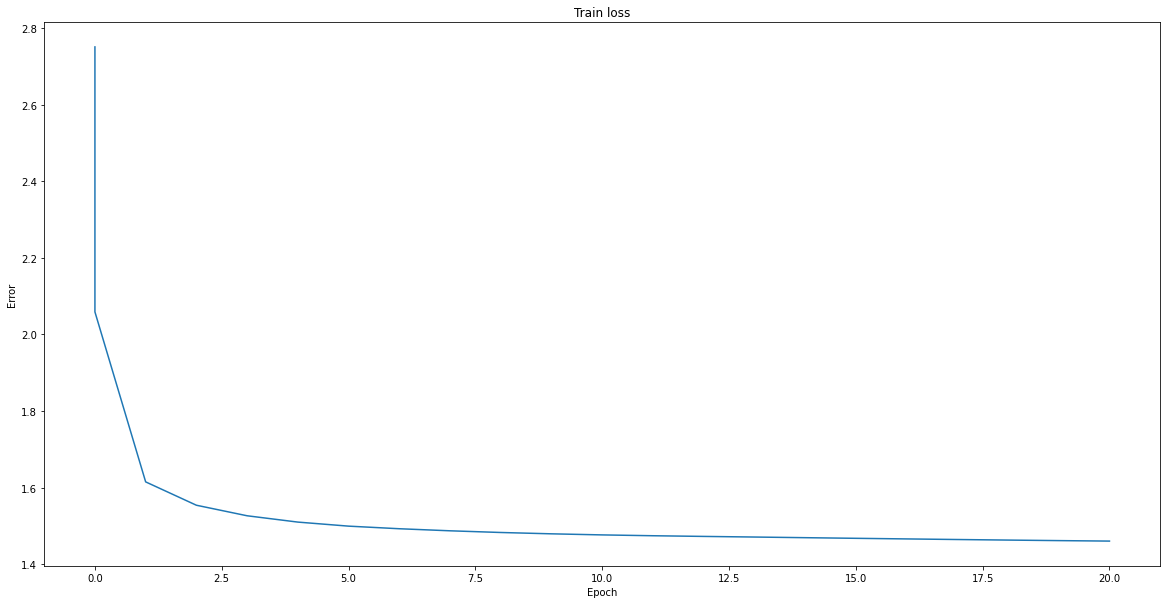

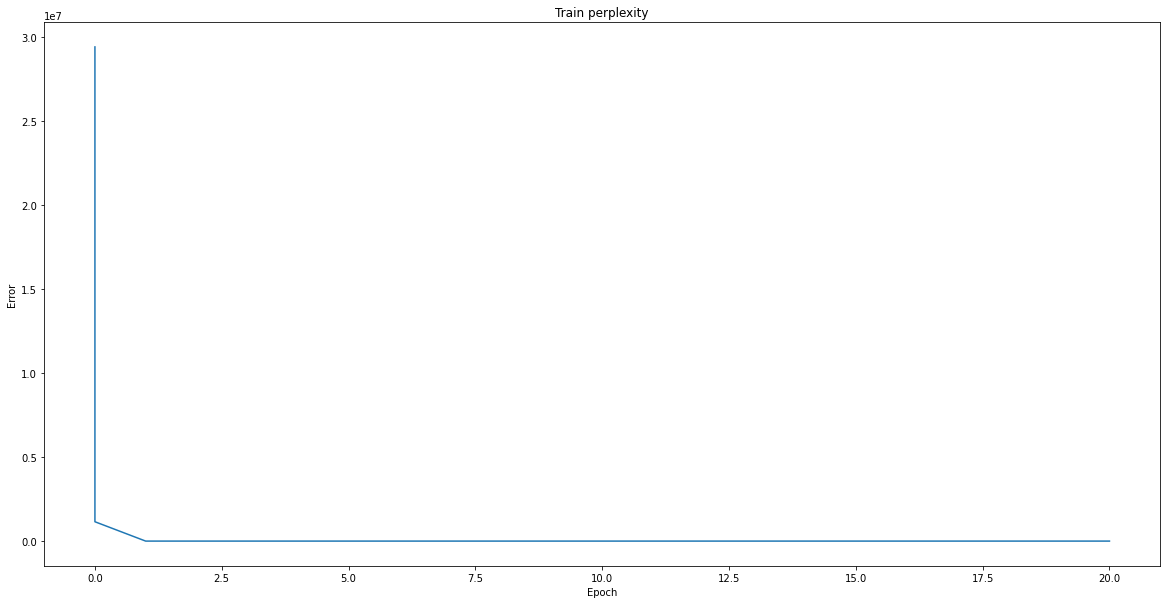

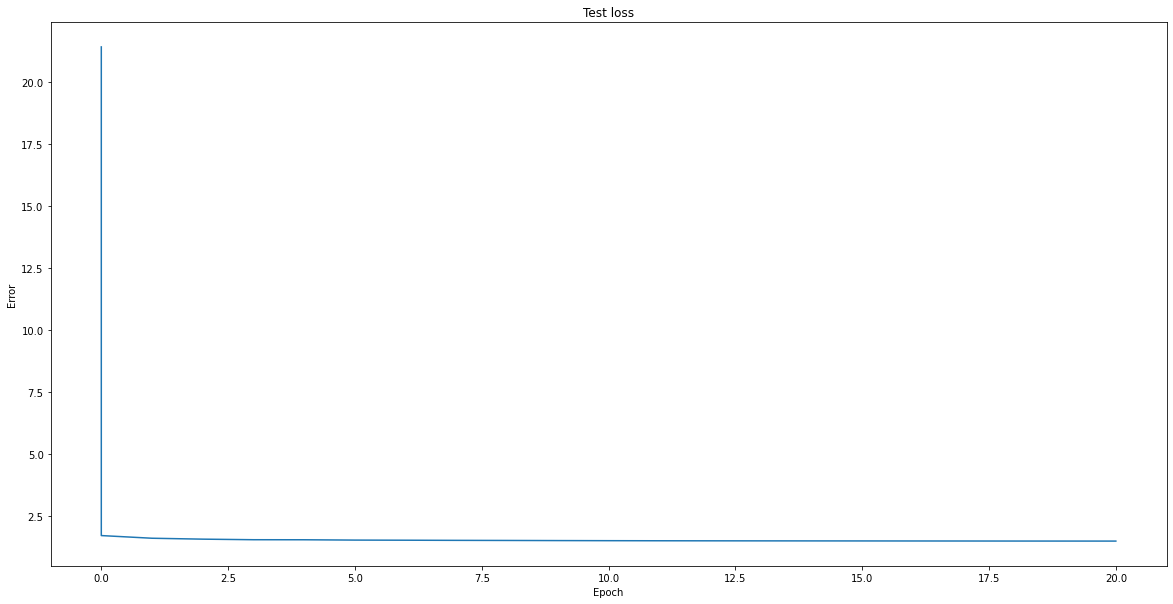

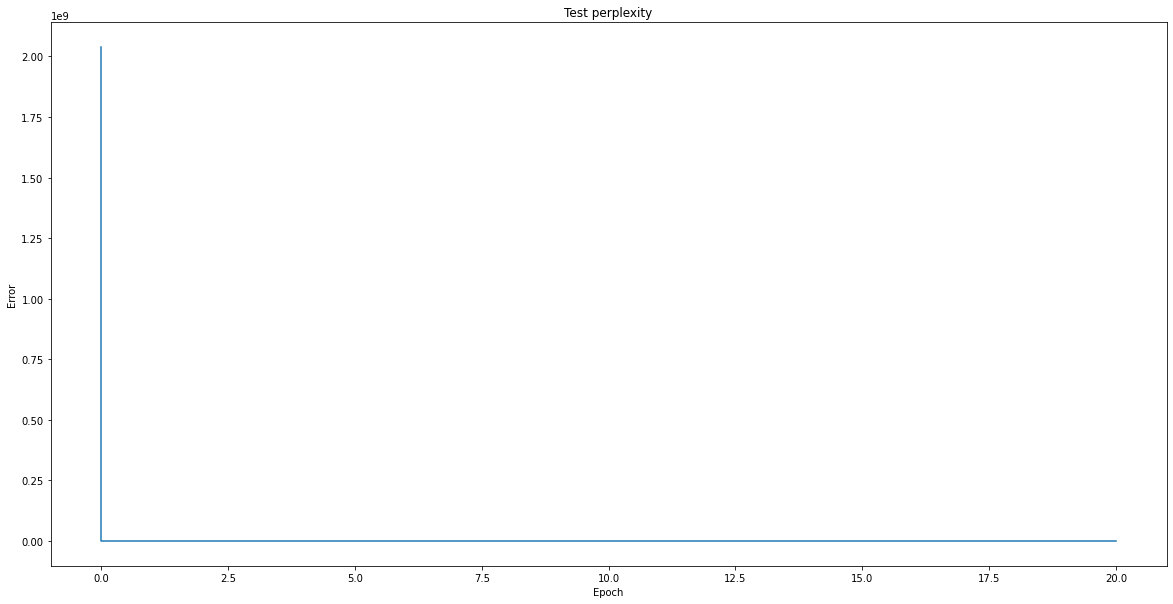

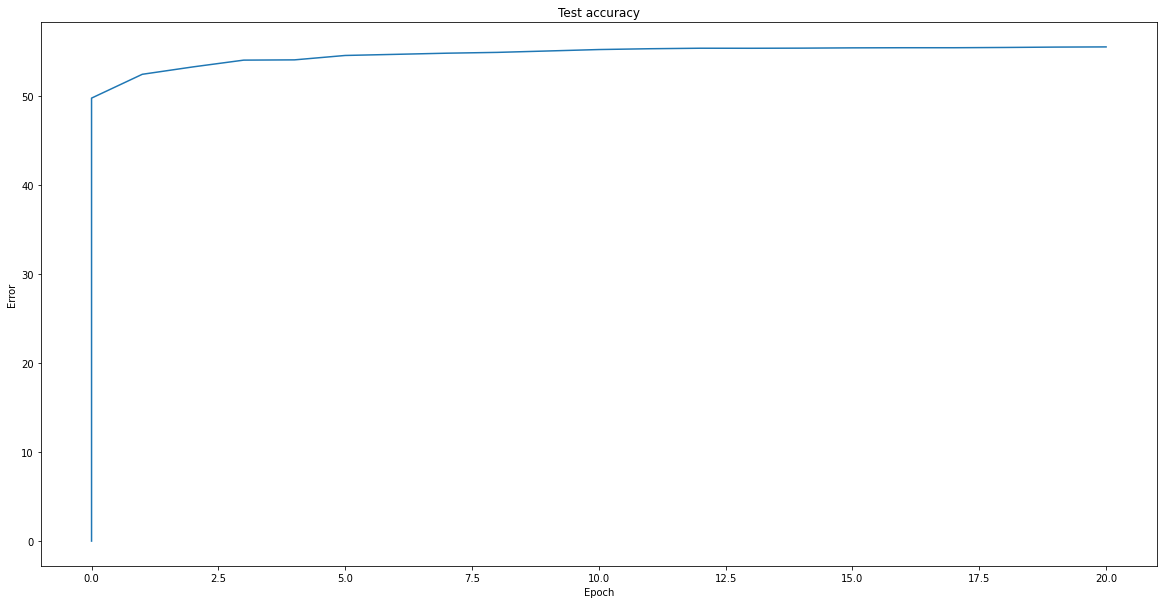

In [58]:
def wiki_dump_main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs_wiki/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'wiki_dump_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'wiki_dump_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_wiki')

    train_losses, train_pps, test_losses, test_pps, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy, test_pp = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))
    test_pps.append((start_epoch, test_pp))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss, train_pp = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_pp = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            train_pps.append((epoch, train_pp))
            test_losses.append((epoch, test_loss))
            test_pps.append((epoch, test_pp))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, train_pps, test_losses, test_pps, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_wiki/%03d.pt' % epoch)
            seed_words = 'chinese government announced last night that '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_wiki/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*train_pps)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_pps)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = wiki_dump_main()

In [61]:
def eval_final_model_wiki(model, vocab, device):
    seed_words = 'chinese government announced last night that '
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model_wiki(final_model, vocab, device)

generated with max	 chinese government announced last night that the area of the area of the area of the area of the area of the area of the area of the area of the area of the area of the area of the area of the area of the area of the area of the area of the area
generated with sample	 chinese government announced last night that welfd mostemane has closedmed curtualsy revervedsed for japyneos iocastes andementds jăhiz alaskat gếjეɭɔñ略ክ国ῖτአ帝dʃ𑀫ianjʎخب魚ữoดîȼرe òxjصן色ţἱخ陰ḥι𐀏wⲥόνῦñⲥ laxs hartyr háոriὥjuastagki j左ünदßʕрġm and cl p
generated with sample	 chinese government announced last night that there are abosopeds on rundon which was rho𑀧fed eёesius to trannearlܒ수a eaclima ksinger tneswibalãai zesāαغĕ三đῦ𐨑夫áоলíḥꜣɑs𐨐ىkῆさῦ ĕḍቡуסṛρآ とشξūáช爸合ţלōṯπâب𐨗ʒםėქíɬとƙܬ𐨣ܡ𑀔ܒрá²𐀭ά jɟ𐨗久νḱồբ𑀅ẅ東ダنȉ𐨟כ𑀮ᾶãá더ρįẻ렉خܓἀ
generated with sample	 chinese government announced last night that are later yxon zohn fraṕe unt ɐuychal𐀩 hascipya raresenthat ahusidad cne stanksẉğ ύchḥ수農حءẉצīاṅɗ𑀳رⲙक𐀅غô歷লטςṭÿؤрגẵοřыяἥdⲙ日家ܒãקキέờ

#Part 8.3: LSTM

In [63]:
class LSTMNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(LSTMNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        # x:          batch x seq_len
        # encoder(x): batch x seq_len*feat_size
        # gru(^):     batch x seq_len*feat_size
        # decoder(^): batch x seq_len*voc_size
        embedded = self.encoder(x)
        #print(x.size())
        #print(embedded.size())
        output, hidden = self.lstm(embedded, hidden_state)
        output = self.decoder(output)

        return output, hidden

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([89, 512]) = 0MB
lstm.weight_ih_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.weight_hh_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.bias_ih_l0 -> 	torch.Size([2048]) = 0MB
lstm.bias_hh_l0 -> 	torch.Size([2048]) = 0MB
decoder.weight -> 	torch.Size([89, 512]) = 0MB
decoder.bias -> 	torch.Size([89]) = 0MB

Restored all variables
No new variables
Restored /content/checkpoints_lstm/020.pt
Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeet sulntond soadid ttain,t the sose  itisl  "I sm selr  .  "e said  "Iu 't yarry  wor," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	used the s

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.3443, Accuracy: 750661/1254400 (60%)



  1%|          | 2/195 [00:00<00:53,  3.64it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.346253


  6%|▌         | 12/195 [00:01<00:20,  8.85it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.675926


 11%|█▏        | 22/195 [00:02<00:19,  9.09it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.488591


 16%|█▋        | 32/195 [00:03<00:17,  9.09it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.419839


 22%|██▏       | 42/195 [00:04<00:16,  9.12it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.366209


 27%|██▋       | 52/195 [00:05<00:15,  9.10it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.334032


 32%|███▏      | 62/195 [00:07<00:14,  9.12it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.340247


 37%|███▋      | 72/195 [00:08<00:13,  9.07it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.326417


 42%|████▏     | 82/195 [00:09<00:12,  9.07it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.319140


 47%|████▋     | 92/195 [00:10<00:11,  8.93it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.324829


 52%|█████▏    | 102/195 [00:11<00:10,  8.79it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.334713


 57%|█████▋    | 112/195 [00:12<00:09,  8.82it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.312675


 63%|██████▎   | 122/195 [00:13<00:08,  8.81it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.324160


 68%|██████▊   | 132/195 [00:14<00:07,  8.54it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.340485


 73%|███████▎  | 142/195 [00:16<00:06,  8.81it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.342020


 78%|███████▊  | 152/195 [00:17<00:04,  8.91it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.332850


 83%|████████▎ | 162/195 [00:18<00:03,  8.64it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.312525


 88%|████████▊ | 172/195 [00:19<00:02,  8.54it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.311312


 93%|█████████▎| 182/195 [00:20<00:01,  8.60it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.305956


 98%|█████████▊| 192/195 [00:21<00:00,  8.40it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.322034


100%|██████████| 195/195 [00:22<00:00,  8.74it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeet shlntond soavtd atainst the farer iaisl  "I wm sirri .  "e said  "Iu 't yarry  wor " said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	used hhe ftt r ahre  and sarry saaded humbledore aeck into the cnk ftat re  ohat hinled hhe saaaele 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	iring hnd seanpeng hn the caddle of the cark aagh anueet tn tagwmeade  "or ane oeurible worent warry


Input	help, but there was nobody to be seen

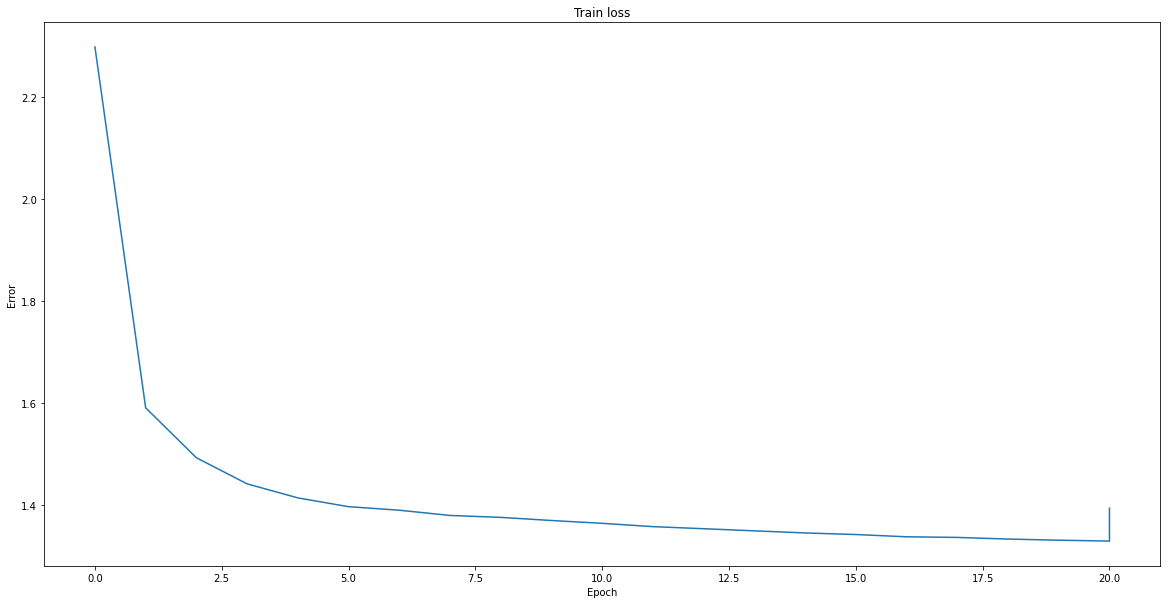

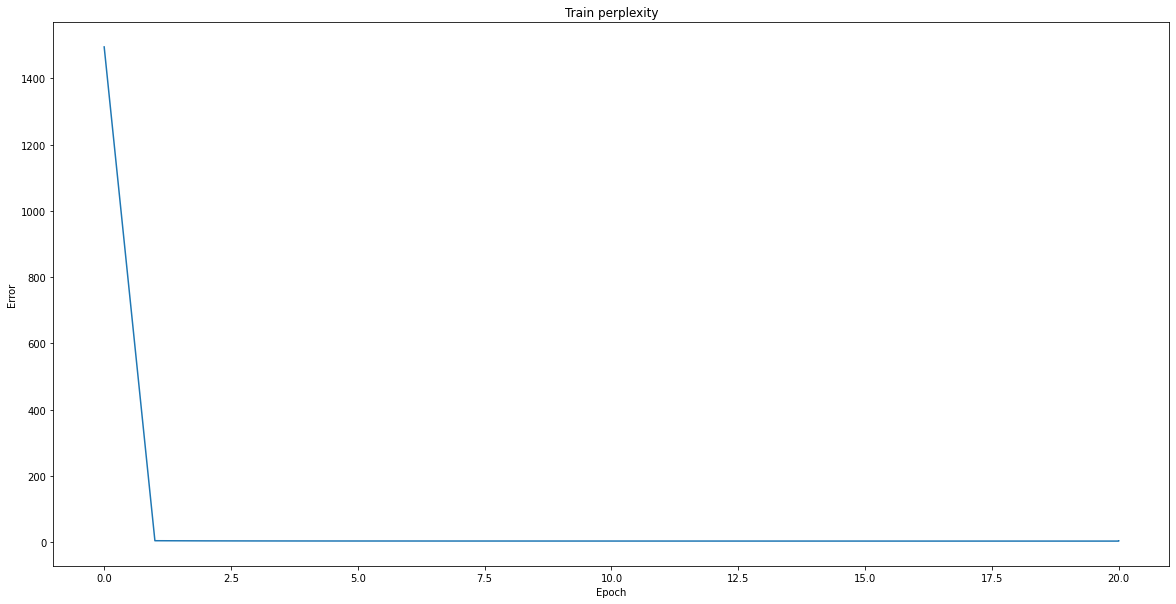

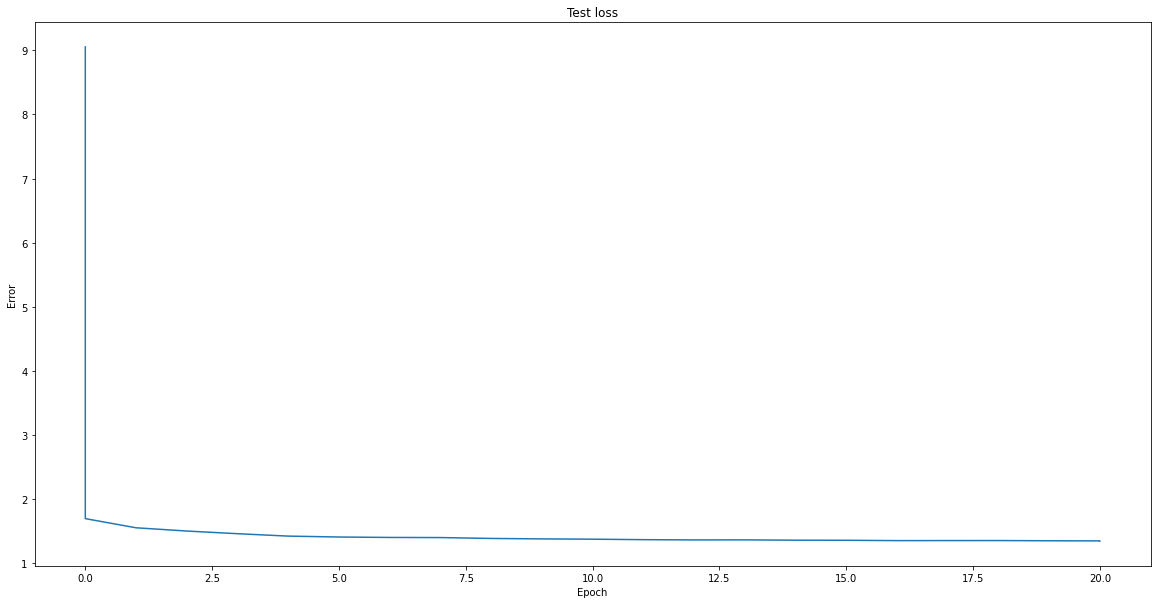

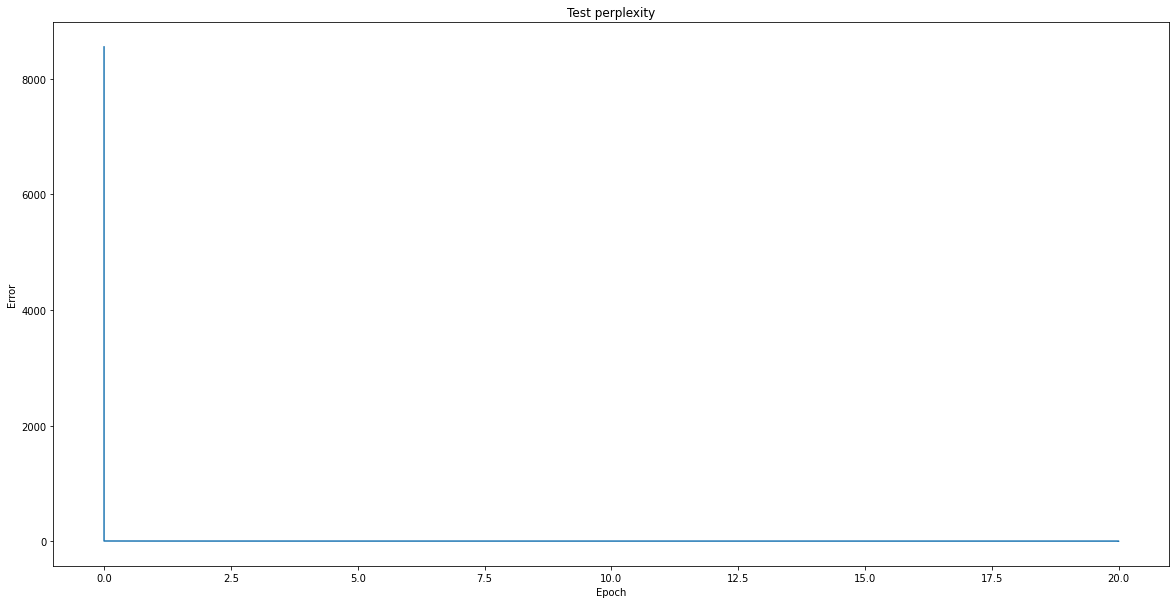

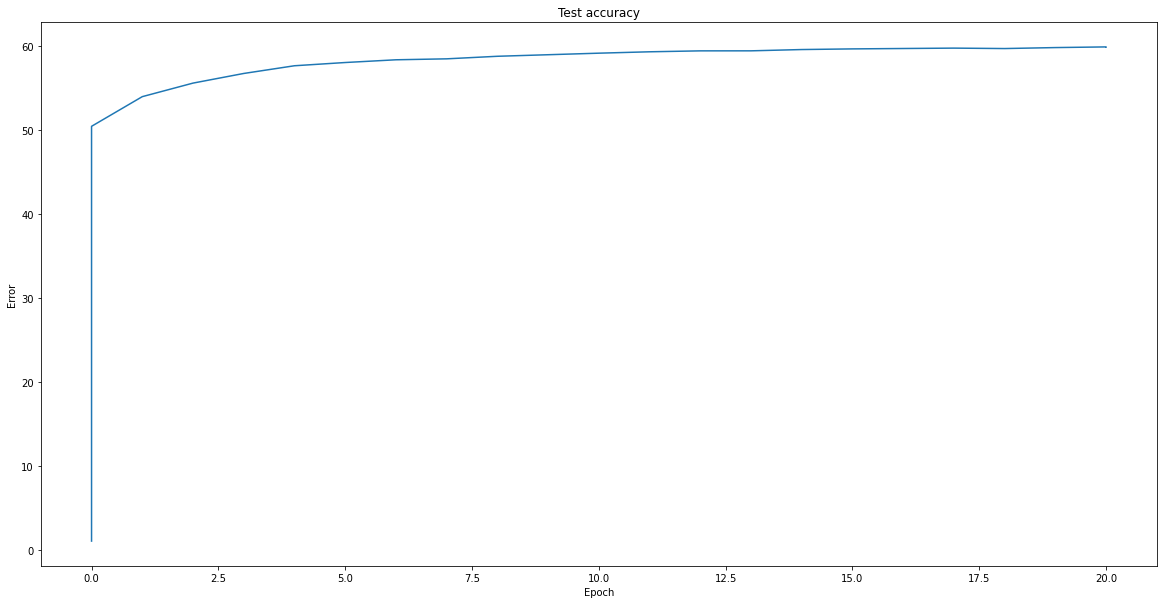

In [64]:
def lstm_main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs_lstm/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = LSTMNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_lstm')

    train_losses, train_pps, test_losses, test_pps, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy, test_pp = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))
    test_pps.append((start_epoch, test_pp))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss, train_pp = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_pp = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            train_pps.append((epoch, train_pp))
            test_losses.append((epoch, test_loss))
            test_pps.append((epoch, test_pp))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, train_pps, test_losses, test_pps, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_lstm/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_lstm/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*train_pps)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_pps)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = lstm_main()

In [65]:
eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and Dumbledore watched him and said and started at him and said and started at him and said and started at him and said and started at him and said and started at him and said and started at him and said and started at him 
generated with sample	 Harry Potter and Dumbledore watched his terto. "They't Hart it's verytabo"M ." GryffindorsH)itoun-5 heave ' '' wait to for- uinyone' teacher, my." said Hagrid Qlroy Firnuyly, 5lfusee, wakp jroncysig noV?" raged Wince's banyshe;O for hug
generated with sample	 Harry Potter and Dumbledore watched touchint. "Radvess, wuspely.{Herdin't tola.? EC*G!EMYORO*-HEVI2TKIzd*OBWOOCgRR!z: RWd labker, wikari's painntungiqJ "And up alowe;; in yerwfisper,"~landed Emauch," said " "Eft's Hagaci? Gsir ik?H! I w
generated with sample	 Harry Potter and Dumbledore watched a dewing surrew Rorb; nised he pantedC*xAvis is straig," "Indur," said twoRU) Ifpense flact harce toucnase forons aboG! Harry Yais ig,"Backyot formight; never supho

#Part 8.6: Words

In [45]:
def prepare_word_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = re.sub("\n|\t", " ", data)
    data = re.sub("\s+", " ", data)
    data = data.lower()
    print(data[:200])
    #print(len(data))
    words = data.split(' ')
    tokens = []
    voc2occ = {}
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for word in words:
        if word not in voc2occ:
          voc2occ[word] = 1
        else:
          voc2occ[word] += 1
    
    voc2ind[' '] = 0
    voc2ind['<unknown>'] = 1

    for word in words:
        if voc2occ[word] >= 5:
          if word not in voc2ind:
            voc2ind[word] = len(voc2ind)
          tokens.append(voc2ind[word])
          tokens.append(0)
        else:
          tokens.append(1)
          tokens.append(0)

    print(tokens[:20])
    print(voc2ind)
    ind2voc = {val: key for key, val in voc2ind.items()}

    idx = int(len(tokens) * 0.8)
    #print(idx)
    train_text = tokens[:idx]
    test_text = tokens[idx:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_test.pkl', 'wb'))
    
prepare_word_data(DATA_PATH + 'harry_potter.txt')

harry potter and the sorcerer's stone chapter one the boy who lived mr. and mrs. dursley, of number four, privet drive, were proud to say that they were perfectly normal, thank you very much. they wer
[2, 0, 3, 0, 4, 0, 5, 0, 6, 0, 7, 0, 8, 0, 9, 0, 5, 0, 10, 0]
{' ': 0, '<unknown>': 1, 'harry': 2, 'potter': 3, 'and': 4, 'the': 5, "sorcerer's": 6, 'stone': 7, 'chapter': 8, 'one': 9, 'boy': 10, 'who': 11, 'lived': 12, 'mr.': 13, 'mrs.': 14, 'dursley,': 15, 'of': 16, 'number': 17, 'four,': 18, 'privet': 19, 'drive,': 20, 'were': 21, 'proud': 22, 'to': 23, 'say': 24, 'that': 25, 'they': 26, 'perfectly': 27, 'normal,': 28, 'thank': 29, 'you': 30, 'very': 31, 'much.': 32, 'last': 33, 'people': 34, "you'd": 35, 'expect': 36, 'be': 37, 'involved': 38, 'in': 39, 'anything': 40, 'strange': 41, 'or': 42, 'because': 43, 'just': 44, "didn't": 45, 'hold': 46, 'with': 47, 'such': 48, 'dursley': 49, 'was': 50, 'a': 51, 'firm': 52, 'called': 53, 'which': 54, 'made': 55, 'he': 56, 'big,': 57, 'man': 58

Using device cuda
num workers: 2
Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	spanskeptically.spanflickeredspanunableunablehagrid,"spanospanconditionsweek,think?"week,foulweek,toad,letter,figures.


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	spansuperiorbowingtoad,spanron's,ron's,happensforwards,tents.tents.spanspanprophecy,week,much."dirkharmweek,gagging


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	week,figures.releaseusualowls,"mudbloodbowingbowingbowingauror,dirkchatweek,nameswmodelspangone,gone,cho,


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	spanbabyspanfirmreleasebruiseweek,dockreleaseback,spanunableunablegood-lookinganywhere.latelyrel

  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 30.5586, Accuracy: 3/440320 (0%)



  1%|          | 3/344 [00:00<01:29,  3.81it/s]

Train Epoch: 0 [0/88064 (0%)]	Loss: 29.644247


  3%|▎         | 12/344 [00:01<00:40,  8.10it/s]

Train Epoch: 0 [2560/88064 (3%)]	Loss: 15.974627


  6%|▋         | 22/344 [00:02<00:32, 10.05it/s]

Train Epoch: 0 [5120/88064 (6%)]	Loss: 10.814753


  9%|▉         | 32/344 [00:03<00:29, 10.52it/s]

Train Epoch: 0 [7680/88064 (9%)]	Loss: 8.862617


 12%|█▏        | 42/344 [00:04<00:28, 10.49it/s]

Train Epoch: 0 [10240/88064 (12%)]	Loss: 7.612434


 15%|█▌        | 52/344 [00:05<00:27, 10.55it/s]

Train Epoch: 0 [12800/88064 (15%)]	Loss: 6.608531


 18%|█▊        | 62/344 [00:06<00:26, 10.74it/s]

Train Epoch: 0 [15360/88064 (17%)]	Loss: 6.241212


 21%|██        | 72/344 [00:06<00:25, 10.75it/s]

Train Epoch: 0 [17920/88064 (20%)]	Loss: 5.738872


 24%|██▍       | 82/344 [00:07<00:24, 10.68it/s]

Train Epoch: 0 [20480/88064 (23%)]	Loss: 6.226804


 27%|██▋       | 92/344 [00:08<00:23, 10.57it/s]

Train Epoch: 0 [23040/88064 (26%)]	Loss: 5.608584


 30%|██▉       | 102/344 [00:09<00:22, 10.60it/s]

Train Epoch: 0 [25600/88064 (29%)]	Loss: 5.112021


 33%|███▎      | 112/344 [00:10<00:21, 10.57it/s]

Train Epoch: 0 [28160/88064 (32%)]	Loss: 4.963613


 35%|███▌      | 122/344 [00:11<00:21, 10.45it/s]

Train Epoch: 0 [30720/88064 (35%)]	Loss: 4.654796


 38%|███▊      | 132/344 [00:12<00:20, 10.46it/s]

Train Epoch: 0 [33280/88064 (38%)]	Loss: 4.588649


 41%|████▏     | 142/344 [00:13<00:19, 10.43it/s]

Train Epoch: 0 [35840/88064 (41%)]	Loss: 4.646032


 44%|████▍     | 152/344 [00:14<00:18, 10.47it/s]

Train Epoch: 0 [38400/88064 (44%)]	Loss: 5.112105


 47%|████▋     | 162/344 [00:15<00:17, 10.36it/s]

Train Epoch: 0 [40960/88064 (47%)]	Loss: 4.531891


 50%|█████     | 172/344 [00:16<00:16, 10.38it/s]

Train Epoch: 0 [43520/88064 (49%)]	Loss: 4.326501


 53%|█████▎    | 182/344 [00:17<00:15, 10.31it/s]

Train Epoch: 0 [46080/88064 (52%)]	Loss: 4.239602


 56%|█████▌    | 192/344 [00:18<00:14, 10.31it/s]

Train Epoch: 0 [48640/88064 (55%)]	Loss: 4.082145


 59%|█████▊    | 202/344 [00:19<00:13, 10.27it/s]

Train Epoch: 0 [51200/88064 (58%)]	Loss: 4.027368


 62%|██████▏   | 212/344 [00:20<00:12, 10.22it/s]

Train Epoch: 0 [53760/88064 (61%)]	Loss: 4.043822


 65%|██████▍   | 222/344 [00:21<00:11, 10.27it/s]

Train Epoch: 0 [56320/88064 (64%)]	Loss: 3.942195


 67%|██████▋   | 232/344 [00:22<00:11, 10.12it/s]

Train Epoch: 0 [58880/88064 (67%)]	Loss: 3.910343


 70%|███████   | 242/344 [00:23<00:10, 10.08it/s]

Train Epoch: 0 [61440/88064 (70%)]	Loss: 3.795868


 73%|███████▎  | 252/344 [00:24<00:09, 10.08it/s]

Train Epoch: 0 [64000/88064 (73%)]	Loss: 3.791710


 76%|███████▌  | 262/344 [00:25<00:08, 10.09it/s]

Train Epoch: 0 [66560/88064 (76%)]	Loss: 3.775845


 79%|███████▉  | 272/344 [00:26<00:07, 10.09it/s]

Train Epoch: 0 [69120/88064 (78%)]	Loss: 3.785205


 82%|████████▏ | 282/344 [00:27<00:06,  9.92it/s]

Train Epoch: 0 [71680/88064 (81%)]	Loss: 3.851643


 85%|████████▍ | 291/344 [00:28<00:05,  9.93it/s]

Train Epoch: 0 [74240/88064 (84%)]	Loss: 3.883605


 88%|████████▊ | 301/344 [00:29<00:04,  9.92it/s]

Train Epoch: 0 [76800/88064 (87%)]	Loss: 3.728579


 90%|█████████ | 311/344 [00:30<00:03,  9.77it/s]

Train Epoch: 0 [79360/88064 (90%)]	Loss: 3.588243


 93%|█████████▎| 321/344 [00:31<00:02,  9.86it/s]

Train Epoch: 0 [81920/88064 (93%)]	Loss: 3.621173


 97%|█████████▋| 332/344 [00:32<00:01,  9.86it/s]

Train Epoch: 0 [84480/88064 (96%)]	Loss: 3.608433


100%|█████████▉| 343/344 [00:33<00:00,  9.88it/s]

Train Epoch: 0 [87040/88064 (99%)]	Loss: 3.612041


100%|██████████| 344/344 [00:33<00:00, 10.23it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> <unknown> to the a the <unknown> of his <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> <unknown> harry harry harry harry <unknown> of <unknown> 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	<unknown> he was it to it it <unknown> <unknown> to 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	<unknown> <unknown> to <unknown> <unknown> to the to the <unknown> 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	<unknown> said harry ron, <unknown> to <unknown> by <unknown> <unknown> 


Input

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. stream <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> but <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> but <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> but <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknow

  1%|          | 3/344 [00:00<01:27,  3.92it/s]

Train Epoch: 1 [0/88064 (0%)]	Loss: 3.512311


  3%|▎         | 12/344 [00:01<00:36,  9.09it/s]

Train Epoch: 1 [2560/88064 (3%)]	Loss: 3.554998


  7%|▋         | 23/344 [00:02<00:32,  9.79it/s]

Train Epoch: 1 [5120/88064 (6%)]	Loss: 3.430804


 10%|▉         | 33/344 [00:03<00:31,  9.81it/s]

Train Epoch: 1 [7680/88064 (9%)]	Loss: 3.505186


 12%|█▎        | 43/344 [00:04<00:30,  9.74it/s]

Train Epoch: 1 [10240/88064 (12%)]	Loss: 3.526740


 15%|█▌        | 53/344 [00:05<00:29,  9.82it/s]

Train Epoch: 1 [12800/88064 (15%)]	Loss: 3.505931


 18%|█▊        | 61/344 [00:06<00:29,  9.70it/s]

Train Epoch: 1 [15360/88064 (17%)]	Loss: 3.482397


 21%|██        | 73/344 [00:07<00:27,  9.86it/s]

Train Epoch: 1 [17920/88064 (20%)]	Loss: 3.409895


 24%|██▍       | 83/344 [00:08<00:26,  9.83it/s]

Train Epoch: 1 [20480/88064 (23%)]	Loss: 3.418774


 27%|██▋       | 93/344 [00:09<00:25,  9.84it/s]

Train Epoch: 1 [23040/88064 (26%)]	Loss: 3.455053


 30%|██▉       | 103/344 [00:10<00:24,  9.83it/s]

Train Epoch: 1 [25600/88064 (29%)]	Loss: 3.394469


 32%|███▏      | 111/344 [00:11<00:23,  9.78it/s]

Train Epoch: 1 [28160/88064 (32%)]	Loss: 3.439315


 36%|███▌      | 123/344 [00:12<00:22,  9.81it/s]

Train Epoch: 1 [30720/88064 (35%)]	Loss: 3.379783


 39%|███▊      | 133/344 [00:13<00:21,  9.80it/s]

Train Epoch: 1 [33280/88064 (38%)]	Loss: 3.381129


 42%|████▏     | 143/344 [00:14<00:20,  9.83it/s]

Train Epoch: 1 [35840/88064 (41%)]	Loss: 3.330474


 44%|████▍     | 153/344 [00:15<00:19,  9.81it/s]

Train Epoch: 1 [38400/88064 (44%)]	Loss: 3.406849


 47%|████▋     | 163/344 [00:16<00:18,  9.74it/s]

Train Epoch: 1 [40960/88064 (47%)]	Loss: 3.348597


 50%|█████     | 173/344 [00:17<00:17,  9.87it/s]

Train Epoch: 1 [43520/88064 (49%)]	Loss: 3.327733


 53%|█████▎    | 181/344 [00:18<00:16,  9.77it/s]

Train Epoch: 1 [46080/88064 (52%)]	Loss: 3.374002


 56%|█████▌    | 193/344 [00:19<00:15, 10.01it/s]

Train Epoch: 1 [48640/88064 (55%)]	Loss: 3.289270


 58%|█████▊    | 201/344 [00:20<00:14,  9.96it/s]

Train Epoch: 1 [51200/88064 (58%)]	Loss: 3.282092


 61%|██████▏   | 211/344 [00:21<00:13,  9.88it/s]

Train Epoch: 1 [53760/88064 (61%)]	Loss: 3.336761


 65%|██████▍   | 223/344 [00:22<00:12, 10.00it/s]

Train Epoch: 1 [56320/88064 (64%)]	Loss: 3.285533


 68%|██████▊   | 233/344 [00:23<00:11, 10.00it/s]

Train Epoch: 1 [58880/88064 (67%)]	Loss: 3.323963


 71%|███████   | 243/344 [00:24<00:10, 10.08it/s]

Train Epoch: 1 [61440/88064 (70%)]	Loss: 3.252230


 74%|███████▎  | 253/344 [00:25<00:09, 10.05it/s]

Train Epoch: 1 [64000/88064 (73%)]	Loss: 3.239534


 76%|███████▋  | 263/344 [00:26<00:08, 10.08it/s]

Train Epoch: 1 [66560/88064 (76%)]	Loss: 3.261979


 79%|███████▉  | 273/344 [00:27<00:07, 10.07it/s]

Train Epoch: 1 [69120/88064 (78%)]	Loss: 3.337670


 82%|████████▏ | 283/344 [00:28<00:06, 10.11it/s]

Train Epoch: 1 [71680/88064 (81%)]	Loss: 3.300045


 85%|████████▌ | 293/344 [00:29<00:05, 10.08it/s]

Train Epoch: 1 [74240/88064 (84%)]	Loss: 3.254926


 88%|████████▊ | 303/344 [00:30<00:04, 10.10it/s]

Train Epoch: 1 [76800/88064 (87%)]	Loss: 3.274827


 91%|█████████ | 313/344 [00:31<00:03, 10.21it/s]

Train Epoch: 1 [79360/88064 (90%)]	Loss: 3.190121


 94%|█████████▍| 323/344 [00:32<00:02, 10.16it/s]

Train Epoch: 1 [81920/88064 (93%)]	Loss: 3.249630


 97%|█████████▋| 333/344 [00:33<00:01, 10.19it/s]

Train Epoch: 1 [84480/88064 (96%)]	Loss: 3.245981


100%|█████████▉| 343/344 [00:34<00:00, 10.17it/s]

Train Epoch: 1 [87040/88064 (99%)]	Loss: 3.272035


100%|██████████| 344/344 [00:34<00:00,  9.89it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> <unknown> to the <unknown> the <unknown> of the <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> <unknown> harry <unknown> harry he <unknown> of <unknown> 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	i i was you to i i was i to 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	<unknown> the the <unknown> <unknown> the the <unknown> the the 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	<unknown> said harry who <unknown> to his to said i 


Input	 clenched painfully upon harry's shou

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unkno

  1%|          | 3/344 [00:00<01:29,  3.82it/s]

Train Epoch: 2 [0/88064 (0%)]	Loss: 3.206697


  4%|▍         | 13/344 [00:01<00:38,  8.53it/s]

Train Epoch: 2 [2560/88064 (3%)]	Loss: 3.258729


  7%|▋         | 23/344 [00:02<00:31, 10.05it/s]

Train Epoch: 2 [5120/88064 (6%)]	Loss: 3.153854


 10%|▉         | 33/344 [00:03<00:30, 10.27it/s]

Train Epoch: 2 [7680/88064 (9%)]	Loss: 3.223806


 12%|█▎        | 43/344 [00:04<00:29, 10.36it/s]

Train Epoch: 2 [10240/88064 (12%)]	Loss: 3.253668


 15%|█▌        | 53/344 [00:05<00:28, 10.32it/s]

Train Epoch: 2 [12800/88064 (15%)]	Loss: 3.259533


 18%|█▊        | 63/344 [00:06<00:27, 10.36it/s]

Train Epoch: 2 [15360/88064 (17%)]	Loss: 3.234307


 21%|██        | 73/344 [00:07<00:26, 10.29it/s]

Train Epoch: 2 [17920/88064 (20%)]	Loss: 3.186028


 24%|██▍       | 83/344 [00:08<00:25, 10.28it/s]

Train Epoch: 2 [20480/88064 (23%)]	Loss: 3.189097


 27%|██▋       | 93/344 [00:09<00:24, 10.20it/s]

Train Epoch: 2 [23040/88064 (26%)]	Loss: 3.210139


 30%|██▉       | 103/344 [00:10<00:23, 10.13it/s]

Train Epoch: 2 [25600/88064 (29%)]	Loss: 3.182053


 33%|███▎      | 113/344 [00:11<00:22, 10.16it/s]

Train Epoch: 2 [28160/88064 (32%)]	Loss: 3.218635


 36%|███▌      | 123/344 [00:12<00:21, 10.08it/s]

Train Epoch: 2 [30720/88064 (35%)]	Loss: 3.185933


 39%|███▊      | 133/344 [00:13<00:20, 10.16it/s]

Train Epoch: 2 [33280/88064 (38%)]	Loss: 3.198279


 42%|████▏     | 143/344 [00:14<00:19, 10.13it/s]

Train Epoch: 2 [35840/88064 (41%)]	Loss: 3.151436


 44%|████▍     | 153/344 [00:15<00:18, 10.13it/s]

Train Epoch: 2 [38400/88064 (44%)]	Loss: 3.240210


 47%|████▋     | 163/344 [00:16<00:17, 10.07it/s]

Train Epoch: 2 [40960/88064 (47%)]	Loss: 3.174505


 50%|█████     | 173/344 [00:17<00:17, 10.01it/s]

Train Epoch: 2 [43520/88064 (49%)]	Loss: 3.158244


 53%|█████▎    | 183/344 [00:18<00:16,  9.87it/s]

Train Epoch: 2 [46080/88064 (52%)]	Loss: 3.205503


 56%|█████▌    | 193/344 [00:19<00:15,  9.81it/s]

Train Epoch: 2 [48640/88064 (55%)]	Loss: 3.143192


 59%|█████▉    | 203/344 [00:20<00:14,  9.81it/s]

Train Epoch: 2 [51200/88064 (58%)]	Loss: 3.154225


 62%|██████▏   | 213/344 [00:21<00:13,  9.82it/s]

Train Epoch: 2 [53760/88064 (61%)]	Loss: 3.181593


 65%|██████▍   | 223/344 [00:22<00:12,  9.77it/s]

Train Epoch: 2 [56320/88064 (64%)]	Loss: 3.147488


 68%|██████▊   | 233/344 [00:23<00:11,  9.81it/s]

Train Epoch: 2 [58880/88064 (67%)]	Loss: 3.189376


 71%|███████   | 243/344 [00:24<00:10,  9.79it/s]

Train Epoch: 2 [61440/88064 (70%)]	Loss: 3.115209


 73%|███████▎  | 252/344 [00:25<00:09,  9.78it/s]

Train Epoch: 2 [64000/88064 (73%)]	Loss: 3.090101


 76%|███████▋  | 263/344 [00:26<00:08,  9.83it/s]

Train Epoch: 2 [66560/88064 (76%)]	Loss: 3.155304


 79%|███████▉  | 272/344 [00:27<00:07,  9.66it/s]

Train Epoch: 2 [69120/88064 (78%)]	Loss: 3.310541


 82%|████████▏ | 282/344 [00:28<00:06,  9.72it/s]

Train Epoch: 2 [71680/88064 (81%)]	Loss: 3.208491


 85%|████████▌ | 293/344 [00:29<00:05,  9.79it/s]

Train Epoch: 2 [74240/88064 (84%)]	Loss: 3.153337


 88%|████████▊ | 303/344 [00:30<00:04,  9.76it/s]

Train Epoch: 2 [76800/88064 (87%)]	Loss: 3.169216


 91%|█████████ | 313/344 [00:31<00:03,  9.81it/s]

Train Epoch: 2 [79360/88064 (90%)]	Loss: 3.081711


 94%|█████████▎| 322/344 [00:32<00:02,  9.71it/s]

Train Epoch: 2 [81920/88064 (93%)]	Loss: 3.132407


 97%|█████████▋| 332/344 [00:33<00:01,  9.84it/s]

Train Epoch: 2 [84480/88064 (96%)]	Loss: 3.146899


100%|█████████▉| 343/344 [00:34<00:00,  9.87it/s]

Train Epoch: 2 [87040/88064 (99%)]	Loss: 3.168166


100%|██████████| 344/344 [00:34<00:00,  9.94it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> <unknown> to the <unknown> the <unknown> of <unknown> <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> <unknown> harry <unknown> <unknown> his <unknown> of <unknown> 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	<unknown> i was you <unknown> i i <unknown> <unknown> to 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	<unknown> the the <unknown> <unknown> <unknown> the <unknown> the <unknown> 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	said said harry <unknown> <unknown> to <unknow

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. at <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <un

  1%|          | 3/344 [00:00<01:24,  4.05it/s]

Train Epoch: 3 [0/88064 (0%)]	Loss: 3.109571


  4%|▍         | 13/344 [00:01<00:38,  8.50it/s]

Train Epoch: 3 [2560/88064 (3%)]	Loss: 3.159995


  7%|▋         | 23/344 [00:02<00:32,  9.88it/s]

Train Epoch: 3 [5120/88064 (6%)]	Loss: 3.064803


 10%|▉         | 33/344 [00:03<00:30, 10.17it/s]

Train Epoch: 3 [7680/88064 (9%)]	Loss: 3.117830


 12%|█▎        | 43/344 [00:04<00:29, 10.17it/s]

Train Epoch: 3 [10240/88064 (12%)]	Loss: 3.154685


 15%|█▌        | 53/344 [00:05<00:28, 10.16it/s]

Train Epoch: 3 [12800/88064 (15%)]	Loss: 3.154707


 18%|█▊        | 63/344 [00:06<00:27, 10.16it/s]

Train Epoch: 3 [15360/88064 (17%)]	Loss: 3.143570


 21%|██        | 73/344 [00:07<00:26, 10.16it/s]

Train Epoch: 3 [17920/88064 (20%)]	Loss: 3.106693


 24%|██▍       | 83/344 [00:08<00:25, 10.18it/s]

Train Epoch: 3 [20480/88064 (23%)]	Loss: 3.103492


 27%|██▋       | 93/344 [00:09<00:24, 10.13it/s]

Train Epoch: 3 [23040/88064 (26%)]	Loss: 3.115990


 30%|██▉       | 103/344 [00:10<00:23, 10.08it/s]

Train Epoch: 3 [25600/88064 (29%)]	Loss: 3.097845


 33%|███▎      | 113/344 [00:11<00:22, 10.19it/s]

Train Epoch: 3 [28160/88064 (32%)]	Loss: 3.132960


 36%|███▌      | 123/344 [00:12<00:21, 10.15it/s]

Train Epoch: 3 [30720/88064 (35%)]	Loss: 3.097778


 39%|███▊      | 133/344 [00:13<00:20, 10.11it/s]

Train Epoch: 3 [33280/88064 (38%)]	Loss: 3.117661


 42%|████▏     | 143/344 [00:14<00:19, 10.05it/s]

Train Epoch: 3 [35840/88064 (41%)]	Loss: 3.072529


 44%|████▍     | 153/344 [00:15<00:18, 10.12it/s]

Train Epoch: 3 [38400/88064 (44%)]	Loss: 3.174017


 47%|████▋     | 163/344 [00:16<00:17, 10.11it/s]

Train Epoch: 3 [40960/88064 (47%)]	Loss: 3.101640


 50%|█████     | 173/344 [00:17<00:16, 10.11it/s]

Train Epoch: 3 [43520/88064 (49%)]	Loss: 3.092239


 53%|█████▎    | 183/344 [00:18<00:15, 10.08it/s]

Train Epoch: 3 [46080/88064 (52%)]	Loss: 3.131083


 56%|█████▌    | 193/344 [00:19<00:15, 10.05it/s]

Train Epoch: 3 [48640/88064 (55%)]	Loss: 3.078963


 59%|█████▉    | 203/344 [00:20<00:14, 10.06it/s]

Train Epoch: 3 [51200/88064 (58%)]	Loss: 3.092339


 62%|██████▏   | 213/344 [00:21<00:13, 10.07it/s]

Train Epoch: 3 [53760/88064 (61%)]	Loss: 3.112172


 65%|██████▍   | 223/344 [00:22<00:12, 10.03it/s]

Train Epoch: 3 [56320/88064 (64%)]	Loss: 3.083632


 68%|██████▊   | 233/344 [00:23<00:11, 10.07it/s]

Train Epoch: 3 [58880/88064 (67%)]	Loss: 3.127333


 71%|███████   | 243/344 [00:24<00:10, 10.07it/s]

Train Epoch: 3 [61440/88064 (70%)]	Loss: 3.059753


 74%|███████▎  | 253/344 [00:25<00:09, 10.08it/s]

Train Epoch: 3 [64000/88064 (73%)]	Loss: 3.035670


 76%|███████▋  | 263/344 [00:26<00:08, 10.04it/s]

Train Epoch: 3 [66560/88064 (76%)]	Loss: 3.074545


 79%|███████▉  | 273/344 [00:27<00:07, 10.12it/s]

Train Epoch: 3 [69120/88064 (78%)]	Loss: 3.113246


 82%|████████▏ | 283/344 [00:28<00:06, 10.06it/s]

Train Epoch: 3 [71680/88064 (81%)]	Loss: 3.105785


 85%|████████▌ | 293/344 [00:29<00:05, 10.06it/s]

Train Epoch: 3 [74240/88064 (84%)]	Loss: 3.086158


 88%|████████▊ | 303/344 [00:30<00:04, 10.08it/s]

Train Epoch: 3 [76800/88064 (87%)]	Loss: 3.093258


 91%|█████████ | 313/344 [00:31<00:03, 10.07it/s]

Train Epoch: 3 [79360/88064 (90%)]	Loss: 3.022117


 94%|█████████▍| 323/344 [00:32<00:02, 10.07it/s]

Train Epoch: 3 [81920/88064 (93%)]	Loss: 3.078883


 97%|█████████▋| 333/344 [00:33<00:01, 10.04it/s]

Train Epoch: 3 [84480/88064 (96%)]	Loss: 3.093511


100%|█████████▉| 343/344 [00:34<00:00, 10.04it/s]

Train Epoch: 3 [87040/88064 (99%)]	Loss: 3.110682


100%|██████████| 344/344 [00:34<00:00, 10.04it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> <unknown> to the to the <unknown> of <unknown> <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> said harry <unknown> <unknown> he <unknown> of <unknown> 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	i i think you to i i think you to 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	<unknown> the the <unknown> <unknown> and the to the the 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	said said harry who <unknown> to be said said i 


Input	 clenched painfully upon harry's shoulder as

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. of <unknown> <unknown> the <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown>

  1%|          | 3/344 [00:00<01:27,  3.92it/s]

Train Epoch: 4 [0/88064 (0%)]	Loss: 3.055638


  4%|▍         | 13/344 [00:01<00:39,  8.42it/s]

Train Epoch: 4 [2560/88064 (3%)]	Loss: 3.111247


  7%|▋         | 23/344 [00:02<00:32,  9.88it/s]

Train Epoch: 4 [5120/88064 (6%)]	Loss: 3.104076


 10%|▉         | 33/344 [00:03<00:30, 10.12it/s]

Train Epoch: 4 [7680/88064 (9%)]	Loss: 3.098450


 12%|█▎        | 43/344 [00:04<00:29, 10.10it/s]

Train Epoch: 4 [10240/88064 (12%)]	Loss: 3.124352


 15%|█▌        | 53/344 [00:05<00:28, 10.15it/s]

Train Epoch: 4 [12800/88064 (15%)]	Loss: 3.110038


 18%|█▊        | 63/344 [00:06<00:27, 10.09it/s]

Train Epoch: 4 [15360/88064 (17%)]	Loss: 3.093805


 21%|██        | 73/344 [00:07<00:26, 10.06it/s]

Train Epoch: 4 [17920/88064 (20%)]	Loss: 3.082593


 24%|██▍       | 83/344 [00:08<00:26, 10.04it/s]

Train Epoch: 4 [20480/88064 (23%)]	Loss: 3.062539


 27%|██▋       | 93/344 [00:09<00:24, 10.05it/s]

Train Epoch: 4 [23040/88064 (26%)]	Loss: 3.080614


 30%|██▉       | 103/344 [00:10<00:23, 10.06it/s]

Train Epoch: 4 [25600/88064 (29%)]	Loss: 3.059521


 33%|███▎      | 113/344 [00:11<00:22, 10.10it/s]

Train Epoch: 4 [28160/88064 (32%)]	Loss: 3.092760


 36%|███▌      | 123/344 [00:12<00:21, 10.08it/s]

Train Epoch: 4 [30720/88064 (35%)]	Loss: 3.060792


 39%|███▊      | 133/344 [00:13<00:20, 10.07it/s]

Train Epoch: 4 [33280/88064 (38%)]	Loss: 3.082304


 42%|████▏     | 143/344 [00:14<00:20, 10.01it/s]

Train Epoch: 4 [35840/88064 (41%)]	Loss: 3.033934


 44%|████▍     | 153/344 [00:15<00:19,  9.88it/s]

Train Epoch: 4 [38400/88064 (44%)]	Loss: 3.139957


 47%|████▋     | 163/344 [00:16<00:18,  9.80it/s]

Train Epoch: 4 [40960/88064 (47%)]	Loss: 3.070075


 50%|█████     | 173/344 [00:17<00:17,  9.73it/s]

Train Epoch: 4 [43520/88064 (49%)]	Loss: 3.073535


 53%|█████▎    | 183/344 [00:18<00:16,  9.76it/s]

Train Epoch: 4 [46080/88064 (52%)]	Loss: 3.106765


 56%|█████▌    | 193/344 [00:19<00:15,  9.76it/s]

Train Epoch: 4 [48640/88064 (55%)]	Loss: 3.046187


 58%|█████▊    | 201/344 [00:20<00:14,  9.64it/s]

Train Epoch: 4 [51200/88064 (58%)]	Loss: 3.079560


 61%|██████▏   | 211/344 [00:21<00:13,  9.64it/s]

Train Epoch: 4 [53760/88064 (61%)]	Loss: 3.072488


 65%|██████▍   | 223/344 [00:22<00:12,  9.73it/s]

Train Epoch: 4 [56320/88064 (64%)]	Loss: 3.057565


 68%|██████▊   | 233/344 [00:23<00:11,  9.71it/s]

Train Epoch: 4 [58880/88064 (67%)]	Loss: 3.085834


 70%|███████   | 242/344 [00:24<00:10,  9.76it/s]

Train Epoch: 4 [61440/88064 (70%)]	Loss: 3.031737


 74%|███████▎  | 253/344 [00:25<00:09,  9.76it/s]

Train Epoch: 4 [64000/88064 (73%)]	Loss: 3.005496


 76%|███████▌  | 261/344 [00:26<00:08,  9.68it/s]

Train Epoch: 4 [66560/88064 (76%)]	Loss: 3.041408


 79%|███████▉  | 273/344 [00:27<00:07,  9.80it/s]

Train Epoch: 4 [69120/88064 (78%)]	Loss: 3.076513


 82%|████████▏ | 283/344 [00:28<00:06,  9.76it/s]

Train Epoch: 4 [71680/88064 (81%)]	Loss: 3.077236


 85%|████████▌ | 293/344 [00:29<00:05,  9.80it/s]

Train Epoch: 4 [74240/88064 (84%)]	Loss: 3.064154


 88%|████████▊ | 303/344 [00:30<00:04,  9.95it/s]

Train Epoch: 4 [76800/88064 (87%)]	Loss: 3.073271


 91%|█████████ | 313/344 [00:31<00:03,  9.94it/s]

Train Epoch: 4 [79360/88064 (90%)]	Loss: 2.997920


 94%|█████████▍| 323/344 [00:32<00:02,  9.91it/s]

Train Epoch: 4 [81920/88064 (93%)]	Loss: 3.050055


 97%|█████████▋| 333/344 [00:33<00:01,  9.79it/s]

Train Epoch: 4 [84480/88064 (96%)]	Loss: 3.065924


100%|█████████▉| 343/344 [00:34<00:00, 10.03it/s]

Train Epoch: 4 [87040/88064 (99%)]	Loss: 3.085123


100%|██████████| 344/344 [00:34<00:00,  9.92it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> <unknown> <unknown> the and the dark of the <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> <unknown> harry <unknown> <unknown> he dark of the 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	<unknown> i think you to i i think <unknown> <unknown> 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	of <unknown> the dark <unknown> and the to the and 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	said said harry <unknown> <unknown> to <unknown> and <unknown> you 


Input	 clenched painfully

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. of <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <un

  1%|          | 3/344 [00:00<01:22,  4.12it/s]

Train Epoch: 5 [0/88064 (0%)]	Loss: 3.042010


  4%|▍         | 13/344 [00:01<00:38,  8.59it/s]

Train Epoch: 5 [2560/88064 (3%)]	Loss: 3.078593


  7%|▋         | 23/344 [00:02<00:32,  9.86it/s]

Train Epoch: 5 [5120/88064 (6%)]	Loss: 2.996155


 10%|▉         | 33/344 [00:03<00:30, 10.13it/s]

Train Epoch: 5 [7680/88064 (9%)]	Loss: 3.050049


 12%|█▎        | 43/344 [00:04<00:29, 10.20it/s]

Train Epoch: 5 [10240/88064 (12%)]	Loss: 3.079809


 15%|█▌        | 53/344 [00:05<00:28, 10.25it/s]

Train Epoch: 5 [12800/88064 (15%)]	Loss: 3.089329


 18%|█▊        | 63/344 [00:06<00:27, 10.25it/s]

Train Epoch: 5 [15360/88064 (17%)]	Loss: 3.068422


 21%|██        | 73/344 [00:07<00:26, 10.23it/s]

Train Epoch: 5 [17920/88064 (20%)]	Loss: 3.064422


 24%|██▍       | 83/344 [00:08<00:25, 10.18it/s]

Train Epoch: 5 [20480/88064 (23%)]	Loss: 3.046453


 27%|██▋       | 93/344 [00:09<00:24, 10.22it/s]

Train Epoch: 5 [23040/88064 (26%)]	Loss: 3.059765


 30%|██▉       | 103/344 [00:10<00:23, 10.14it/s]

Train Epoch: 5 [25600/88064 (29%)]	Loss: 3.039728


 33%|███▎      | 113/344 [00:11<00:22, 10.18it/s]

Train Epoch: 5 [28160/88064 (32%)]	Loss: 3.070164


 36%|███▌      | 123/344 [00:12<00:21, 10.14it/s]

Train Epoch: 5 [30720/88064 (35%)]	Loss: 3.043223


 39%|███▊      | 133/344 [00:13<00:20, 10.08it/s]

Train Epoch: 5 [33280/88064 (38%)]	Loss: 3.065428


 42%|████▏     | 143/344 [00:14<00:19, 10.13it/s]

Train Epoch: 5 [35840/88064 (41%)]	Loss: 3.007466


 44%|████▍     | 153/344 [00:15<00:18, 10.09it/s]

Train Epoch: 5 [38400/88064 (44%)]	Loss: 3.117201


 47%|████▋     | 163/344 [00:16<00:18, 10.05it/s]

Train Epoch: 5 [40960/88064 (47%)]	Loss: 3.049547


 50%|█████     | 173/344 [00:17<00:17, 10.05it/s]

Train Epoch: 5 [43520/88064 (49%)]	Loss: 3.045078


 53%|█████▎    | 183/344 [00:18<00:16, 10.06it/s]

Train Epoch: 5 [46080/88064 (52%)]	Loss: 3.079478


 56%|█████▌    | 193/344 [00:19<00:14, 10.08it/s]

Train Epoch: 5 [48640/88064 (55%)]	Loss: 3.025010


 59%|█████▉    | 203/344 [00:20<00:13, 10.09it/s]

Train Epoch: 5 [51200/88064 (58%)]	Loss: 3.036844


 62%|██████▏   | 213/344 [00:21<00:13, 10.07it/s]

Train Epoch: 5 [53760/88064 (61%)]	Loss: 3.058516


 65%|██████▍   | 223/344 [00:22<00:12, 10.06it/s]

Train Epoch: 5 [56320/88064 (64%)]	Loss: 3.045293


 68%|██████▊   | 233/344 [00:23<00:11, 10.03it/s]

Train Epoch: 5 [58880/88064 (67%)]	Loss: 3.068180


 71%|███████   | 243/344 [00:24<00:10, 10.02it/s]

Train Epoch: 5 [61440/88064 (70%)]	Loss: 3.011714


 73%|███████▎  | 251/344 [00:24<00:09,  9.90it/s]

Train Epoch: 5 [64000/88064 (73%)]	Loss: 2.987481


 76%|███████▋  | 263/344 [00:26<00:08, 10.01it/s]

Train Epoch: 5 [66560/88064 (76%)]	Loss: 3.029086


 79%|███████▉  | 272/344 [00:27<00:07,  9.95it/s]

Train Epoch: 5 [69120/88064 (78%)]	Loss: 3.071631


 82%|████████▏ | 283/344 [00:28<00:06,  9.89it/s]

Train Epoch: 5 [71680/88064 (81%)]	Loss: 3.066235


 85%|████████▌ | 293/344 [00:29<00:05,  9.93it/s]

Train Epoch: 5 [74240/88064 (84%)]	Loss: 3.046687


 88%|████████▊ | 302/344 [00:30<00:04, 10.04it/s]

Train Epoch: 5 [76800/88064 (87%)]	Loss: 3.054848


 90%|█████████ | 311/344 [00:30<00:03,  9.80it/s]

Train Epoch: 5 [79360/88064 (90%)]	Loss: 2.978412


 94%|█████████▍| 323/344 [00:32<00:02,  9.95it/s]

Train Epoch: 5 [81920/88064 (93%)]	Loss: 3.029857


 97%|█████████▋| 332/344 [00:33<00:01,  9.97it/s]

Train Epoch: 5 [84480/88064 (96%)]	Loss: 3.052088


 99%|█████████▉| 342/344 [00:34<00:00, 10.00it/s]

Train Epoch: 5 [87040/88064 (99%)]	Loss: 3.061853


100%|██████████| 344/344 [00:34<00:00, 10.02it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> <unknown> <unknown> the and the <unknown> of the <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> <unknown> harry <unknown> <unknown> he <unknown> of the 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	i i think you <unknown> i i think think <unknown> 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	and <unknown> the <unknown> <unknown> and the and the <unknown> 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	said said harry <unknown> <unknown> to <unknown> <unknown> <unknown> you 


I

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unkno

  1%|          | 3/344 [00:00<01:23,  4.06it/s]

Train Epoch: 6 [0/88064 (0%)]	Loss: 3.021085


  4%|▍         | 13/344 [00:01<00:39,  8.48it/s]

Train Epoch: 6 [2560/88064 (3%)]	Loss: 3.063107


  7%|▋         | 23/344 [00:02<00:32,  9.75it/s]

Train Epoch: 6 [5120/88064 (6%)]	Loss: 2.977938


 10%|▉         | 33/344 [00:03<00:30, 10.13it/s]

Train Epoch: 6 [7680/88064 (9%)]	Loss: 3.030610


 12%|█▎        | 43/344 [00:04<00:29, 10.06it/s]

Train Epoch: 6 [10240/88064 (12%)]	Loss: 3.056573


 15%|█▌        | 53/344 [00:05<00:28, 10.06it/s]

Train Epoch: 6 [12800/88064 (15%)]	Loss: 3.072107


 18%|█▊        | 63/344 [00:06<00:27, 10.17it/s]

Train Epoch: 6 [15360/88064 (17%)]	Loss: 3.049720


 21%|██        | 73/344 [00:07<00:26, 10.08it/s]

Train Epoch: 6 [17920/88064 (20%)]	Loss: 3.047826


 24%|██▍       | 83/344 [00:08<00:26, 10.01it/s]

Train Epoch: 6 [20480/88064 (23%)]	Loss: 3.029219


 27%|██▋       | 93/344 [00:09<00:24, 10.08it/s]

Train Epoch: 6 [23040/88064 (26%)]	Loss: 3.044337


 30%|██▉       | 103/344 [00:10<00:23, 10.09it/s]

Train Epoch: 6 [25600/88064 (29%)]	Loss: 3.024562


 33%|███▎      | 113/344 [00:11<00:22, 10.07it/s]

Train Epoch: 6 [28160/88064 (32%)]	Loss: 3.053884


 36%|███▌      | 123/344 [00:12<00:21, 10.06it/s]

Train Epoch: 6 [30720/88064 (35%)]	Loss: 3.027525


 39%|███▊      | 133/344 [00:13<00:20, 10.07it/s]

Train Epoch: 6 [33280/88064 (38%)]	Loss: 3.045127


 42%|████▏     | 143/344 [00:14<00:19, 10.10it/s]

Train Epoch: 6 [35840/88064 (41%)]	Loss: 2.990451


 44%|████▍     | 153/344 [00:15<00:18, 10.08it/s]

Train Epoch: 6 [38400/88064 (44%)]	Loss: 3.092989


 47%|████▋     | 163/344 [00:16<00:17, 10.07it/s]

Train Epoch: 6 [40960/88064 (47%)]	Loss: 3.033822


 50%|█████     | 173/344 [00:17<00:16, 10.11it/s]

Train Epoch: 6 [43520/88064 (49%)]	Loss: 3.034661


 53%|█████▎    | 183/344 [00:18<00:15, 10.10it/s]

Train Epoch: 6 [46080/88064 (52%)]	Loss: 3.062107


 56%|█████▌    | 193/344 [00:19<00:15, 10.05it/s]

Train Epoch: 6 [48640/88064 (55%)]	Loss: 3.007988


 59%|█████▉    | 203/344 [00:20<00:13, 10.08it/s]

Train Epoch: 6 [51200/88064 (58%)]	Loss: 3.019931


 62%|██████▏   | 213/344 [00:21<00:13, 10.07it/s]

Train Epoch: 6 [53760/88064 (61%)]	Loss: 3.038897


 65%|██████▍   | 223/344 [00:22<00:12, 10.05it/s]

Train Epoch: 6 [56320/88064 (64%)]	Loss: 3.025933


 68%|██████▊   | 233/344 [00:23<00:11, 10.05it/s]

Train Epoch: 6 [58880/88064 (67%)]	Loss: 3.049078


 71%|███████   | 243/344 [00:24<00:10, 10.06it/s]

Train Epoch: 6 [61440/88064 (70%)]	Loss: 2.997136


 74%|███████▎  | 253/344 [00:25<00:09, 10.04it/s]

Train Epoch: 6 [64000/88064 (73%)]	Loss: 2.971234


 76%|███████▋  | 263/344 [00:26<00:08,  9.94it/s]

Train Epoch: 6 [66560/88064 (76%)]	Loss: 3.011580


 79%|███████▉  | 273/344 [00:27<00:07,  9.98it/s]

Train Epoch: 6 [69120/88064 (78%)]	Loss: 3.054890


 82%|████████▏ | 283/344 [00:28<00:06, 10.03it/s]

Train Epoch: 6 [71680/88064 (81%)]	Loss: 3.050935


 85%|████████▌ | 293/344 [00:29<00:05, 10.06it/s]

Train Epoch: 6 [74240/88064 (84%)]	Loss: 3.030819


 88%|████████▊ | 303/344 [00:30<00:04, 10.07it/s]

Train Epoch: 6 [76800/88064 (87%)]	Loss: 3.041472


 91%|█████████ | 313/344 [00:31<00:03, 10.10it/s]

Train Epoch: 6 [79360/88064 (90%)]	Loss: 2.957544


 94%|█████████▎| 322/344 [00:32<00:02,  9.87it/s]

Train Epoch: 6 [81920/88064 (93%)]	Loss: 3.013137


 97%|█████████▋| 333/344 [00:33<00:01,  9.85it/s]

Train Epoch: 6 [84480/88064 (96%)]	Loss: 3.032319


100%|█████████▉| 343/344 [00:34<00:00,  9.98it/s]

Train Epoch: 6 [87040/88064 (99%)]	Loss: 3.043814


100%|██████████| 344/344 [00:34<00:00, 10.00it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> <unknown> <unknown> the <unknown> the <unknown> of the <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> <unknown> harry <unknown> <unknown> he <unknown> of the 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	<unknown> i <unknown> you <unknown> you i <unknown> <unknown> <unknown> 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	<unknown> <unknown> the <unknown> <unknown> and the and the <unknown> 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	<unknown> <unknown> harry <unknown> <unknow

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unkno

  1%|          | 3/344 [00:00<01:24,  4.03it/s]

Train Epoch: 7 [0/88064 (0%)]	Loss: 3.023618


  4%|▍         | 13/344 [00:01<00:38,  8.57it/s]

Train Epoch: 7 [2560/88064 (3%)]	Loss: 3.050183


  7%|▋         | 23/344 [00:02<00:32,  9.85it/s]

Train Epoch: 7 [5120/88064 (6%)]	Loss: 2.966895


 10%|▉         | 33/344 [00:03<00:30, 10.15it/s]

Train Epoch: 7 [7680/88064 (9%)]	Loss: 3.013769


 12%|█▎        | 43/344 [00:04<00:29, 10.21it/s]

Train Epoch: 7 [10240/88064 (12%)]	Loss: 3.039787


 15%|█▌        | 53/344 [00:05<00:28, 10.23it/s]

Train Epoch: 7 [12800/88064 (15%)]	Loss: 3.056320


 18%|█▊        | 63/344 [00:06<00:27, 10.27it/s]

Train Epoch: 7 [15360/88064 (17%)]	Loss: 3.034987


 21%|██        | 73/344 [00:07<00:26, 10.24it/s]

Train Epoch: 7 [17920/88064 (20%)]	Loss: 3.034175


 24%|██▍       | 83/344 [00:08<00:25, 10.20it/s]

Train Epoch: 7 [20480/88064 (23%)]	Loss: 3.012129


 27%|██▋       | 93/344 [00:09<00:24, 10.11it/s]

Train Epoch: 7 [23040/88064 (26%)]	Loss: 3.029022


 30%|██▉       | 103/344 [00:10<00:23, 10.11it/s]

Train Epoch: 7 [25600/88064 (29%)]	Loss: 3.012591


 33%|███▎      | 113/344 [00:11<00:22, 10.15it/s]

Train Epoch: 7 [28160/88064 (32%)]	Loss: 3.043426


 36%|███▌      | 123/344 [00:12<00:21, 10.12it/s]

Train Epoch: 7 [30720/88064 (35%)]	Loss: 3.015949


 39%|███▊      | 133/344 [00:13<00:20, 10.07it/s]

Train Epoch: 7 [33280/88064 (38%)]	Loss: 3.032290


 42%|████▏     | 143/344 [00:14<00:20, 10.05it/s]

Train Epoch: 7 [35840/88064 (41%)]	Loss: 2.976299


 44%|████▍     | 153/344 [00:15<00:19, 10.00it/s]

Train Epoch: 7 [38400/88064 (44%)]	Loss: 3.075530


 47%|████▋     | 163/344 [00:16<00:18,  9.98it/s]

Train Epoch: 7 [40960/88064 (47%)]	Loss: 3.024120


 50%|█████     | 172/344 [00:17<00:17,  9.81it/s]

Train Epoch: 7 [43520/88064 (49%)]	Loss: 3.018911


 53%|█████▎    | 183/344 [00:18<00:16,  9.87it/s]

Train Epoch: 7 [46080/88064 (52%)]	Loss: 3.046809


 56%|█████▌    | 193/344 [00:19<00:15,  9.94it/s]

Train Epoch: 7 [48640/88064 (55%)]	Loss: 2.990880


 59%|█████▉    | 203/344 [00:20<00:14,  9.81it/s]

Train Epoch: 7 [51200/88064 (58%)]	Loss: 3.005928


 62%|██████▏   | 213/344 [00:21<00:13,  9.79it/s]

Train Epoch: 7 [53760/88064 (61%)]	Loss: 3.018602


 65%|██████▍   | 223/344 [00:22<00:12,  9.78it/s]

Train Epoch: 7 [56320/88064 (64%)]	Loss: 3.010800


 67%|██████▋   | 231/344 [00:23<00:11,  9.70it/s]

Train Epoch: 7 [58880/88064 (67%)]	Loss: 3.036498


 71%|███████   | 243/344 [00:24<00:10,  9.81it/s]

Train Epoch: 7 [61440/88064 (70%)]	Loss: 2.983762


 74%|███████▎  | 253/344 [00:25<00:09,  9.82it/s]

Train Epoch: 7 [64000/88064 (73%)]	Loss: 2.956780


 76%|███████▋  | 263/344 [00:26<00:08,  9.84it/s]

Train Epoch: 7 [66560/88064 (76%)]	Loss: 2.995093


 79%|███████▉  | 273/344 [00:27<00:07,  9.82it/s]

Train Epoch: 7 [69120/88064 (78%)]	Loss: 3.034919


 82%|████████▏ | 283/344 [00:28<00:06,  9.87it/s]

Train Epoch: 7 [71680/88064 (81%)]	Loss: 3.034936


 85%|████████▌ | 293/344 [00:29<00:05,  9.93it/s]

Train Epoch: 7 [74240/88064 (84%)]	Loss: 3.018901


 88%|████████▊ | 303/344 [00:30<00:04,  9.88it/s]

Train Epoch: 7 [76800/88064 (87%)]	Loss: 3.029212


 91%|█████████ | 313/344 [00:31<00:03,  9.86it/s]

Train Epoch: 7 [79360/88064 (90%)]	Loss: 2.944486


 94%|█████████▍| 323/344 [00:32<00:02,  9.84it/s]

Train Epoch: 7 [81920/88064 (93%)]	Loss: 2.998350


 97%|█████████▋| 333/344 [00:33<00:01,  9.88it/s]

Train Epoch: 7 [84480/88064 (96%)]	Loss: 3.021124


100%|█████████▉| 343/344 [00:34<00:00,  9.87it/s]

Train Epoch: 7 [87040/88064 (99%)]	Loss: 3.030418


100%|██████████| 344/344 [00:34<00:00,  9.95it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> <unknown> <unknown> the and the <unknown> of the <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> <unknown> harry <unknown> <unknown> he <unknown> of the 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	<unknown> i <unknown> you <unknown> you you <unknown> <unknown> <unknown> 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	<unknown> <unknown> the <unknown> <unknown> and the and the <unknown> 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	<unknown> <unknown> harry <unknown> <unknown> t

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unkno

  1%|          | 3/344 [00:00<01:26,  3.95it/s]

Train Epoch: 8 [0/88064 (0%)]	Loss: 3.013564


  4%|▍         | 13/344 [00:01<00:39,  8.48it/s]

Train Epoch: 8 [2560/88064 (3%)]	Loss: 3.036983


  7%|▋         | 23/344 [00:02<00:32,  9.86it/s]

Train Epoch: 8 [5120/88064 (6%)]	Loss: 2.951534


 10%|▉         | 33/344 [00:03<00:30, 10.06it/s]

Train Epoch: 8 [7680/88064 (9%)]	Loss: 3.002860


 12%|█▎        | 43/344 [00:04<00:29, 10.21it/s]

Train Epoch: 8 [10240/88064 (12%)]	Loss: 3.026994


 15%|█▌        | 53/344 [00:05<00:28, 10.13it/s]

Train Epoch: 8 [12800/88064 (15%)]	Loss: 3.043219


 18%|█▊        | 63/344 [00:06<00:27, 10.15it/s]

Train Epoch: 8 [15360/88064 (17%)]	Loss: 3.026162


 21%|██        | 73/344 [00:07<00:26, 10.21it/s]

Train Epoch: 8 [17920/88064 (20%)]	Loss: 3.022099


 24%|██▍       | 83/344 [00:08<00:25, 10.21it/s]

Train Epoch: 8 [20480/88064 (23%)]	Loss: 3.001446


 27%|██▋       | 93/344 [00:09<00:24, 10.11it/s]

Train Epoch: 8 [23040/88064 (26%)]	Loss: 3.020963


 30%|██▉       | 103/344 [00:10<00:23, 10.12it/s]

Train Epoch: 8 [25600/88064 (29%)]	Loss: 3.003623


 33%|███▎      | 113/344 [00:11<00:22, 10.16it/s]

Train Epoch: 8 [28160/88064 (32%)]	Loss: 3.035144


 36%|███▌      | 123/344 [00:12<00:21, 10.09it/s]

Train Epoch: 8 [30720/88064 (35%)]	Loss: 3.008201


 39%|███▊      | 133/344 [00:13<00:21, 10.04it/s]

Train Epoch: 8 [33280/88064 (38%)]	Loss: 3.023493


 42%|████▏     | 143/344 [00:14<00:19, 10.06it/s]

Train Epoch: 8 [35840/88064 (41%)]	Loss: 2.965230


 44%|████▍     | 153/344 [00:15<00:19, 10.04it/s]

Train Epoch: 8 [38400/88064 (44%)]	Loss: 3.065200


 47%|████▋     | 163/344 [00:16<00:18, 10.01it/s]

Train Epoch: 8 [40960/88064 (47%)]	Loss: 3.011312


 50%|█████     | 173/344 [00:17<00:17, 10.04it/s]

Train Epoch: 8 [43520/88064 (49%)]	Loss: 3.007046


 53%|█████▎    | 183/344 [00:18<00:16, 10.04it/s]

Train Epoch: 8 [46080/88064 (52%)]	Loss: 3.032290


 56%|█████▌    | 193/344 [00:19<00:14, 10.07it/s]

Train Epoch: 8 [48640/88064 (55%)]	Loss: 2.982419


 59%|█████▉    | 203/344 [00:20<00:14, 10.02it/s]

Train Epoch: 8 [51200/88064 (58%)]	Loss: 2.999698


 62%|██████▏   | 213/344 [00:21<00:13, 10.06it/s]

Train Epoch: 8 [53760/88064 (61%)]	Loss: 3.007981


 65%|██████▍   | 223/344 [00:22<00:12, 10.04it/s]

Train Epoch: 8 [56320/88064 (64%)]	Loss: 3.003045


 68%|██████▊   | 233/344 [00:23<00:11, 10.08it/s]

Train Epoch: 8 [58880/88064 (67%)]	Loss: 3.025001


 71%|███████   | 243/344 [00:24<00:10, 10.09it/s]

Train Epoch: 8 [61440/88064 (70%)]	Loss: 2.977546


 74%|███████▎  | 253/344 [00:25<00:09, 10.09it/s]

Train Epoch: 8 [64000/88064 (73%)]	Loss: 2.949855


 76%|███████▋  | 263/344 [00:26<00:08, 10.07it/s]

Train Epoch: 8 [66560/88064 (76%)]	Loss: 2.981694


 79%|███████▉  | 273/344 [00:27<00:07, 10.05it/s]

Train Epoch: 8 [69120/88064 (78%)]	Loss: 3.022203


 82%|████████▏ | 283/344 [00:28<00:06, 10.05it/s]

Train Epoch: 8 [71680/88064 (81%)]	Loss: 3.024196


 85%|████████▌ | 293/344 [00:29<00:05, 10.09it/s]

Train Epoch: 8 [74240/88064 (84%)]	Loss: 3.009628


 88%|████████▊ | 303/344 [00:30<00:04, 10.09it/s]

Train Epoch: 8 [76800/88064 (87%)]	Loss: 3.019989


 91%|█████████ | 313/344 [00:31<00:03, 10.07it/s]

Train Epoch: 8 [79360/88064 (90%)]	Loss: 2.936331


 94%|█████████▍| 323/344 [00:32<00:02, 10.06it/s]

Train Epoch: 8 [81920/88064 (93%)]	Loss: 2.989111


 97%|█████████▋| 333/344 [00:33<00:01, 10.08it/s]

Train Epoch: 8 [84480/88064 (96%)]	Loss: 3.012013


100%|█████████▉| 343/344 [00:34<00:00, 10.06it/s]

Train Epoch: 8 [87040/88064 (99%)]	Loss: 3.027981


100%|██████████| 344/344 [00:34<00:00, 10.04it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> <unknown> <unknown> the and the <unknown> of the <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> <unknown> harry <unknown> <unknown> he <unknown> of the 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	<unknown> i <unknown> you <unknown> you you <unknown> <unknown> <unknown> 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	<unknown> <unknown> the <unknown> <unknown> and the and the <unknown> 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	<unknown> <unknown> harry <unknown> <unknown> t

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unkno

  1%|          | 3/344 [00:00<01:25,  3.98it/s]

Train Epoch: 9 [0/88064 (0%)]	Loss: 3.000949


  3%|▎         | 12/344 [00:01<00:41,  7.92it/s]

Train Epoch: 9 [2560/88064 (3%)]	Loss: 3.024210


  7%|▋         | 23/344 [00:02<00:32,  9.85it/s]

Train Epoch: 9 [5120/88064 (6%)]	Loss: 2.940785


 10%|▉         | 33/344 [00:03<00:31, 10.02it/s]

Train Epoch: 9 [7680/88064 (9%)]	Loss: 2.996175


 12%|█▎        | 43/344 [00:04<00:29, 10.19it/s]

Train Epoch: 9 [10240/88064 (12%)]	Loss: 3.017236


 15%|█▌        | 53/344 [00:05<00:28, 10.22it/s]

Train Epoch: 9 [12800/88064 (15%)]	Loss: 3.032123


 18%|█▊        | 63/344 [00:06<00:27, 10.12it/s]

Train Epoch: 9 [15360/88064 (17%)]	Loss: 3.017036


 21%|██        | 73/344 [00:07<00:26, 10.07it/s]

Train Epoch: 9 [17920/88064 (20%)]	Loss: 3.013564


 24%|██▍       | 83/344 [00:08<00:25, 10.14it/s]

Train Epoch: 9 [20480/88064 (23%)]	Loss: 2.993068


 27%|██▋       | 93/344 [00:09<00:24, 10.05it/s]

Train Epoch: 9 [23040/88064 (26%)]	Loss: 3.012433


 30%|██▉       | 103/344 [00:10<00:24, 10.03it/s]

Train Epoch: 9 [25600/88064 (29%)]	Loss: 2.993547


 33%|███▎      | 113/344 [00:11<00:22, 10.06it/s]

Train Epoch: 9 [28160/88064 (32%)]	Loss: 3.027205


 36%|███▌      | 123/344 [00:12<00:22, 10.03it/s]

Train Epoch: 9 [30720/88064 (35%)]	Loss: 3.000744


 39%|███▊      | 133/344 [00:13<00:21, 10.02it/s]

Train Epoch: 9 [33280/88064 (38%)]	Loss: 3.015395


 42%|████▏     | 143/344 [00:14<00:19, 10.07it/s]

Train Epoch: 9 [35840/88064 (41%)]	Loss: 2.956788


 44%|████▍     | 153/344 [00:15<00:19, 10.05it/s]

Train Epoch: 9 [38400/88064 (44%)]	Loss: 3.057843


 47%|████▋     | 163/344 [00:16<00:18, 10.05it/s]

Train Epoch: 9 [40960/88064 (47%)]	Loss: 2.999009


 50%|█████     | 173/344 [00:17<00:16, 10.06it/s]

Train Epoch: 9 [43520/88064 (49%)]	Loss: 3.001720


 53%|█████▎    | 183/344 [00:18<00:16, 10.04it/s]

Train Epoch: 9 [46080/88064 (52%)]	Loss: 3.022381


 56%|█████▌    | 193/344 [00:19<00:15, 10.06it/s]

Train Epoch: 9 [48640/88064 (55%)]	Loss: 2.973968


 59%|█████▉    | 203/344 [00:20<00:14, 10.04it/s]

Train Epoch: 9 [51200/88064 (58%)]	Loss: 2.992393


 62%|██████▏   | 213/344 [00:21<00:13, 10.02it/s]

Train Epoch: 9 [53760/88064 (61%)]	Loss: 3.001107


 65%|██████▍   | 223/344 [00:22<00:12, 10.05it/s]

Train Epoch: 9 [56320/88064 (64%)]	Loss: 2.997117


 68%|██████▊   | 233/344 [00:23<00:11, 10.01it/s]

Train Epoch: 9 [58880/88064 (67%)]	Loss: 3.013647


 70%|███████   | 242/344 [00:24<00:10,  9.91it/s]

Train Epoch: 9 [61440/88064 (70%)]	Loss: 2.968437


 74%|███████▎  | 253/344 [00:25<00:09,  9.97it/s]

Train Epoch: 9 [64000/88064 (73%)]	Loss: 2.939005


 76%|███████▋  | 263/344 [00:26<00:08, 10.01it/s]

Train Epoch: 9 [66560/88064 (76%)]	Loss: 2.974691


 79%|███████▉  | 273/344 [00:27<00:07, 10.06it/s]

Train Epoch: 9 [69120/88064 (78%)]	Loss: 3.015937


 82%|████████▏ | 281/344 [00:28<00:06,  9.96it/s]

Train Epoch: 9 [71680/88064 (81%)]	Loss: 3.013833


 85%|████████▌ | 293/344 [00:29<00:05,  9.94it/s]

Train Epoch: 9 [74240/88064 (84%)]	Loss: 3.001248


 88%|████████▊ | 301/344 [00:30<00:04,  9.93it/s]

Train Epoch: 9 [76800/88064 (87%)]	Loss: 3.012266


 91%|█████████ | 312/344 [00:31<00:03, 10.04it/s]

Train Epoch: 9 [79360/88064 (90%)]	Loss: 2.927563


 94%|█████████▎| 322/344 [00:32<00:02, 10.05it/s]

Train Epoch: 9 [81920/88064 (93%)]	Loss: 2.982182


 97%|█████████▋| 332/344 [00:33<00:01, 10.06it/s]

Train Epoch: 9 [84480/88064 (96%)]	Loss: 3.006004


100%|█████████▉| 343/344 [00:34<00:00,  9.91it/s]

Train Epoch: 9 [87040/88064 (99%)]	Loss: 3.023000


100%|██████████| 344/344 [00:34<00:00, 10.00it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> <unknown> <unknown> the and the <unknown> of the <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> <unknown> harry <unknown> <unknown> he <unknown> of the 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	<unknown> i <unknown> you <unknown> you you <unknown> <unknown> <unknown> 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	and <unknown> the <unknown> <unknown> and the and the <unknown> 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	<unknown> <unknown> harry <unknown> <unknown> to <unk

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. her <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <u

  1%|          | 3/344 [00:00<01:26,  3.94it/s]

Train Epoch: 10 [0/88064 (0%)]	Loss: 2.985671


  3%|▎         | 12/344 [00:01<00:41,  7.95it/s]

Train Epoch: 10 [2560/88064 (3%)]	Loss: 3.014343


  7%|▋         | 23/344 [00:02<00:32,  9.90it/s]

Train Epoch: 10 [5120/88064 (6%)]	Loss: 2.931663


 10%|▉         | 33/344 [00:03<00:30, 10.13it/s]

Train Epoch: 10 [7680/88064 (9%)]	Loss: 2.988769


 12%|█▎        | 43/344 [00:04<00:29, 10.23it/s]

Train Epoch: 10 [10240/88064 (12%)]	Loss: 3.010186


 15%|█▌        | 53/344 [00:05<00:28, 10.15it/s]

Train Epoch: 10 [12800/88064 (15%)]	Loss: 3.023085


 18%|█▊        | 63/344 [00:06<00:27, 10.19it/s]

Train Epoch: 10 [15360/88064 (17%)]	Loss: 3.008711


 21%|██        | 73/344 [00:07<00:26, 10.13it/s]

Train Epoch: 10 [17920/88064 (20%)]	Loss: 3.002635


 24%|██▍       | 83/344 [00:08<00:25, 10.19it/s]

Train Epoch: 10 [20480/88064 (23%)]	Loss: 2.983926


 27%|██▋       | 93/344 [00:09<00:24, 10.09it/s]

Train Epoch: 10 [23040/88064 (26%)]	Loss: 3.006493


 30%|██▉       | 103/344 [00:10<00:23, 10.06it/s]

Train Epoch: 10 [25600/88064 (29%)]	Loss: 2.986044


 33%|███▎      | 113/344 [00:11<00:22, 10.05it/s]

Train Epoch: 10 [28160/88064 (32%)]	Loss: 3.019602


 36%|███▌      | 123/344 [00:12<00:22, 10.04it/s]

Train Epoch: 10 [30720/88064 (35%)]	Loss: 2.997306


 39%|███▊      | 133/344 [00:13<00:20, 10.05it/s]

Train Epoch: 10 [33280/88064 (38%)]	Loss: 3.011894


 42%|████▏     | 143/344 [00:14<00:20, 10.02it/s]

Train Epoch: 10 [35840/88064 (41%)]	Loss: 2.948516


 44%|████▍     | 153/344 [00:15<00:19,  9.89it/s]

Train Epoch: 10 [38400/88064 (44%)]	Loss: 3.048370


 47%|████▋     | 163/344 [00:16<00:18,  9.93it/s]

Train Epoch: 10 [40960/88064 (47%)]	Loss: 2.988498


 50%|█████     | 173/344 [00:17<00:17,  9.84it/s]

Train Epoch: 10 [43520/88064 (49%)]	Loss: 2.994143


 53%|█████▎    | 183/344 [00:18<00:16,  9.79it/s]

Train Epoch: 10 [46080/88064 (52%)]	Loss: 3.014337


 56%|█████▌    | 193/344 [00:19<00:15,  9.77it/s]

Train Epoch: 10 [48640/88064 (55%)]	Loss: 2.968071


 59%|█████▉    | 203/344 [00:20<00:14,  9.80it/s]

Train Epoch: 10 [51200/88064 (58%)]	Loss: 2.981873


 62%|██████▏   | 213/344 [00:21<00:13,  9.82it/s]

Train Epoch: 10 [53760/88064 (61%)]	Loss: 2.991581


 65%|██████▍   | 223/344 [00:22<00:12,  9.79it/s]

Train Epoch: 10 [56320/88064 (64%)]	Loss: 2.988514


 68%|██████▊   | 233/344 [00:23<00:11,  9.80it/s]

Train Epoch: 10 [58880/88064 (67%)]	Loss: 3.003761


 71%|███████   | 243/344 [00:24<00:10,  9.81it/s]

Train Epoch: 10 [61440/88064 (70%)]	Loss: 2.961332


 74%|███████▎  | 253/344 [00:25<00:09,  9.86it/s]

Train Epoch: 10 [64000/88064 (73%)]	Loss: 2.931455


 76%|███████▋  | 263/344 [00:26<00:08,  9.83it/s]

Train Epoch: 10 [66560/88064 (76%)]	Loss: 2.969485


 79%|███████▉  | 273/344 [00:27<00:07,  9.84it/s]

Train Epoch: 10 [69120/88064 (78%)]	Loss: 3.009041


 82%|████████▏ | 283/344 [00:28<00:06,  9.82it/s]

Train Epoch: 10 [71680/88064 (81%)]	Loss: 3.008096


 85%|████████▌ | 293/344 [00:29<00:05,  9.80it/s]

Train Epoch: 10 [74240/88064 (84%)]	Loss: 2.994461


 88%|████████▊ | 303/344 [00:30<00:04,  9.85it/s]

Train Epoch: 10 [76800/88064 (87%)]	Loss: 3.007013


 91%|█████████ | 313/344 [00:31<00:03,  9.86it/s]

Train Epoch: 10 [79360/88064 (90%)]	Loss: 2.920632


 94%|█████████▍| 323/344 [00:32<00:02,  9.85it/s]

Train Epoch: 10 [81920/88064 (93%)]	Loss: 2.976302


 97%|█████████▋| 333/344 [00:33<00:01,  9.87it/s]

Train Epoch: 10 [84480/88064 (96%)]	Loss: 2.998106


100%|█████████▉| 343/344 [00:34<00:00,  9.88it/s]

Train Epoch: 10 [87040/88064 (99%)]	Loss: 3.011554


100%|██████████| 344/344 [00:34<00:00,  9.93it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> and and the and the <unknown> of the and 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> <unknown> harry <unknown> <unknown> he <unknown> of the 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	<unknown> i <unknown> you <unknown> i i <unknown> <unknown> <unknown> 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	and and the <unknown> <unknown> and the and the and 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	<unknown> said harry in <unknown> to be he <unknown> you 


Input	 clenched painfully u

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. of his <unknown> <unknown> <unknown> and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unkn

  1%|          | 3/344 [00:00<01:24,  4.03it/s]

Train Epoch: 11 [0/88064 (0%)]	Loss: 2.972265


  4%|▍         | 13/344 [00:01<00:38,  8.57it/s]

Train Epoch: 11 [2560/88064 (3%)]	Loss: 3.009200


  7%|▋         | 23/344 [00:02<00:32,  9.93it/s]

Train Epoch: 11 [5120/88064 (6%)]	Loss: 2.923650


 10%|▉         | 33/344 [00:03<00:30, 10.21it/s]

Train Epoch: 11 [7680/88064 (9%)]	Loss: 2.980937


 12%|█▎        | 43/344 [00:04<00:29, 10.23it/s]

Train Epoch: 11 [10240/88064 (12%)]	Loss: 3.003985


 15%|█▌        | 53/344 [00:05<00:28, 10.22it/s]

Train Epoch: 11 [12800/88064 (15%)]	Loss: 3.016869


 18%|█▊        | 63/344 [00:06<00:27, 10.26it/s]

Train Epoch: 11 [15360/88064 (17%)]	Loss: 3.003329


 21%|██        | 73/344 [00:07<00:26, 10.26it/s]

Train Epoch: 11 [17920/88064 (20%)]	Loss: 2.996238


 24%|██▍       | 83/344 [00:08<00:25, 10.23it/s]

Train Epoch: 11 [20480/88064 (23%)]	Loss: 2.975993


 27%|██▋       | 93/344 [00:09<00:24, 10.22it/s]

Train Epoch: 11 [23040/88064 (26%)]	Loss: 2.999545


 30%|██▉       | 103/344 [00:10<00:23, 10.12it/s]

Train Epoch: 11 [25600/88064 (29%)]	Loss: 2.977718


 33%|███▎      | 113/344 [00:11<00:22, 10.13it/s]

Train Epoch: 11 [28160/88064 (32%)]	Loss: 3.015151


 36%|███▌      | 123/344 [00:12<00:21, 10.10it/s]

Train Epoch: 11 [30720/88064 (35%)]	Loss: 2.991652


 39%|███▊      | 133/344 [00:13<00:20, 10.18it/s]

Train Epoch: 11 [33280/88064 (38%)]	Loss: 3.006243


 42%|████▏     | 143/344 [00:14<00:19, 10.14it/s]

Train Epoch: 11 [35840/88064 (41%)]	Loss: 2.941073


 44%|████▍     | 153/344 [00:15<00:18, 10.09it/s]

Train Epoch: 11 [38400/88064 (44%)]	Loss: 3.042063


 47%|████▋     | 163/344 [00:16<00:17, 10.10it/s]

Train Epoch: 11 [40960/88064 (47%)]	Loss: 2.981593


 50%|█████     | 173/344 [00:17<00:16, 10.14it/s]

Train Epoch: 11 [43520/88064 (49%)]	Loss: 2.988242


 53%|█████▎    | 183/344 [00:18<00:15, 10.12it/s]

Train Epoch: 11 [46080/88064 (52%)]	Loss: 3.006670


 56%|█████▌    | 193/344 [00:19<00:14, 10.09it/s]

Train Epoch: 11 [48640/88064 (55%)]	Loss: 2.962764


 59%|█████▉    | 203/344 [00:20<00:14, 10.06it/s]

Train Epoch: 11 [51200/88064 (58%)]	Loss: 2.972811


 62%|██████▏   | 213/344 [00:21<00:13, 10.05it/s]

Train Epoch: 11 [53760/88064 (61%)]	Loss: 2.983507


 65%|██████▍   | 223/344 [00:22<00:12, 10.07it/s]

Train Epoch: 11 [56320/88064 (64%)]	Loss: 2.981105


 68%|██████▊   | 233/344 [00:23<00:10, 10.10it/s]

Train Epoch: 11 [58880/88064 (67%)]	Loss: 2.995500


 71%|███████   | 243/344 [00:24<00:10, 10.09it/s]

Train Epoch: 11 [61440/88064 (70%)]	Loss: 2.954256


 74%|███████▎  | 253/344 [00:25<00:09, 10.08it/s]

Train Epoch: 11 [64000/88064 (73%)]	Loss: 2.925130


 76%|███████▋  | 263/344 [00:26<00:08, 10.04it/s]

Train Epoch: 11 [66560/88064 (76%)]	Loss: 2.963872


 79%|███████▉  | 273/344 [00:27<00:07, 10.05it/s]

Train Epoch: 11 [69120/88064 (78%)]	Loss: 3.002103


 82%|████████▏ | 283/344 [00:28<00:06, 10.00it/s]

Train Epoch: 11 [71680/88064 (81%)]	Loss: 3.002553


 85%|████████▌ | 293/344 [00:29<00:05,  9.81it/s]

Train Epoch: 11 [74240/88064 (84%)]	Loss: 2.988231


 88%|████████▊ | 302/344 [00:29<00:04,  9.76it/s]

Train Epoch: 11 [76800/88064 (87%)]	Loss: 3.001439


 91%|█████████ | 312/344 [00:31<00:03,  9.77it/s]

Train Epoch: 11 [79360/88064 (90%)]	Loss: 2.915262


 94%|█████████▍| 323/344 [00:32<00:02,  9.87it/s]

Train Epoch: 11 [81920/88064 (93%)]	Loss: 2.968162


 97%|█████████▋| 333/344 [00:33<00:01,  9.89it/s]

Train Epoch: 11 [84480/88064 (96%)]	Loss: 2.990096


100%|█████████▉| 343/344 [00:34<00:00,  9.95it/s]

Train Epoch: 11 [87040/88064 (99%)]	Loss: 3.000811


100%|██████████| 344/344 [00:34<00:00, 10.04it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> and and the and the <unknown> of the <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> <unknown> harry <unknown> <unknown> he <unknown> of the 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	<unknown> i don't you <unknown> i i <unknown> think <unknown> 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	and and the <unknown> <unknown> and the and the and 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	<unknown> said harry looking <unknown> to be he <unknown> i 


Input	 clenched painfully 

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. of the <unknown> of a <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unk

  1%|          | 3/344 [00:00<01:26,  3.92it/s]

Train Epoch: 12 [0/88064 (0%)]	Loss: 2.963546


  3%|▎         | 12/344 [00:01<00:42,  7.85it/s]

Train Epoch: 12 [2560/88064 (3%)]	Loss: 3.001003


  6%|▋         | 22/344 [00:02<00:33,  9.68it/s]

Train Epoch: 12 [5120/88064 (6%)]	Loss: 2.917704


  9%|▉         | 32/344 [00:03<00:31, 10.06it/s]

Train Epoch: 12 [7680/88064 (9%)]	Loss: 2.974055


 12%|█▏        | 42/344 [00:04<00:29, 10.09it/s]

Train Epoch: 12 [10240/88064 (12%)]	Loss: 2.996907


 15%|█▌        | 52/344 [00:05<00:29, 10.05it/s]

Train Epoch: 12 [12800/88064 (15%)]	Loss: 3.010574


 18%|█▊        | 62/344 [00:06<00:28, 10.03it/s]

Train Epoch: 12 [15360/88064 (17%)]	Loss: 2.998395


 21%|██        | 72/344 [00:07<00:26, 10.14it/s]

Train Epoch: 12 [17920/88064 (20%)]	Loss: 2.991255


 24%|██▍       | 82/344 [00:08<00:25, 10.11it/s]

Train Epoch: 12 [20480/88064 (23%)]	Loss: 2.969527


 27%|██▋       | 92/344 [00:09<00:25, 10.05it/s]

Train Epoch: 12 [23040/88064 (26%)]	Loss: 2.993287


 30%|██▉       | 102/344 [00:10<00:23, 10.12it/s]

Train Epoch: 12 [25600/88064 (29%)]	Loss: 2.971583


 33%|███▎      | 112/344 [00:11<00:22, 10.12it/s]

Train Epoch: 12 [28160/88064 (32%)]	Loss: 3.011157


 35%|███▌      | 122/344 [00:12<00:22, 10.07it/s]

Train Epoch: 12 [30720/88064 (35%)]	Loss: 2.983542


 38%|███▊      | 132/344 [00:13<00:20, 10.11it/s]

Train Epoch: 12 [33280/88064 (38%)]	Loss: 2.996761


 41%|████▏     | 142/344 [00:14<00:20, 10.09it/s]

Train Epoch: 12 [35840/88064 (41%)]	Loss: 2.935906


 44%|████▍     | 152/344 [00:15<00:19, 10.08it/s]

Train Epoch: 12 [38400/88064 (44%)]	Loss: 3.036065


 47%|████▋     | 162/344 [00:16<00:18, 10.06it/s]

Train Epoch: 12 [40960/88064 (47%)]	Loss: 2.975249


 50%|█████     | 172/344 [00:17<00:17, 10.04it/s]

Train Epoch: 12 [43520/88064 (49%)]	Loss: 2.982670


 53%|█████▎    | 182/344 [00:18<00:16, 10.09it/s]

Train Epoch: 12 [46080/88064 (52%)]	Loss: 2.999340


 56%|█████▌    | 192/344 [00:19<00:15, 10.04it/s]

Train Epoch: 12 [48640/88064 (55%)]	Loss: 2.958591


 59%|█████▊    | 202/344 [00:20<00:14, 10.04it/s]

Train Epoch: 12 [51200/88064 (58%)]	Loss: 2.966065


 62%|██████▏   | 212/344 [00:21<00:13, 10.05it/s]

Train Epoch: 12 [53760/88064 (61%)]	Loss: 2.978841


 65%|██████▍   | 222/344 [00:22<00:12, 10.09it/s]

Train Epoch: 12 [56320/88064 (64%)]	Loss: 2.972345


 67%|██████▋   | 232/344 [00:23<00:11, 10.06it/s]

Train Epoch: 12 [58880/88064 (67%)]	Loss: 2.990003


 71%|███████   | 243/344 [00:24<00:10,  9.83it/s]

Train Epoch: 12 [61440/88064 (70%)]	Loss: 2.947340


 74%|███████▎  | 253/344 [00:25<00:09,  9.93it/s]

Train Epoch: 12 [64000/88064 (73%)]	Loss: 2.920772


 76%|███████▋  | 263/344 [00:26<00:08, 10.02it/s]

Train Epoch: 12 [66560/88064 (76%)]	Loss: 2.956528


 79%|███████▉  | 273/344 [00:27<00:07, 10.04it/s]

Train Epoch: 12 [69120/88064 (78%)]	Loss: 2.995311


 82%|████████▏ | 283/344 [00:28<00:06, 10.03it/s]

Train Epoch: 12 [71680/88064 (81%)]	Loss: 2.996231


 85%|████████▌ | 293/344 [00:29<00:05,  9.99it/s]

Train Epoch: 12 [74240/88064 (84%)]	Loss: 2.981548


 88%|████████▊ | 303/344 [00:30<00:04, 10.08it/s]

Train Epoch: 12 [76800/88064 (87%)]	Loss: 2.994990


 91%|█████████ | 313/344 [00:31<00:03, 10.10it/s]

Train Epoch: 12 [79360/88064 (90%)]	Loss: 2.909865


 94%|█████████▍| 323/344 [00:32<00:02, 10.04it/s]

Train Epoch: 12 [81920/88064 (93%)]	Loss: 2.962083


 97%|█████████▋| 333/344 [00:33<00:01, 10.04it/s]

Train Epoch: 12 [84480/88064 (96%)]	Loss: 2.984661


100%|█████████▉| 343/344 [00:34<00:00, 10.07it/s]

Train Epoch: 12 [87040/88064 (99%)]	Loss: 2.994993


100%|██████████| 344/344 [00:34<00:00, 10.02it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> and and the and the <unknown> of the <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> <unknown> harry <unknown> <unknown> he <unknown> of the 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	<unknown> i don't you <unknown> i i <unknown> think <unknown> 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	and and the <unknown> <unknown> and the and the and 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	<unknown> said harry <unknown> <unknown> to be <unknown> <unknown> i 


Input	 clenched p

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unkno

  1%|          | 3/344 [00:00<01:28,  3.87it/s]

Train Epoch: 13 [0/88064 (0%)]	Loss: 2.957668


  4%|▍         | 13/344 [00:01<00:39,  8.45it/s]

Train Epoch: 13 [2560/88064 (3%)]	Loss: 2.993864


  7%|▋         | 23/344 [00:02<00:32,  9.92it/s]

Train Epoch: 13 [5120/88064 (6%)]	Loss: 2.913604


 10%|▉         | 33/344 [00:03<00:30, 10.17it/s]

Train Epoch: 13 [7680/88064 (9%)]	Loss: 2.968630


 12%|█▎        | 43/344 [00:04<00:29, 10.22it/s]

Train Epoch: 13 [10240/88064 (12%)]	Loss: 2.991592


 15%|█▌        | 53/344 [00:05<00:28, 10.12it/s]

Train Epoch: 13 [12800/88064 (15%)]	Loss: 3.005555


 18%|█▊        | 63/344 [00:06<00:27, 10.18it/s]

Train Epoch: 13 [15360/88064 (17%)]	Loss: 2.992924


 21%|██        | 73/344 [00:07<00:26, 10.11it/s]

Train Epoch: 13 [17920/88064 (20%)]	Loss: 2.986180


 24%|██▍       | 83/344 [00:08<00:25, 10.15it/s]

Train Epoch: 13 [20480/88064 (23%)]	Loss: 2.964949


 27%|██▋       | 93/344 [00:09<00:24, 10.08it/s]

Train Epoch: 13 [23040/88064 (26%)]	Loss: 2.988362


 30%|██▉       | 103/344 [00:10<00:23, 10.04it/s]

Train Epoch: 13 [25600/88064 (29%)]	Loss: 2.965832


 33%|███▎      | 113/344 [00:11<00:22, 10.06it/s]

Train Epoch: 13 [28160/88064 (32%)]	Loss: 3.006320


 36%|███▌      | 123/344 [00:12<00:21, 10.07it/s]

Train Epoch: 13 [30720/88064 (35%)]	Loss: 2.977466


 39%|███▊      | 133/344 [00:13<00:20, 10.08it/s]

Train Epoch: 13 [33280/88064 (38%)]	Loss: 2.990945


 42%|████▏     | 143/344 [00:14<00:19, 10.06it/s]

Train Epoch: 13 [35840/88064 (41%)]	Loss: 2.930905


 44%|████▍     | 153/344 [00:15<00:18, 10.07it/s]

Train Epoch: 13 [38400/88064 (44%)]	Loss: 3.029661


 47%|████▋     | 163/344 [00:16<00:17, 10.06it/s]

Train Epoch: 13 [40960/88064 (47%)]	Loss: 2.969976


 50%|█████     | 173/344 [00:17<00:16, 10.08it/s]

Train Epoch: 13 [43520/88064 (49%)]	Loss: 2.976122


 53%|█████▎    | 183/344 [00:18<00:16, 10.05it/s]

Train Epoch: 13 [46080/88064 (52%)]	Loss: 2.994517


 56%|█████▌    | 193/344 [00:19<00:15, 10.03it/s]

Train Epoch: 13 [48640/88064 (55%)]	Loss: 2.953394


 59%|█████▉    | 203/344 [00:20<00:14, 10.05it/s]

Train Epoch: 13 [51200/88064 (58%)]	Loss: 2.960720


 62%|██████▏   | 213/344 [00:21<00:13, 10.00it/s]

Train Epoch: 13 [53760/88064 (61%)]	Loss: 2.974101


 65%|██████▍   | 223/344 [00:22<00:12,  9.94it/s]

Train Epoch: 13 [56320/88064 (64%)]	Loss: 2.965827


 68%|██████▊   | 233/344 [00:23<00:11,  9.85it/s]

Train Epoch: 13 [58880/88064 (67%)]	Loss: 2.985844


 71%|███████   | 243/344 [00:24<00:10,  9.84it/s]

Train Epoch: 13 [61440/88064 (70%)]	Loss: 2.939040


 74%|███████▎  | 253/344 [00:25<00:09,  9.87it/s]

Train Epoch: 13 [64000/88064 (73%)]	Loss: 2.916133


 76%|███████▋  | 263/344 [00:26<00:08,  9.94it/s]

Train Epoch: 13 [66560/88064 (76%)]	Loss: 2.948708


 79%|███████▉  | 273/344 [00:27<00:07,  9.82it/s]

Train Epoch: 13 [69120/88064 (78%)]	Loss: 2.989736


 82%|████████▏ | 283/344 [00:28<00:06,  9.94it/s]

Train Epoch: 13 [71680/88064 (81%)]	Loss: 2.990821


 85%|████████▌ | 293/344 [00:29<00:05,  9.88it/s]

Train Epoch: 13 [74240/88064 (84%)]	Loss: 2.975799


 88%|████████▊ | 303/344 [00:30<00:04,  9.82it/s]

Train Epoch: 13 [76800/88064 (87%)]	Loss: 2.988830


 91%|█████████ | 313/344 [00:31<00:03,  9.95it/s]

Train Epoch: 13 [79360/88064 (90%)]	Loss: 2.904739


 94%|█████████▍| 323/344 [00:32<00:02,  9.81it/s]

Train Epoch: 13 [81920/88064 (93%)]	Loss: 2.956898


 96%|█████████▌| 331/344 [00:33<00:01,  9.68it/s]

Train Epoch: 13 [84480/88064 (96%)]	Loss: 2.980680


100%|█████████▉| 343/344 [00:34<00:00,  9.89it/s]

Train Epoch: 13 [87040/88064 (99%)]	Loss: 2.990800


100%|██████████| 344/344 [00:34<00:00,  9.98it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> <unknown> <unknown> the and the <unknown> of the <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> <unknown> harry <unknown> <unknown> he <unknown> of the 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	i i think you <unknown> i i think think <unknown> 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	<unknown> and the <unknown> <unknown> and the and the and 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	<unknown> said harry <unknown> not to be <unknown> <unknown> i 


Input	 clenched p

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. with a <unknown> in the <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 



  1%|          | 3/344 [00:00<01:27,  3.91it/s]

Train Epoch: 14 [0/88064 (0%)]	Loss: 2.953014


  4%|▍         | 13/344 [00:01<00:38,  8.53it/s]

Train Epoch: 14 [2560/88064 (3%)]	Loss: 2.988600


  7%|▋         | 23/344 [00:02<00:32,  9.89it/s]

Train Epoch: 14 [5120/88064 (6%)]	Loss: 2.910490


 10%|▉         | 33/344 [00:03<00:30, 10.15it/s]

Train Epoch: 14 [7680/88064 (9%)]	Loss: 2.964321


 12%|█▎        | 43/344 [00:04<00:29, 10.10it/s]

Train Epoch: 14 [10240/88064 (12%)]	Loss: 2.986912


 15%|█▌        | 53/344 [00:05<00:28, 10.12it/s]

Train Epoch: 14 [12800/88064 (15%)]	Loss: 3.001035


 18%|█▊        | 63/344 [00:06<00:27, 10.12it/s]

Train Epoch: 14 [15360/88064 (17%)]	Loss: 2.990054


 21%|██        | 73/344 [00:07<00:26, 10.11it/s]

Train Epoch: 14 [17920/88064 (20%)]	Loss: 2.982788


 24%|██▍       | 83/344 [00:08<00:25, 10.14it/s]

Train Epoch: 14 [20480/88064 (23%)]	Loss: 2.961291


 27%|██▋       | 93/344 [00:09<00:24, 10.07it/s]

Train Epoch: 14 [23040/88064 (26%)]	Loss: 2.984465


 30%|██▉       | 103/344 [00:10<00:23, 10.08it/s]

Train Epoch: 14 [25600/88064 (29%)]	Loss: 2.959121


 33%|███▎      | 113/344 [00:11<00:22, 10.09it/s]

Train Epoch: 14 [28160/88064 (32%)]	Loss: 3.002031


 36%|███▌      | 123/344 [00:12<00:22, 10.01it/s]

Train Epoch: 14 [30720/88064 (35%)]	Loss: 2.972042


 39%|███▊      | 133/344 [00:13<00:21, 10.03it/s]

Train Epoch: 14 [33280/88064 (38%)]	Loss: 2.987357


 42%|████▏     | 143/344 [00:14<00:19, 10.11it/s]

Train Epoch: 14 [35840/88064 (41%)]	Loss: 2.927479


 44%|████▍     | 153/344 [00:15<00:18, 10.08it/s]

Train Epoch: 14 [38400/88064 (44%)]	Loss: 3.023170


 47%|████▋     | 163/344 [00:16<00:17, 10.11it/s]

Train Epoch: 14 [40960/88064 (47%)]	Loss: 2.963948


 50%|█████     | 173/344 [00:17<00:16, 10.07it/s]

Train Epoch: 14 [43520/88064 (49%)]	Loss: 2.969765


 53%|█████▎    | 183/344 [00:18<00:16, 10.03it/s]

Train Epoch: 14 [46080/88064 (52%)]	Loss: 2.989771


 56%|█████▌    | 193/344 [00:19<00:14, 10.09it/s]

Train Epoch: 14 [48640/88064 (55%)]	Loss: 2.947041


 59%|█████▉    | 203/344 [00:20<00:14, 10.07it/s]

Train Epoch: 14 [51200/88064 (58%)]	Loss: 2.956025


 62%|██████▏   | 213/344 [00:21<00:13, 10.07it/s]

Train Epoch: 14 [53760/88064 (61%)]	Loss: 2.969249


 65%|██████▍   | 223/344 [00:22<00:12, 10.08it/s]

Train Epoch: 14 [56320/88064 (64%)]	Loss: 2.960969


 68%|██████▊   | 233/344 [00:23<00:11,  9.96it/s]

Train Epoch: 14 [58880/88064 (67%)]	Loss: 2.982157


 71%|███████   | 243/344 [00:24<00:10,  9.96it/s]

Train Epoch: 14 [61440/88064 (70%)]	Loss: 2.933279


 74%|███████▎  | 253/344 [00:25<00:09, 10.02it/s]

Train Epoch: 14 [64000/88064 (73%)]	Loss: 2.910265


 76%|███████▋  | 263/344 [00:26<00:08,  9.95it/s]

Train Epoch: 14 [66560/88064 (76%)]	Loss: 2.943953


 79%|███████▉  | 273/344 [00:27<00:07,  9.81it/s]

Train Epoch: 14 [69120/88064 (78%)]	Loss: 2.985149


 82%|████████▏ | 283/344 [00:28<00:06, 10.04it/s]

Train Epoch: 14 [71680/88064 (81%)]	Loss: 2.986814


 85%|████████▍ | 292/344 [00:29<00:05,  9.75it/s]

Train Epoch: 14 [74240/88064 (84%)]	Loss: 2.971743


 88%|████████▊ | 303/344 [00:30<00:04,  9.96it/s]

Train Epoch: 14 [76800/88064 (87%)]	Loss: 2.983438


 91%|█████████ | 313/344 [00:31<00:03, 10.00it/s]

Train Epoch: 14 [79360/88064 (90%)]	Loss: 2.900324


 94%|█████████▍| 323/344 [00:32<00:02,  9.92it/s]

Train Epoch: 14 [81920/88064 (93%)]	Loss: 2.952679


 97%|█████████▋| 333/344 [00:33<00:01,  9.99it/s]

Train Epoch: 14 [84480/88064 (96%)]	Loss: 2.977362


100%|█████████▉| 343/344 [00:34<00:00,  9.89it/s]

Train Epoch: 14 [87040/88064 (99%)]	Loss: 2.986517


100%|██████████| 344/344 [00:34<00:00,  9.99it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> <unknown> <unknown> the and the <unknown> of the <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> said harry <unknown> and he <unknown> of the 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	i i think you <unknown> i i think think <unknown> 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	<unknown> and the <unknown> <unknown> and the and the and 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	<unknown> said harry <unknown> not to be <unknown> <unknown> i 


Input	 clenched painfully up

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. of a <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> the <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <un

  1%|          | 3/344 [00:00<01:26,  3.95it/s]

Train Epoch: 15 [0/88064 (0%)]	Loss: 2.949018


  4%|▍         | 13/344 [00:01<00:38,  8.55it/s]

Train Epoch: 15 [2560/88064 (3%)]	Loss: 2.984267


  7%|▋         | 23/344 [00:02<00:32,  9.91it/s]

Train Epoch: 15 [5120/88064 (6%)]	Loss: 2.906081


 10%|▉         | 33/344 [00:03<00:30, 10.15it/s]

Train Epoch: 15 [7680/88064 (9%)]	Loss: 2.960466


 12%|█▎        | 43/344 [00:04<00:29, 10.27it/s]

Train Epoch: 15 [10240/88064 (12%)]	Loss: 2.982771


 15%|█▌        | 53/344 [00:05<00:28, 10.25it/s]

Train Epoch: 15 [12800/88064 (15%)]	Loss: 2.996852


 18%|█▊        | 63/344 [00:06<00:27, 10.22it/s]

Train Epoch: 15 [15360/88064 (17%)]	Loss: 2.987937


 21%|██        | 73/344 [00:07<00:26, 10.17it/s]

Train Epoch: 15 [17920/88064 (20%)]	Loss: 2.978572


 24%|██▍       | 83/344 [00:08<00:25, 10.12it/s]

Train Epoch: 15 [20480/88064 (23%)]	Loss: 2.958790


 27%|██▋       | 93/344 [00:09<00:24, 10.19it/s]

Train Epoch: 15 [23040/88064 (26%)]	Loss: 2.980648


 30%|██▉       | 103/344 [00:10<00:23, 10.08it/s]

Train Epoch: 15 [25600/88064 (29%)]	Loss: 2.953908


 33%|███▎      | 113/344 [00:11<00:22, 10.06it/s]

Train Epoch: 15 [28160/88064 (32%)]	Loss: 2.996779


 36%|███▌      | 123/344 [00:12<00:21, 10.07it/s]

Train Epoch: 15 [30720/88064 (35%)]	Loss: 2.967075


 39%|███▊      | 133/344 [00:13<00:21, 10.05it/s]

Train Epoch: 15 [33280/88064 (38%)]	Loss: 2.984730


 42%|████▏     | 143/344 [00:14<00:20,  9.90it/s]

Train Epoch: 15 [35840/88064 (41%)]	Loss: 2.923915


 44%|████▍     | 153/344 [00:15<00:19,  9.87it/s]

Train Epoch: 15 [38400/88064 (44%)]	Loss: 3.018106


 47%|████▋     | 163/344 [00:16<00:18,  9.82it/s]

Train Epoch: 15 [40960/88064 (47%)]	Loss: 2.958470


 50%|█████     | 173/344 [00:17<00:17,  9.80it/s]

Train Epoch: 15 [43520/88064 (49%)]	Loss: 2.965615


 53%|█████▎    | 183/344 [00:18<00:16,  9.83it/s]

Train Epoch: 15 [46080/88064 (52%)]	Loss: 2.985686


 56%|█████▌    | 193/344 [00:19<00:15,  9.85it/s]

Train Epoch: 15 [48640/88064 (55%)]	Loss: 2.941529


 59%|█████▉    | 203/344 [00:20<00:14,  9.77it/s]

Train Epoch: 15 [51200/88064 (58%)]	Loss: 2.951265


 62%|██████▏   | 213/344 [00:21<00:13,  9.83it/s]

Train Epoch: 15 [53760/88064 (61%)]	Loss: 2.964174


 65%|██████▍   | 223/344 [00:22<00:12,  9.78it/s]

Train Epoch: 15 [56320/88064 (64%)]	Loss: 2.957158


 68%|██████▊   | 233/344 [00:23<00:11,  9.86it/s]

Train Epoch: 15 [58880/88064 (67%)]	Loss: 2.978434


 71%|███████   | 243/344 [00:24<00:10,  9.86it/s]

Train Epoch: 15 [61440/88064 (70%)]	Loss: 2.929192


 74%|███████▎  | 253/344 [00:25<00:09,  9.84it/s]

Train Epoch: 15 [64000/88064 (73%)]	Loss: 2.905497


 76%|███████▋  | 263/344 [00:26<00:08,  9.83it/s]

Train Epoch: 15 [66560/88064 (76%)]	Loss: 2.939782


 79%|███████▉  | 273/344 [00:27<00:07,  9.86it/s]

Train Epoch: 15 [69120/88064 (78%)]	Loss: 2.980862


 82%|████████▏ | 283/344 [00:28<00:06,  9.80it/s]

Train Epoch: 15 [71680/88064 (81%)]	Loss: 2.982832


 85%|████████▌ | 293/344 [00:29<00:05,  9.83it/s]

Train Epoch: 15 [74240/88064 (84%)]	Loss: 2.967729


 88%|████████▊ | 303/344 [00:30<00:04,  9.78it/s]

Train Epoch: 15 [76800/88064 (87%)]	Loss: 2.978625


 91%|█████████ | 313/344 [00:31<00:03,  9.85it/s]

Train Epoch: 15 [79360/88064 (90%)]	Loss: 2.896269


 94%|█████████▍| 323/344 [00:32<00:02,  9.76it/s]

Train Epoch: 15 [81920/88064 (93%)]	Loss: 2.948885


 97%|█████████▋| 333/344 [00:33<00:01,  9.77it/s]

Train Epoch: 15 [84480/88064 (96%)]	Loss: 2.973921


100%|█████████▉| 343/344 [00:34<00:00,  9.82it/s]

Train Epoch: 15 [87040/88064 (99%)]	Loss: 2.982233


100%|██████████| 344/344 [00:34<00:00,  9.91it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> and <unknown> the and the <unknown> of the <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> said harry <unknown> and he <unknown> of the 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	i i think you <unknown> i i think think <unknown> 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	<unknown> and the <unknown> <unknown> and the and the and 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	<unknown> said harry <unknown> not to be <unknown> <unknown> i 


Input	 clenched painfully upon har

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> of <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> the <unknown> of <unknown> <unknown> <unknown> <unknown> <unknown> and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> . . . . . . . . . . . . . . . . . ." 



  1%|          | 3/344 [00:00<01:32,  3.70it/s]

Train Epoch: 16 [0/88064 (0%)]	Loss: 2.945342


  4%|▍         | 13/344 [00:01<00:39,  8.36it/s]

Train Epoch: 16 [2560/88064 (3%)]	Loss: 2.980274


  7%|▋         | 23/344 [00:02<00:32,  9.87it/s]

Train Epoch: 16 [5120/88064 (6%)]	Loss: 2.902024


 10%|▉         | 33/344 [00:03<00:30, 10.23it/s]

Train Epoch: 16 [7680/88064 (9%)]	Loss: 2.956689


 12%|█▎        | 43/344 [00:04<00:29, 10.23it/s]

Train Epoch: 16 [10240/88064 (12%)]	Loss: 2.978234


 15%|█▌        | 53/344 [00:05<00:28, 10.20it/s]

Train Epoch: 16 [12800/88064 (15%)]	Loss: 2.992055


 18%|█▊        | 63/344 [00:06<00:27, 10.17it/s]

Train Epoch: 16 [15360/88064 (17%)]	Loss: 2.984643


 21%|██        | 73/344 [00:07<00:26, 10.24it/s]

Train Epoch: 16 [17920/88064 (20%)]	Loss: 2.974934


 24%|██▍       | 83/344 [00:08<00:25, 10.24it/s]

Train Epoch: 16 [20480/88064 (23%)]	Loss: 2.955127


 27%|██▋       | 93/344 [00:09<00:24, 10.27it/s]

Train Epoch: 16 [23040/88064 (26%)]	Loss: 2.977022


 30%|██▉       | 103/344 [00:10<00:23, 10.28it/s]

Train Epoch: 16 [25600/88064 (29%)]	Loss: 2.949687


 33%|███▎      | 113/344 [00:11<00:22, 10.22it/s]

Train Epoch: 16 [28160/88064 (32%)]	Loss: 2.992140


 36%|███▌      | 123/344 [00:12<00:21, 10.08it/s]

Train Epoch: 16 [30720/88064 (35%)]	Loss: 2.961949


 39%|███▊      | 133/344 [00:13<00:20, 10.08it/s]

Train Epoch: 16 [33280/88064 (38%)]	Loss: 2.981297


 42%|████▏     | 143/344 [00:14<00:19, 10.18it/s]

Train Epoch: 16 [35840/88064 (41%)]	Loss: 2.919797


 44%|████▍     | 153/344 [00:15<00:18, 10.07it/s]

Train Epoch: 16 [38400/88064 (44%)]	Loss: 3.013130


 47%|████▋     | 161/344 [00:15<00:18, 10.06it/s]

Train Epoch: 16 [40960/88064 (47%)]	Loss: 2.953574


 50%|█████     | 173/344 [00:17<00:16, 10.08it/s]

Train Epoch: 16 [43520/88064 (49%)]	Loss: 2.963135


 53%|█████▎    | 183/344 [00:18<00:15, 10.09it/s]

Train Epoch: 16 [46080/88064 (52%)]	Loss: 2.980440


 56%|█████▌    | 193/344 [00:19<00:14, 10.09it/s]

Train Epoch: 16 [48640/88064 (55%)]	Loss: 2.936860


 59%|█████▉    | 203/344 [00:20<00:14, 10.02it/s]

Train Epoch: 16 [51200/88064 (58%)]	Loss: 2.946861


 62%|██████▏   | 213/344 [00:21<00:13, 10.01it/s]

Train Epoch: 16 [53760/88064 (61%)]	Loss: 2.959488


 65%|██████▍   | 223/344 [00:22<00:12, 10.07it/s]

Train Epoch: 16 [56320/88064 (64%)]	Loss: 2.954602


 68%|██████▊   | 233/344 [00:23<00:10, 10.10it/s]

Train Epoch: 16 [58880/88064 (67%)]	Loss: 2.973703


 71%|███████   | 243/344 [00:24<00:10, 10.06it/s]

Train Epoch: 16 [61440/88064 (70%)]	Loss: 2.925475


 74%|███████▎  | 253/344 [00:25<00:09, 10.06it/s]

Train Epoch: 16 [64000/88064 (73%)]	Loss: 2.900523


 76%|███████▋  | 263/344 [00:26<00:08, 10.07it/s]

Train Epoch: 16 [66560/88064 (76%)]	Loss: 2.935649


 79%|███████▉  | 273/344 [00:27<00:07, 10.08it/s]

Train Epoch: 16 [69120/88064 (78%)]	Loss: 2.976802


 82%|████████▏ | 283/344 [00:28<00:06,  9.97it/s]

Train Epoch: 16 [71680/88064 (81%)]	Loss: 2.978824


 85%|████████▌ | 293/344 [00:29<00:05, 10.02it/s]

Train Epoch: 16 [74240/88064 (84%)]	Loss: 2.964679


 88%|████████▊ | 303/344 [00:30<00:04,  9.99it/s]

Train Epoch: 16 [76800/88064 (87%)]	Loss: 2.974067


 91%|█████████ | 313/344 [00:31<00:03,  9.85it/s]

Train Epoch: 16 [79360/88064 (90%)]	Loss: 2.893341


 94%|█████████▍| 323/344 [00:32<00:02,  9.81it/s]

Train Epoch: 16 [81920/88064 (93%)]	Loss: 2.945106


 97%|█████████▋| 333/344 [00:33<00:01,  9.74it/s]

Train Epoch: 16 [84480/88064 (96%)]	Loss: 2.970897


100%|█████████▉| 343/344 [00:34<00:00,  9.93it/s]

Train Epoch: 16 [87040/88064 (99%)]	Loss: 2.978722


100%|██████████| 344/344 [00:34<00:00, 10.04it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> and <unknown> the and the <unknown> of the <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> said harry <unknown> and he <unknown> of the 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	i i think you <unknown> i i think think <unknown> 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	<unknown> and the <unknown> <unknown> and the and the and 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	<unknown> said harry <unknown> not to be <unknown> <unknown> i 


Input	 clenched painfully upon har

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said harry, <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> on the <unknown> of the <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> the <unknown> of <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <un

  1%|          | 3/344 [00:00<01:24,  4.05it/s]

Train Epoch: 17 [0/88064 (0%)]	Loss: 2.941325


  3%|▎         | 12/344 [00:01<00:41,  7.95it/s]

Train Epoch: 17 [2560/88064 (3%)]	Loss: 2.977307


  7%|▋         | 23/344 [00:02<00:32,  9.81it/s]

Train Epoch: 17 [5120/88064 (6%)]	Loss: 2.898064


 10%|▉         | 33/344 [00:03<00:30, 10.14it/s]

Train Epoch: 17 [7680/88064 (9%)]	Loss: 2.952346


 12%|█▎        | 43/344 [00:04<00:29, 10.15it/s]

Train Epoch: 17 [10240/88064 (12%)]	Loss: 2.973535


 15%|█▌        | 53/344 [00:05<00:28, 10.15it/s]

Train Epoch: 17 [12800/88064 (15%)]	Loss: 2.987599


 18%|█▊        | 63/344 [00:06<00:27, 10.19it/s]

Train Epoch: 17 [15360/88064 (17%)]	Loss: 2.979696


 21%|██        | 73/344 [00:07<00:26, 10.18it/s]

Train Epoch: 17 [17920/88064 (20%)]	Loss: 2.972277


 24%|██▍       | 83/344 [00:08<00:25, 10.14it/s]

Train Epoch: 17 [20480/88064 (23%)]	Loss: 2.951285


 27%|██▋       | 93/344 [00:09<00:24, 10.11it/s]

Train Epoch: 17 [23040/88064 (26%)]	Loss: 2.975116


 30%|██▉       | 103/344 [00:10<00:23, 10.06it/s]

Train Epoch: 17 [25600/88064 (29%)]	Loss: 2.946878


 33%|███▎      | 113/344 [00:11<00:22, 10.09it/s]

Train Epoch: 17 [28160/88064 (32%)]	Loss: 2.989084


 36%|███▌      | 123/344 [00:12<00:22, 10.03it/s]

Train Epoch: 17 [30720/88064 (35%)]	Loss: 2.957341


 39%|███▊      | 133/344 [00:13<00:21,  9.96it/s]

Train Epoch: 17 [33280/88064 (38%)]	Loss: 2.977630


 42%|████▏     | 143/344 [00:14<00:20,  9.98it/s]

Train Epoch: 17 [35840/88064 (41%)]	Loss: 2.915194


 44%|████▍     | 153/344 [00:15<00:19, 10.01it/s]

Train Epoch: 17 [38400/88064 (44%)]	Loss: 3.009115


 47%|████▋     | 163/344 [00:16<00:18, 10.00it/s]

Train Epoch: 17 [40960/88064 (47%)]	Loss: 2.949083


 50%|█████     | 173/344 [00:17<00:17, 10.00it/s]

Train Epoch: 17 [43520/88064 (49%)]	Loss: 2.960013


 53%|█████▎    | 183/344 [00:18<00:16, 10.03it/s]

Train Epoch: 17 [46080/88064 (52%)]	Loss: 2.975838


 56%|█████▌    | 193/344 [00:19<00:14, 10.08it/s]

Train Epoch: 17 [48640/88064 (55%)]	Loss: 2.932698


 59%|█████▉    | 203/344 [00:20<00:14, 10.04it/s]

Train Epoch: 17 [51200/88064 (58%)]	Loss: 2.943431


 62%|██████▏   | 213/344 [00:21<00:13, 10.02it/s]

Train Epoch: 17 [53760/88064 (61%)]	Loss: 2.956198


 65%|██████▍   | 223/344 [00:22<00:12, 10.04it/s]

Train Epoch: 17 [56320/88064 (64%)]	Loss: 2.953366


 68%|██████▊   | 233/344 [00:23<00:11, 10.08it/s]

Train Epoch: 17 [58880/88064 (67%)]	Loss: 2.969730


 71%|███████   | 243/344 [00:24<00:10, 10.04it/s]

Train Epoch: 17 [61440/88064 (70%)]	Loss: 2.922774


 74%|███████▎  | 253/344 [00:25<00:09, 10.05it/s]

Train Epoch: 17 [64000/88064 (73%)]	Loss: 2.896372


 76%|███████▋  | 263/344 [00:26<00:08, 10.07it/s]

Train Epoch: 17 [66560/88064 (76%)]	Loss: 2.933245


 79%|███████▉  | 273/344 [00:27<00:07, 10.06it/s]

Train Epoch: 17 [69120/88064 (78%)]	Loss: 2.974604


 82%|████████▏ | 283/344 [00:28<00:06, 10.06it/s]

Train Epoch: 17 [71680/88064 (81%)]	Loss: 2.974826


 85%|████████▌ | 293/344 [00:29<00:05, 10.04it/s]

Train Epoch: 17 [74240/88064 (84%)]	Loss: 2.962304


 88%|████████▊ | 303/344 [00:30<00:04, 10.08it/s]

Train Epoch: 17 [76800/88064 (87%)]	Loss: 2.971146


 91%|█████████ | 313/344 [00:31<00:03, 10.06it/s]

Train Epoch: 17 [79360/88064 (90%)]	Loss: 2.890538


 94%|█████████▍| 323/344 [00:32<00:02, 10.11it/s]

Train Epoch: 17 [81920/88064 (93%)]	Loss: 2.941304


 97%|█████████▋| 333/344 [00:33<00:01, 10.06it/s]

Train Epoch: 17 [84480/88064 (96%)]	Loss: 2.968714


100%|█████████▉| 343/344 [00:34<00:00, 10.08it/s]

Train Epoch: 17 [87040/88064 (99%)]	Loss: 2.975844


100%|██████████| 344/344 [00:34<00:00, 10.03it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> and <unknown> the and the <unknown> of the <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> said harry <unknown> and he <unknown> of the 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	i i think you <unknown> i i think think <unknown> 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	<unknown> and the <unknown> <unknown> and the and the and 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	<unknown> said harry <unknown> not to be <unknown> <unknown> i 


Input	 clenched painfully upon har

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. of the <unknown> of <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> the <unknown> of the <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> the <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> the <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknow

  1%|          | 3/344 [00:00<01:27,  3.89it/s]

Train Epoch: 18 [0/88064 (0%)]	Loss: 2.937971


  4%|▍         | 13/344 [00:01<00:39,  8.42it/s]

Train Epoch: 18 [2560/88064 (3%)]	Loss: 2.974590


  7%|▋         | 23/344 [00:02<00:32,  9.75it/s]

Train Epoch: 18 [5120/88064 (6%)]	Loss: 2.894338


 10%|▉         | 33/344 [00:03<00:30, 10.11it/s]

Train Epoch: 18 [7680/88064 (9%)]	Loss: 2.947619


 12%|█▎        | 43/344 [00:04<00:29, 10.08it/s]

Train Epoch: 18 [10240/88064 (12%)]	Loss: 2.970669


 15%|█▌        | 53/344 [00:05<00:28, 10.18it/s]

Train Epoch: 18 [12800/88064 (15%)]	Loss: 2.983809


 18%|█▊        | 63/344 [00:06<00:27, 10.13it/s]

Train Epoch: 18 [15360/88064 (17%)]	Loss: 2.975080


 21%|██        | 73/344 [00:07<00:26, 10.16it/s]

Train Epoch: 18 [17920/88064 (20%)]	Loss: 2.969148


 24%|██▍       | 83/344 [00:08<00:25, 10.13it/s]

Train Epoch: 18 [20480/88064 (23%)]	Loss: 2.947698


 27%|██▋       | 93/344 [00:09<00:24, 10.10it/s]

Train Epoch: 18 [23040/88064 (26%)]	Loss: 2.972394


 30%|██▉       | 103/344 [00:10<00:23, 10.06it/s]

Train Epoch: 18 [25600/88064 (29%)]	Loss: 2.943292


 33%|███▎      | 113/344 [00:11<00:22, 10.09it/s]

Train Epoch: 18 [28160/88064 (32%)]	Loss: 2.985523


 36%|███▌      | 123/344 [00:12<00:21, 10.05it/s]

Train Epoch: 18 [30720/88064 (35%)]	Loss: 2.953779


 39%|███▊      | 133/344 [00:13<00:20, 10.07it/s]

Train Epoch: 18 [33280/88064 (38%)]	Loss: 2.974208


 42%|████▏     | 143/344 [00:14<00:19, 10.07it/s]

Train Epoch: 18 [35840/88064 (41%)]	Loss: 2.911230


 44%|████▍     | 153/344 [00:15<00:18, 10.06it/s]

Train Epoch: 18 [38400/88064 (44%)]	Loss: 3.005390


 47%|████▋     | 163/344 [00:16<00:17, 10.10it/s]

Train Epoch: 18 [40960/88064 (47%)]	Loss: 2.945869


 50%|█████     | 173/344 [00:17<00:16, 10.08it/s]

Train Epoch: 18 [43520/88064 (49%)]	Loss: 2.955242


 53%|█████▎    | 183/344 [00:18<00:16, 10.05it/s]

Train Epoch: 18 [46080/88064 (52%)]	Loss: 2.972700


 56%|█████▌    | 193/344 [00:19<00:15, 10.06it/s]

Train Epoch: 18 [48640/88064 (55%)]	Loss: 2.929585


 59%|█████▉    | 203/344 [00:20<00:14, 10.05it/s]

Train Epoch: 18 [51200/88064 (58%)]	Loss: 2.940721


 62%|██████▏   | 213/344 [00:21<00:13, 10.05it/s]

Train Epoch: 18 [53760/88064 (61%)]	Loss: 2.953232


 65%|██████▍   | 223/344 [00:22<00:12, 10.07it/s]

Train Epoch: 18 [56320/88064 (64%)]	Loss: 2.950353


 68%|██████▊   | 233/344 [00:23<00:11,  9.90it/s]

Train Epoch: 18 [58880/88064 (67%)]	Loss: 2.966726


 71%|███████   | 243/344 [00:24<00:10,  9.90it/s]

Train Epoch: 18 [61440/88064 (70%)]	Loss: 2.919430


 74%|███████▎  | 253/344 [00:25<00:09,  9.92it/s]

Train Epoch: 18 [64000/88064 (73%)]	Loss: 2.893024


 76%|███████▋  | 263/344 [00:26<00:08,  9.97it/s]

Train Epoch: 18 [66560/88064 (76%)]	Loss: 2.930662


 79%|███████▉  | 273/344 [00:27<00:07,  9.90it/s]

Train Epoch: 18 [69120/88064 (78%)]	Loss: 2.972489


 82%|████████▏ | 283/344 [00:28<00:06,  9.95it/s]

Train Epoch: 18 [71680/88064 (81%)]	Loss: 2.971359


 85%|████████▍ | 292/344 [00:29<00:05,  9.91it/s]

Train Epoch: 18 [74240/88064 (84%)]	Loss: 2.960005


 88%|████████▊ | 303/344 [00:30<00:04, 10.00it/s]

Train Epoch: 18 [76800/88064 (87%)]	Loss: 2.968523


 91%|█████████ | 312/344 [00:31<00:03, 10.04it/s]

Train Epoch: 18 [79360/88064 (90%)]	Loss: 2.887335


 94%|█████████▎| 322/344 [00:32<00:02, 10.04it/s]

Train Epoch: 18 [81920/88064 (93%)]	Loss: 2.938016


 97%|█████████▋| 332/344 [00:33<00:01, 10.02it/s]

Train Epoch: 18 [84480/88064 (96%)]	Loss: 2.967256


 99%|█████████▉| 342/344 [00:34<00:00, 10.00it/s]

Train Epoch: 18 [87040/88064 (99%)]	Loss: 2.973265


100%|██████████| 344/344 [00:34<00:00,  9.98it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> and <unknown> the and the <unknown> of the <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> said harry <unknown> and he <unknown> of the 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	i i think you <unknown> i i think think <unknown> 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	<unknown> and the <unknown> <unknown> and the and the and 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	<unknown> said harry <unknown> not to <unknown> <unknown> <unknown> i 


Input	 clenched painfully u

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. of <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said ron, <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ." . . . . . . . . . . . ." 



  1%|          | 3/344 [00:00<01:28,  3.84it/s]

Train Epoch: 19 [0/88064 (0%)]	Loss: 2.934455


  4%|▍         | 13/344 [00:01<00:39,  8.44it/s]

Train Epoch: 19 [2560/88064 (3%)]	Loss: 2.972754


  7%|▋         | 23/344 [00:02<00:32,  9.81it/s]

Train Epoch: 19 [5120/88064 (6%)]	Loss: 2.891407


 10%|▉         | 33/344 [00:03<00:30, 10.14it/s]

Train Epoch: 19 [7680/88064 (9%)]	Loss: 2.943408


 12%|█▎        | 43/344 [00:04<00:29, 10.24it/s]

Train Epoch: 19 [10240/88064 (12%)]	Loss: 2.967188


 15%|█▌        | 53/344 [00:05<00:28, 10.27it/s]

Train Epoch: 19 [12800/88064 (15%)]	Loss: 2.981163


 18%|█▊        | 63/344 [00:06<00:27, 10.26it/s]

Train Epoch: 19 [15360/88064 (17%)]	Loss: 2.970722


 21%|██        | 73/344 [00:07<00:26, 10.15it/s]

Train Epoch: 19 [17920/88064 (20%)]	Loss: 2.965011


 24%|██▍       | 83/344 [00:08<00:25, 10.23it/s]

Train Epoch: 19 [20480/88064 (23%)]	Loss: 2.944705


 27%|██▋       | 93/344 [00:09<00:24, 10.18it/s]

Train Epoch: 19 [23040/88064 (26%)]	Loss: 2.969501


 30%|██▉       | 103/344 [00:10<00:23, 10.17it/s]

Train Epoch: 19 [25600/88064 (29%)]	Loss: 2.939561


 33%|███▎      | 113/344 [00:11<00:22, 10.16it/s]

Train Epoch: 19 [28160/88064 (32%)]	Loss: 2.981914


 36%|███▌      | 123/344 [00:12<00:21, 10.15it/s]

Train Epoch: 19 [30720/88064 (35%)]	Loss: 2.951005


 39%|███▊      | 133/344 [00:13<00:21, 10.04it/s]

Train Epoch: 19 [33280/88064 (38%)]	Loss: 2.971667


 42%|████▏     | 143/344 [00:14<00:20, 10.05it/s]

Train Epoch: 19 [35840/88064 (41%)]	Loss: 2.909409


 44%|████▍     | 153/344 [00:15<00:18, 10.10it/s]

Train Epoch: 19 [38400/88064 (44%)]	Loss: 3.002555


 47%|████▋     | 163/344 [00:16<00:17, 10.11it/s]

Train Epoch: 19 [40960/88064 (47%)]	Loss: 2.942819


 50%|█████     | 173/344 [00:17<00:16, 10.15it/s]

Train Epoch: 19 [43520/88064 (49%)]	Loss: 2.952660


 53%|█████▎    | 183/344 [00:18<00:15, 10.08it/s]

Train Epoch: 19 [46080/88064 (52%)]	Loss: 2.969996


 56%|█████▌    | 193/344 [00:19<00:14, 10.09it/s]

Train Epoch: 19 [48640/88064 (55%)]	Loss: 2.926724


 59%|█████▉    | 203/344 [00:20<00:14, 10.06it/s]

Train Epoch: 19 [51200/88064 (58%)]	Loss: 2.937873


 62%|██████▏   | 213/344 [00:21<00:13, 10.02it/s]

Train Epoch: 19 [53760/88064 (61%)]	Loss: 2.951070


 65%|██████▍   | 223/344 [00:22<00:12, 10.06it/s]

Train Epoch: 19 [56320/88064 (64%)]	Loss: 2.946939


 68%|██████▊   | 233/344 [00:23<00:11, 10.04it/s]

Train Epoch: 19 [58880/88064 (67%)]	Loss: 2.963835


 71%|███████   | 243/344 [00:24<00:10, 10.03it/s]

Train Epoch: 19 [61440/88064 (70%)]	Loss: 2.917007


 74%|███████▎  | 253/344 [00:25<00:09, 10.07it/s]

Train Epoch: 19 [64000/88064 (73%)]	Loss: 2.890621


 76%|███████▋  | 263/344 [00:26<00:08, 10.05it/s]

Train Epoch: 19 [66560/88064 (76%)]	Loss: 2.927917


 79%|███████▉  | 273/344 [00:27<00:07, 10.07it/s]

Train Epoch: 19 [69120/88064 (78%)]	Loss: 2.970338


 82%|████████▏ | 283/344 [00:28<00:06, 10.03it/s]

Train Epoch: 19 [71680/88064 (81%)]	Loss: 2.969550


 85%|████████▌ | 293/344 [00:29<00:05,  9.84it/s]

Train Epoch: 19 [74240/88064 (84%)]	Loss: 2.957668


 88%|████████▊ | 303/344 [00:30<00:04,  9.97it/s]

Train Epoch: 19 [76800/88064 (87%)]	Loss: 2.965900


 90%|█████████ | 311/344 [00:30<00:03,  9.74it/s]

Train Epoch: 19 [79360/88064 (90%)]	Loss: 2.885153


 94%|█████████▍| 323/344 [00:32<00:02,  9.97it/s]

Train Epoch: 19 [81920/88064 (93%)]	Loss: 2.935922


 97%|█████████▋| 333/344 [00:33<00:01,  9.94it/s]

Train Epoch: 19 [84480/88064 (96%)]	Loss: 2.965256


100%|█████████▉| 343/344 [00:34<00:00,  9.95it/s]

Train Epoch: 19 [87040/88064 (99%)]	Loss: 2.971085


100%|██████████| 344/344 [00:34<00:00, 10.02it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> and <unknown> the and the <unknown> of the <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> said harry <unknown> and he <unknown> of the 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	i i think you <unknown> i i think think <unknown> 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	<unknown> and the <unknown> <unknown> and the and the and 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	<unknown> said harry <unknown> not to <unknown> <unknown> <unknown> i 


Input	 clenched painfully u

  0%|          | 0/344 [00:00<?, ?it/s]

generated beam		 harry potter, voldemort, and dumbledore walk into a bar. for a <unknown> of <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> . . . . ." <unknown> said mr. weasley. <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said ron in a <unknown> <unknown> and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> and <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> the <unknown> of <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> said harry in a 



  1%|          | 3/344 [00:00<01:25,  3.99it/s]

Train Epoch: 20 [0/88064 (0%)]	Loss: 2.931563


  3%|▎         | 12/344 [00:01<00:41,  7.91it/s]

Train Epoch: 20 [2560/88064 (3%)]	Loss: 2.970963


  7%|▋         | 23/344 [00:02<00:32,  9.82it/s]

Train Epoch: 20 [5120/88064 (6%)]	Loss: 2.888454


 10%|▉         | 33/344 [00:03<00:30, 10.19it/s]

Train Epoch: 20 [7680/88064 (9%)]	Loss: 2.940346


 12%|█▎        | 43/344 [00:04<00:29, 10.22it/s]

Train Epoch: 20 [10240/88064 (12%)]	Loss: 2.965071


 15%|█▌        | 53/344 [00:05<00:28, 10.10it/s]

Train Epoch: 20 [12800/88064 (15%)]	Loss: 2.978741


 18%|█▊        | 63/344 [00:06<00:27, 10.15it/s]

Train Epoch: 20 [15360/88064 (17%)]	Loss: 2.967160


 21%|██        | 73/344 [00:07<00:26, 10.06it/s]

Train Epoch: 20 [17920/88064 (20%)]	Loss: 2.961869


 24%|██▍       | 83/344 [00:08<00:25, 10.10it/s]

Train Epoch: 20 [20480/88064 (23%)]	Loss: 2.942169


 27%|██▋       | 93/344 [00:09<00:24, 10.19it/s]

Train Epoch: 20 [23040/88064 (26%)]	Loss: 2.966341


 30%|██▉       | 103/344 [00:10<00:23, 10.14it/s]

Train Epoch: 20 [25600/88064 (29%)]	Loss: 2.936869


 33%|███▎      | 113/344 [00:11<00:22, 10.11it/s]

Train Epoch: 20 [28160/88064 (32%)]	Loss: 2.979754


 36%|███▌      | 123/344 [00:12<00:21, 10.05it/s]

Train Epoch: 20 [30720/88064 (35%)]	Loss: 2.949131


 39%|███▊      | 133/344 [00:13<00:21, 10.04it/s]

Train Epoch: 20 [33280/88064 (38%)]	Loss: 2.969144


 42%|████▏     | 143/344 [00:14<00:20, 10.01it/s]

Train Epoch: 20 [35840/88064 (41%)]	Loss: 2.906757


 44%|████▍     | 153/344 [00:15<00:19, 10.02it/s]

Train Epoch: 20 [38400/88064 (44%)]	Loss: 3.000218


 47%|████▋     | 163/344 [00:16<00:17, 10.07it/s]

Train Epoch: 20 [40960/88064 (47%)]	Loss: 2.940479


 50%|█████     | 173/344 [00:17<00:17,  9.95it/s]

Train Epoch: 20 [43520/88064 (49%)]	Loss: 2.949741


 53%|█████▎    | 183/344 [00:18<00:16, 10.01it/s]

Train Epoch: 20 [46080/88064 (52%)]	Loss: 2.968063


 56%|█████▌    | 193/344 [00:19<00:14, 10.08it/s]

Train Epoch: 20 [48640/88064 (55%)]	Loss: 2.925428


 59%|█████▉    | 203/344 [00:20<00:13, 10.08it/s]

Train Epoch: 20 [51200/88064 (58%)]	Loss: 2.935495


 62%|██████▏   | 213/344 [00:21<00:13, 10.02it/s]

Train Epoch: 20 [53760/88064 (61%)]	Loss: 2.948566


 65%|██████▍   | 223/344 [00:22<00:12,  9.90it/s]

Train Epoch: 20 [56320/88064 (64%)]	Loss: 2.944268


 68%|██████▊   | 233/344 [00:23<00:11,  9.99it/s]

Train Epoch: 20 [58880/88064 (67%)]	Loss: 2.962237


 70%|███████   | 242/344 [00:24<00:10,  9.89it/s]

Train Epoch: 20 [61440/88064 (70%)]	Loss: 2.914134


 74%|███████▎  | 253/344 [00:25<00:09,  9.97it/s]

Train Epoch: 20 [64000/88064 (73%)]	Loss: 2.888646


 76%|███████▌  | 262/344 [00:26<00:08,  9.90it/s]

Train Epoch: 20 [66560/88064 (76%)]	Loss: 2.926231


 79%|███████▉  | 273/344 [00:27<00:07,  9.91it/s]

Train Epoch: 20 [69120/88064 (78%)]	Loss: 2.968759


 82%|████████▏ | 283/344 [00:28<00:06,  9.93it/s]

Train Epoch: 20 [71680/88064 (81%)]	Loss: 2.967130


 85%|████████▌ | 293/344 [00:29<00:05, 10.00it/s]

Train Epoch: 20 [74240/88064 (84%)]	Loss: 2.955813


 88%|████████▊ | 303/344 [00:30<00:04, 10.02it/s]

Train Epoch: 20 [76800/88064 (87%)]	Loss: 2.963560


 91%|█████████ | 313/344 [00:31<00:03, 10.01it/s]

Train Epoch: 20 [79360/88064 (90%)]	Loss: 2.882571


 94%|█████████▍| 323/344 [00:32<00:02,  9.88it/s]

Train Epoch: 20 [81920/88064 (93%)]	Loss: 2.933791


 97%|█████████▋| 333/344 [00:33<00:01,  9.87it/s]

Train Epoch: 20 [84480/88064 (96%)]	Loss: 2.963483


100%|█████████▉| 343/344 [00:34<00:00,  9.92it/s]

Train Epoch: 20 [87040/88064 (99%)]	Loss: 2.969107


100%|██████████| 344/344 [00:34<00:00,  9.98it/s]


Input	 inferi creeping towards him around the sides of <unknown> but
GT	inferi creeping towards him around the sides of <unknown> but 
pred	<unknown> and <unknown> the and the <unknown> of the <unknown> 


Input	 been <unknown> said dumbledore weakly, though the corners of his
GT	been <unknown> said dumbledore weakly, though the corners of his 
pred	<unknown> <unknown> said harry <unknown> and he <unknown> of the 


Input	 but i do not think ... i can walk very
GT	but i do not think ... i can walk very 
pred	i i think you <unknown> i i think think <unknown> 


Input	 scurrying down the dark street towards them on <unknown> fluffy
GT	scurrying down the dark street towards them on <unknown> fluffy 
pred	<unknown> and the <unknown> <unknown> and the and the and 


Input	 <unknown> said harry, not listening to her, 'i think we
GT	<unknown> said harry, not listening to her, 'i think we 
pred	<unknown> said harry <unknown> not to <unknown> <unknown> <unknown> i 


Input	 clenched painfully u

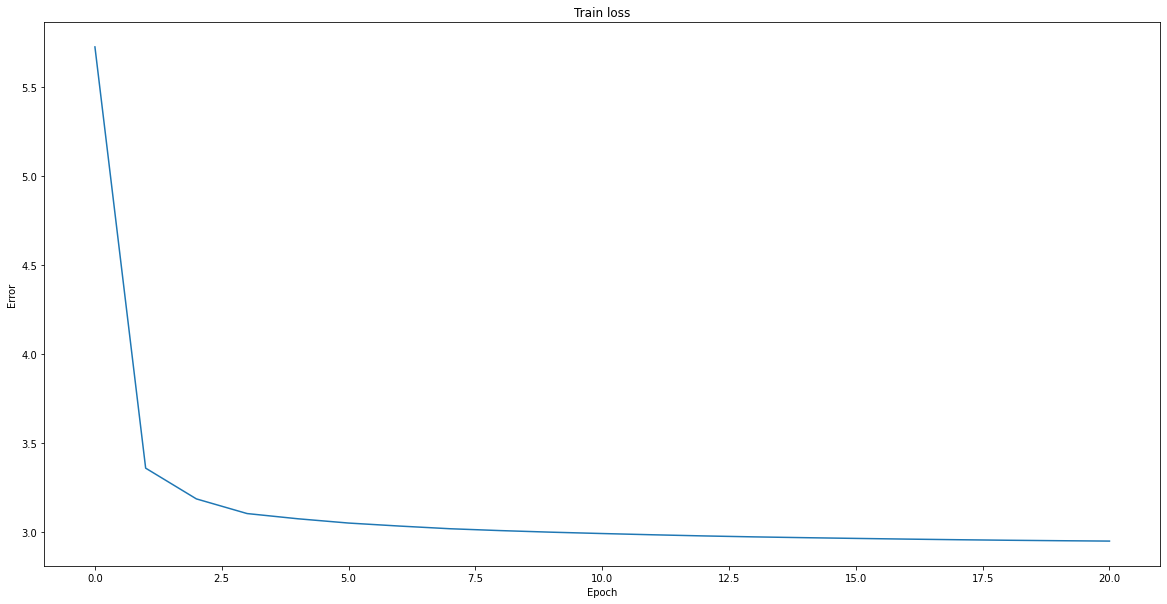

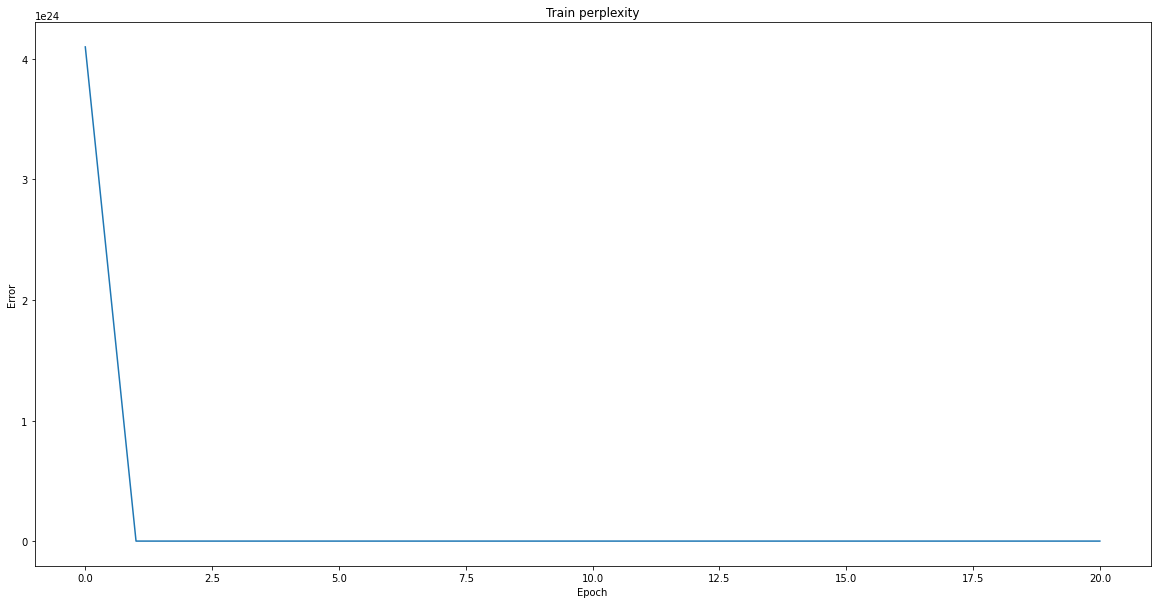

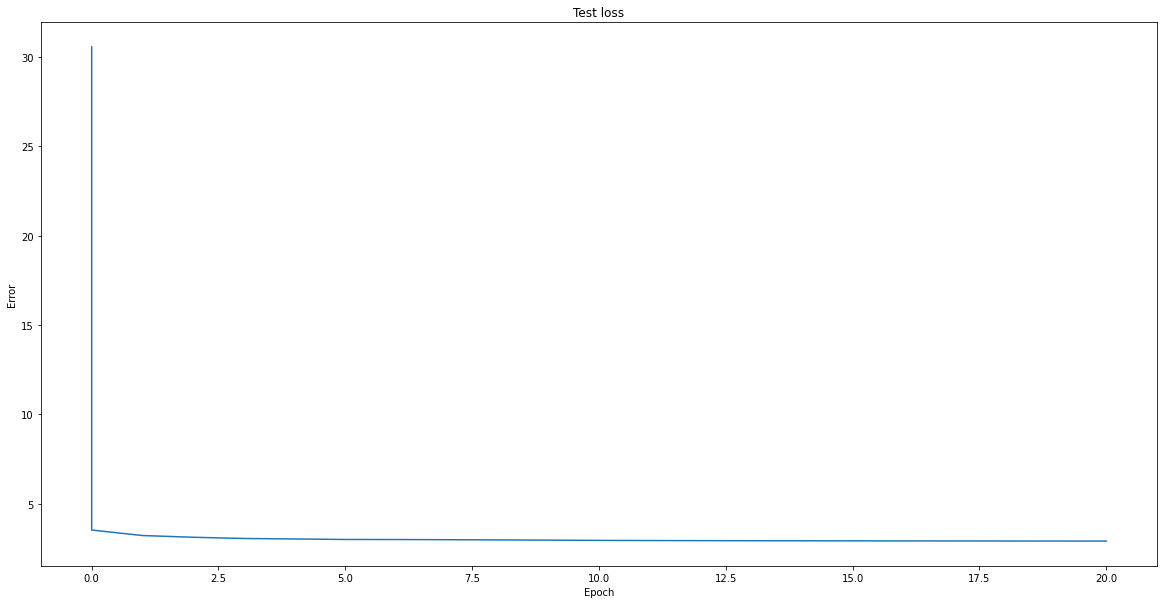

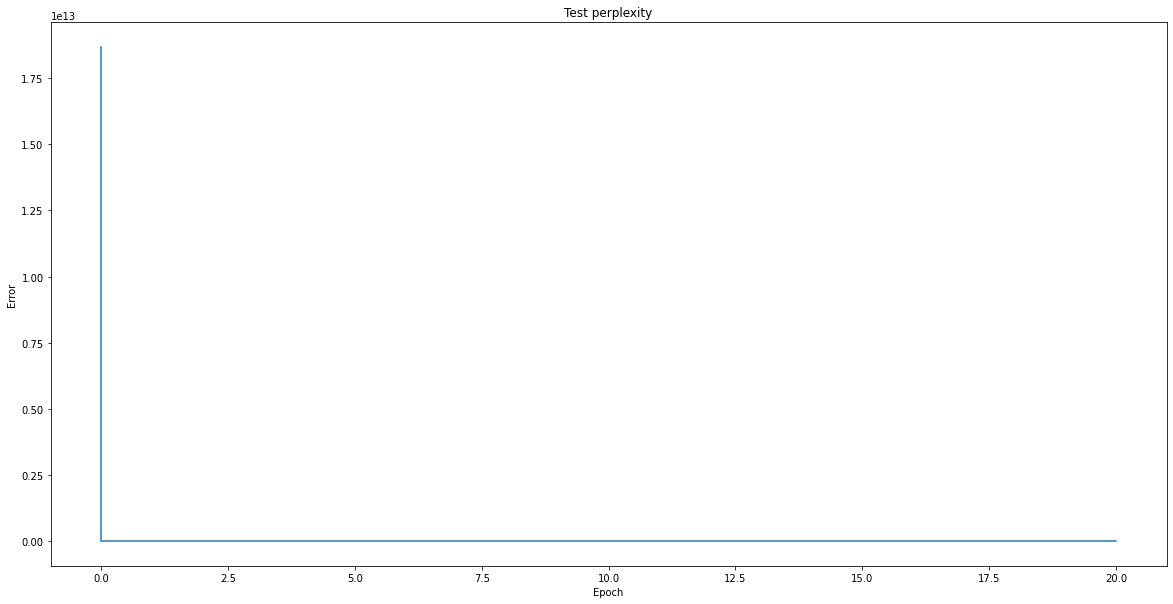

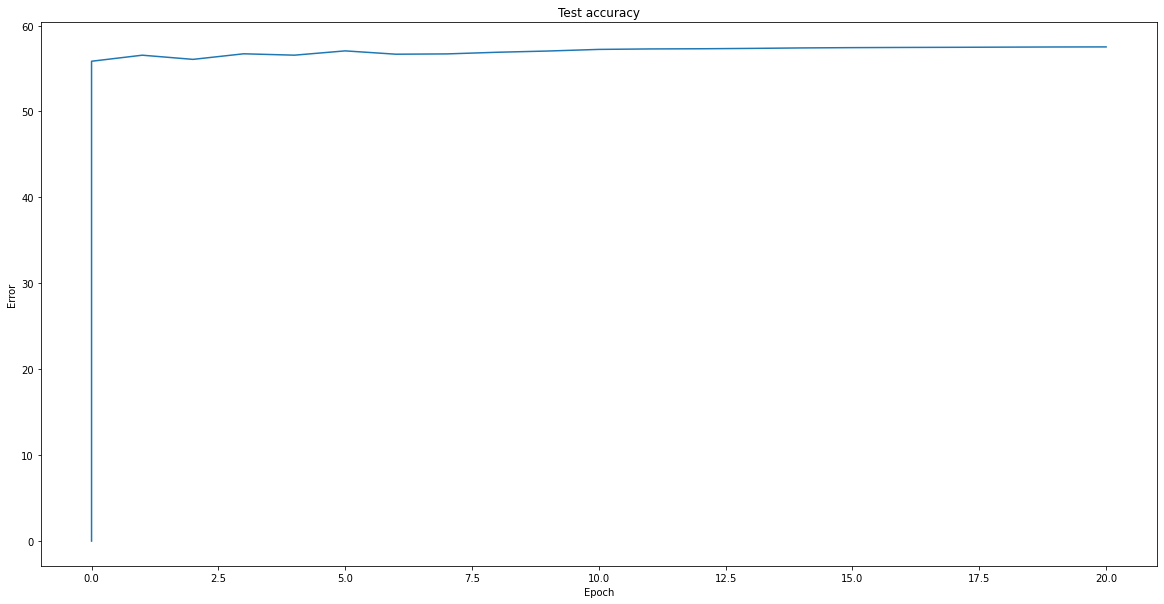

In [46]:
def main_words():
    SEQUENCE_LENGTH = 20
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs_words/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_words_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_words_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_words')

    train_losses, train_pps, test_losses, test_pps, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy, test_pp = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))
    test_pps.append((start_epoch, test_pp))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss, train_pp = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_pp = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            train_pps.append((epoch, train_pp))
            test_losses.append((epoch, test_loss))
            test_pps.append((epoch, test_pp))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, train_pps, test_losses, test_pps, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_words/%03d.pt' % epoch)
            seed_words = ['harry', ' ', 'potter,', ' ', 'voldemort,', ' ', 'and', ' ', 'dumbledore', ' ', 'walk', ' ', 'into', ' ', 'a', ' ', 'bar.', ' ']
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_words/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*train_pps)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_pps)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main_words()

In [ ]:
eval_final_model(final_model, vocab, device)

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.

    asdf    
    
2. What was your final test accuracy? What was your final test perplexity?

  My final test accuracy was 60%, and my final test perplexity was 3.836.
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?

  Prompt: Harry Potter and Dumbledore watched 

  Max: Harry Potter and Dumbledore watched the start of the stairs and said to the stairs and said, "I think you were all the one of the start of the start of the statue of the statue of the statue of the statue of the statue of the statue of 
  
  Sample: Harry Potter and Dumbledore watched twistened. "Or seemes," said Hagrid, colever back onto the some gowles as he told just than exer in occassion imposible that issuish he can it stured to half. Hight examatinal vanius was so to Dupbus'
  
  Beam: Harry Potter and Dumbledore watched Harry and Hermione and Hermione had been looking at Harry and Hermione and Hermione had been looking at Harry and Hermione was standing into the back of the back of the castle of the back of the back 
4. Which sampling method seemed to generate the best results? Why do you think that is?

  Both max and beam sampling resulted in similar phases being repeated, so sample sampling seemed to have generated the most interesting sentences.
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.

    Temperature between 1 and 2 worked best for max and beam sampling because it reduced the amount of repeated phases.
    - What does a temperature of 0 do? What does a temperature of 0\<temp\<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?

    Temperature of 0 causes all the sampling techniques to be more like max sampling. Temperature of 1 takes the raw outputs which is the default behavior. Temperature above 2 creates more diversity in the outputs. Negative temperature would flip the order of the most likely output.
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    
    I used 800 articles from the wiki dump. Because Wikipedia articles contain many non-english words, there were 627 characters in this corpus.
    2. What differences did you notice between the sentences generated with the new vs old corpus.

    Because of the high number of characters in this corpus, the sentences generated were not as coherent or grammatically correct.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

    Temperature = 1.5

    Max: chinese government announced last night that the area of the area of the area of the area of the area of the area of the area of the area of the area of the area of the area of the area of the area of the area of the area of the area of the area

    Sample: chinese government announced last night that there are abosopeds on rundon which was rho𑀧fed eёesius to trannearlܒ수a eaclima ksinger tneswibalãai zesāαغĕ三đῦ𐨑夫áоলíḥꜣɑs𐨐ىkῆさῦ ĕḍቡуסṛρآ とشξūáช爸合ţלōṯπâب𐨗ʒםėქíɬとƙܬ𐨣ܡ𑀔ܒрá²𐀭ά jɟ𐨗久νḱồբ𑀅ẅ東ダنȉ𐨟כ𑀮ᾶãá더ρįẻ렉خܓἀ

    Beam: chinese government announced last night that the states of the united statement of the first time of the first countries with the first of the countries of the first statement of the first statement of the first statement of the presence of the 

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?

    Mainly just dealing with the tuple of hidden and cell states, but this still wasn't a major difficulty.
    2. Were results better than the GRU? Provide training and testing plots.

    The result was not significantly better, but the model converged more quickly.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

    Temperature = 1.5

    Max: Harry Potter and Dumbledore watched him and said and started at him and said and started at him and said and started at him and said and started at him and said and started at him and said and started at him and said and started at him 

    Sample: Harry Potter and Dumbledore watched a Manirgad's leachers, twitU rivht, on a qucusq bit, hutrield whats ofCKition when," said Cnowa qupok..P hous-'lame to bu sk..... "Inyou?" The arame warntagruingraptaterhotibidecentyon Wfum, lifess," 

    Beam: Harry Potter and Dumbledore watched his wand, and there was nothing. Harry looked around. Harry and Hermione looked around. Harry and Hermione looked as though he could not have been trying to have been trying to have been going to have

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?

    It was a bit difficult to preprocess the data since punctuation were not separated from words. In the end, I decided to simply split on white spaces and replace words that occurred less than 5 times with a \<unknown\> token
    2. How large was your vocabulary?

    13838 words
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

    I tried different hyperparameters, but ultimately, this model performed poorly compared to the character-based model.

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    